# 2. Exploratory Data Analysis


Top 10 news domains:
                source_domain  count
0           www.benzinga.com   9629
1               www.fool.com   4894
2              www.zacks.com   4154
3          www.investors.com   2117
4        www.marketwatch.com   1546
5          www.thestreet.com    626
6  www.business-standard.com    461
7            www.reuters.com    332
8   www.financialexpress.com    324
9             www.forbes.com    297 



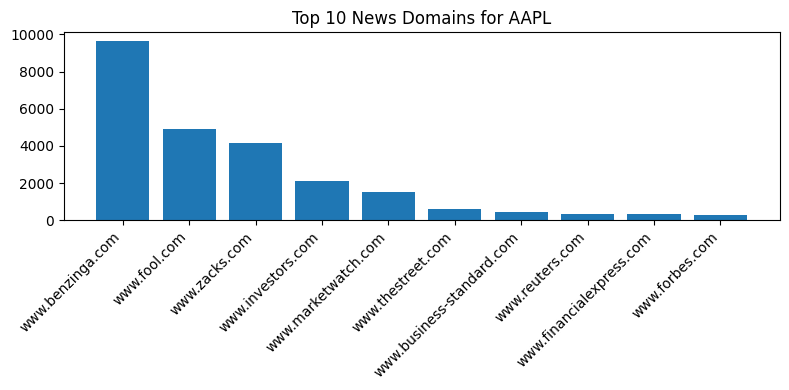


Merged sentiment & returns (first 5 rows):
         date  aapl_sent       close    return
0  2022-03-01  -0.247750  160.602931  0.020588
1  2022-03-02  -0.265587  163.909462 -0.001981
2  2022-03-03  -0.125093  163.584714 -0.018408
3  2022-03-04   0.048973  160.573409 -0.023718
4  2022-03-07  -0.000497  156.764994 -0.011676 



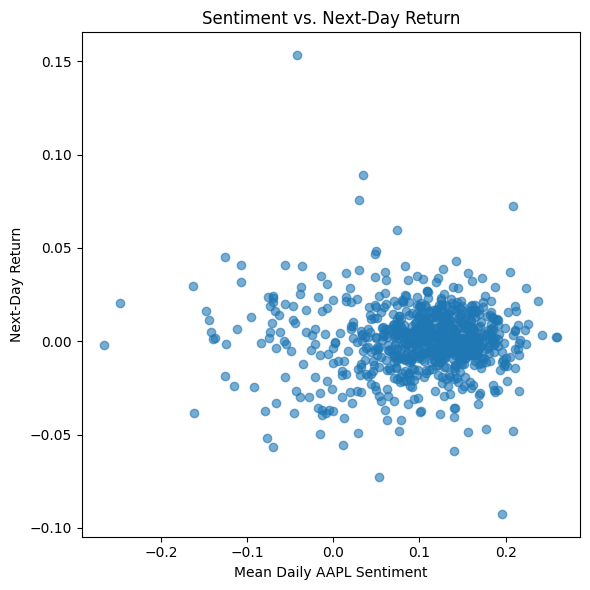

Linear regression results:
  MSE: 0.000348
  R² : 0.0000
  Coef (sentiment): -0.0011
  Intercept     : 0.0006


In [155]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# --- 1) Load & preprocess news ---
news = pd.read_csv(
    r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\data\extract\news\AAPL_news_2022-01-01_to_2025-05-01.csv",
    sep=';'
)

# Parse timestamp into date
news['date'] = pd.to_datetime(
    news['time_published'], format='%Y%m%dT%H%M%S'
).dt.date

# Extract only the AAPL ticker sentiment score
def extract_aapl_sentiment(s: str):
    try:
        tickers = json.loads(s.replace("'", '"'))
        for t in tickers:
            if t.get('ticker') == 'AAPL':
                return float(t.get('ticker_sentiment_score', 0))
    except Exception:
        return None

news['aapl_sent'] = news['ticker_sentiment'].apply(extract_aapl_sentiment)
news = news.dropna(subset=['aapl_sent'])

# Aggregate to daily mean sentiment
daily_sent = (
    news.groupby('date')['aapl_sent']
        .mean()
        .reset_index()
)

# Count top 10 news domains
top_sources = (
    news['source_domain']
        .value_counts()
        .head(10)
        .reset_index()
)
top_sources.columns = ['source_domain', 'count']


# --- 2) Load & preprocess prices ---
prices = pd.read_csv(
    r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\data\extract\stocks\AAPL\prices\AAPL_daily_adjusted.csv",
    parse_dates=['date']
)
# Find the adjusted close column
adj_col = [c for c in prices.columns if 'adjusted' in c.lower()][0]
prices = prices[['date', adj_col]].rename(columns={adj_col: 'close'})
prices['date'] = prices['date'].dt.date

# Compute next-day return
prices = prices.sort_values('date')
prices['return'] = prices['close'].pct_change().shift(-1)


# --- 3) Merge datasets ---
df = pd.merge(daily_sent, prices, on='date', how='inner').dropna()


# --- 4) Display tables & plots ---
print("\nTop 10 news domains:\n", top_sources, "\n")

plt.figure(figsize=(8,4))
plt.bar(top_sources['source_domain'], top_sources['count'])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 News Domains for AAPL")
plt.tight_layout()
plt.show()

print("\nMerged sentiment & returns (first 5 rows):")
print(df.head(), "\n")

plt.figure(figsize=(6,6))
plt.scatter(df['aapl_sent'], df['return'], alpha=0.6)
plt.xlabel("Mean Daily AAPL Sentiment")
plt.ylabel("Next-Day Return")
plt.title("Sentiment vs. Next-Day Return")
plt.tight_layout()
plt.show()


# --- 5) Regression analysis ---
X = df[['aapl_sent']]
y = df['return']

model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

mse = mean_squared_error(y, y_pred)
r2  = r2_score(y, y_pred)

print(f"Linear regression results:")
print(f"  MSE: {mse:.6f}")
print(f"  R² : {r2:.4f}")
print(f"  Coef (sentiment): {model.coef_[0]:.4f}")
print(f"  Intercept     : {model.intercept_:.4f}")

### *Step 1: Load and Explode Ticker Sentiment*

In this step, we load raw news data for a given ticker (e.g., AAPL) and extract the individual `ticker_sentiment` entries. Each entry is exploded into separate rows where:
- We keep only the sentiment values for the target ticker.
- We extract both the **Ticker Sentiment Score (TSS)** and the **Ticker Relevance Score (TRS)**.
- We convert the original timestamp into a `day_date`.
- We also compute the `week_date`, which represents the start of the week (Monday) for weekly aggregation.

### *Step 2: Aggregate Sentiment (TSS) and Relevance (TRS) Scores*

Here we compute the average:
- **Daily TSS and TRS** by grouping on `day_date`.
- **Weekly TSS and TRS** by grouping on `week_date`.

These aggregated values will be used later to correlate against the log returns of the corresponding stock prices, both on a daily and weekly basis.


In [ ]:
def explode_sentiment_data(news_path: str, ticker: str) -> pd.DataFrame:
    df = pd.read_csv(news_path, sep=';')

    rows = []
    for _, r in df.iterrows():
        try:
            sentiments = json.loads(r['ticker_sentiment'].replace("'", '"'))
            
        except:
            continue
        for sent in sentiments:
            if sent.get('ticker') == ticker:
                rows.append({
                    "day_date": pd.to_datetime(r["time_published"], format='%Y%m%dT%H%M%S').date(),
                    "ticker_sentiment_score": float(sent.get("ticker_sentiment_score", 0)),
                    "ticker_relevance_score": float(sent.get("relevance_score", 0)),
                    "title": r.get("title", ""),
                    "summary": r.get("summary", "")
                })
    
    exploded_df = pd.DataFrame(rows)

    # Week start date (Monday)
    exploded_df['week_date'] = pd.to_datetime(exploded_df['day_date']).dt.to_period('W').apply(lambda r: r.start_time.date())
    
    return exploded_df


def aggregate_sentiment(exploded_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    daily_agg = (
        exploded_df.groupby('day_date')[['ticker_sentiment_score', 'ticker_relevance_score']]
        .mean()
        .reset_index()
        .rename(columns={
            'ticker_sentiment_score': 'daily_tss',
            'ticker_relevance_score': 'daily_trs'
        })
    )

    weekly_agg = (
        exploded_df.groupby('week_date')[['ticker_sentiment_score', 'ticker_relevance_score']]
        .mean()
        .reset_index()
        .rename(columns={
            'ticker_sentiment_score': 'weekly_tss',
            'ticker_relevance_score': 'weekly_trs'
        })
    )

    return daily_agg, weekly_agg


In [126]:
# --- Load data ---
ticker = 'AAPL'
news_path = f"C:/Users/Victor/Downloads/MSc DataScience/MasterThesis - GitHub/data/extract/news/{ticker}_news_2022-01-01_to_2025-05-01.csv"
exploded_news = explode_sentiment_data(news_path, ticker)

# Filter by sentiment score > 0.3 or < -0.3 and by relevance score > 0.5
filtered_news = exploded_news[
    ((exploded_news["ticker_sentiment_score"] > 0.3) | 
     (exploded_news["ticker_sentiment_score"] < -0.3)) &
    (exploded_news["ticker_relevance_score"] > 0.5)
]

# --- Aggregation ---
daily_agg, weekly_agg = aggregate_sentiment(exploded_news)           # full news set
daily_agg_filtered, weekly_agg_filtered = aggregate_sentiment(filtered_news)  # only high-signal news

# --- Display output ---
print("Filtered News (|TSS| > 0.3 and TRS > 0.5):")
display(filtered_news.head())
display(filtered_news.shape)

print("News (original):")
display(exploded_news.head())
display(exploded_news.shape)

print("Daily Aggregation (full):")
display(daily_agg.head())
display(daily_agg.shape)

print("Daily Aggregation (filtered):")
display(daily_agg_filtered.head())
display(daily_agg_filtered.shape)

print("Weekly Aggregation (full):")
display(weekly_agg.head())
display(weekly_agg.shape)

print("Weekly Aggregation (filtered):")
display(weekly_agg_filtered.head())
display(weekly_agg_filtered.shape)


Filtered News (|TSS| > 0.3 and TRS > 0.5):


day_date  ticker_sentiment_score  ticker_relevance_score  \
124  2022-03-09                0.608306                0.515127   
213  2022-03-08                0.520191                0.621324   
266  2022-03-18                0.430615                0.779575   
332  2022-03-16                0.365825                0.975869   
438  2022-03-14               -0.662196                0.997247   

                                                 title  \
124                    Apple Launches New 5G iPhone SE   
213         2 Top Tech Stocks to Buy for the Long Haul   
266                 Is It Too Late to Buy Apple Stock?   
332  Apple  ( AAPL )  Releases watchOS 8.5, Leads S...   
438  Buy This Software Firm's Stock. Apple Is at th...   

                                               summary   week_date  
124  Apple  ( NASDAQ: AAPL ) , introduced several n...  2022-03-07  
213  The power of compounding works better the more...  2022-03-07  
266  Its market cap is reaching astronomical levels...  2022-03-14  
332  Apple (AAPL) is leading the smartwatch market ...  2022-03-14  
438  Buy Jamf Stock. Apple Is at the Core of the So...  2022-03-14

(2445, 6)

News (original):


day_date  ticker_sentiment_score  ticker_relevance_score  \
0  2022-03-04                0.030323                0.054535   
1  2022-03-04               -0.002192                0.100729   
2  2022-03-04                0.099433                0.136966   
3  2022-03-04               -0.039188                0.078188   
4  2022-03-04                0.078917                0.304774   

                                               title  \
0  Investor Lesson: Holding Great Companies Throu...   
1  Broadcom  ( AVGO )  Q1 Earnings and Revenues S...   
2  Marvell's  ( MRVL )  Q4 Earnings and Revenues ...   
3  Stock Market Today: Dow Jones, S&P 500 Tumble ...   
4  How to Boost Your Portfolio with Top Computer ...   

                                             summary   week_date  
0  If you want to do well as an investor, you hav...  2022-02-28  
1  Broadcom's (AVGO) first-quarter fiscal 2022 re...  2022-02-28  
2  Marvell's (MRVL) Q4 top and bottom lines refle...  2022-02-28  
3  Markets are down today as Ukraine concerns ove...  2022-02-28  
4  Investors looking for ways to find stocks that...  2022-02-28

(27075, 6)

Daily Aggregation (full):


day_date  daily_tss  daily_trs
0  2022-03-01  -0.247750   0.062711
1  2022-03-02  -0.265587   0.108298
2  2022-03-03  -0.125093   0.106414
3  2022-03-04   0.048973   0.114603
4  2022-03-05  -0.496675   0.120783

(1158, 3)

Daily Aggregation (filtered):


day_date  daily_tss  daily_trs
0  2022-03-08   0.520191   0.621324
1  2022-03-09   0.608306   0.515127
2  2022-03-12  -0.662196   0.997247
3  2022-03-14  -0.662196   0.997247
4  2022-03-16   0.365825   0.975869

(913, 3)

Weekly Aggregation (full):


week_date  weekly_tss  weekly_trs
0  2022-02-28   -0.119500    0.121014
1  2022-03-07   -0.019010    0.282861
2  2022-03-14   -0.024979    0.286736
3  2022-03-21    0.007377    0.331512
4  2022-03-28   -0.017397    0.330079

(166, 3)

Weekly Aggregation (filtered):


week_date  weekly_tss  weekly_trs
0  2022-03-07    0.155434    0.711233
1  2022-03-14    0.044748    0.917564
2  2022-03-21   -0.026783    0.901629
3  2022-03-28    0.404837    0.826623
4  2022-04-04   -0.048016    0.591711

(165, 3)

### *Step 3 (Updated): Daily Prices – Raw and Log Returns*

We load daily adjusted prices and compute:
- `return_d+1`: Standard percent change return between day t and t+1.
- `log_return_d+1`: Stationary log return between day t and t+1.

These metrics help capture different return dynamics. Log returns are additive and better suited for modeling stationary relationships.


### *Step 4 (Updated): Weekly Prices – Raw and Log Returns*

We perform the same calculations as above but on a weekly basis, generating:
- `return_w+1`: Percent return from this week to next.
- `log_return_w+1`: Log return from this week to next.

This lets us study how sentiment affects performance both in the short-term (daily) and mid-term (weekly).



In [199]:
# --- Load daily prices and compute +1 day raw and log returns ---
def load_daily_returns(price_path: str) -> pd.DataFrame:
    df = pd.read_csv(price_path, parse_dates=['date'])

    # Detectar columna ajustada correctamente
    adj_col = [c for c in df.columns if 'adjusted close' in c.lower()][0]
    df = df[['date', adj_col]].rename(columns={adj_col: 'adjusted_close'})
    df['date'] = df['date'].dt.date

    df = df.sort_values('date')
    df['return_d+1'] = df['adjusted_close'].pct_change().shift(-1)
    df['log_return_d+1'] = np.log(df['adjusted_close'].shift(-1)) - np.log(df['adjusted_close'])

    return df[['date', 'adjusted_close', 'return_d+1', 'log_return_d+1']]


# --- Run for AAPL daily data ---
daily_price_path = f"C:/Users/Victor/Downloads/MSc DataScience/MasterThesis - GitHub/data/extract/stocks/{ticker}/prices/{ticker}_daily_adjusted.csv"
daily_returns_df = load_daily_returns(daily_price_path)
daily_returns_df.tail()

date  adjusted_close  return_d+1  log_return_d+1
4  2025-04-17          196.98   -0.019393       -0.019583
3  2025-04-21          193.16    0.034065        0.033498
2  2025-04-22          199.74    0.024332        0.024040
1  2025-04-23          204.60    0.018426        0.018258
0  2025-04-24          208.37         NaN             NaN

In [ ]:
# --- Load weekly prices and compute +1 week raw and log returns ---
def load_weekly_returns(price_path: str) -> pd.DataFrame:
    df = pd.read_csv(price_path, parse_dates=['date'])

    # Buscar la columna correcta con "adjusted close"
    adj_col = [c for c in df.columns if 'adjusted close' in c.lower()][0]
    df = df[['date', adj_col]].rename(columns={adj_col: 'adjusted_close'})

    # Normalizar la fecha a lunes (inicio de semana)
    df['date'] = pd.to_datetime(df['date']).dt.to_period('W').apply(lambda r: r.start_time.date())

    df = df.sort_values('date')
    df['return_w+1'] = df['adjusted_close'].pct_change().shift(-1)
    df['log_return_w+1'] = np.log(df['adjusted_close'].shift(-1)) - np.log(df['adjusted_close'])

    return df[['date', 'adjusted_close', 'return_w+1', 'log_return_w+1']]


# --- Run for AAPL weekly data ---
weekly_price_path = f"C:/Users/Victor/Downloads/MSc DataScience/MasterThesis - GitHub/data/extract/stocks/{ticker}/prices/{ticker}_weekly_adjusted.csv"
weekly_returns_df = load_weekly_returns(weekly_price_path)
weekly_returns_df.tail()


date  adjusted_close  return_w+1  log_return_w+1
1328  1999-11-08          0.6817    0.020097        0.019898
1327  1999-11-15          0.6954    0.028329        0.027935
1326  1999-11-22          0.7151    0.209761        0.190423
1325  1999-11-29          0.8651   -0.104381       -0.110240
1324  1999-12-06          0.7748   -0.029040       -0.029470

### *Step 5: Merge Sentiment with Returns and Run Regression*

We now merge:
- Daily sentiment with daily returns (`t+1`)
- Weekly sentiment with weekly returns (`t+1w`)

Then we run linear regressions:
- Independent variable (X): `TSS` (Ticker Sentiment Score)
- Dependent variable (y): `return` or `log_return`

This helps us understand:
- Is there any predictive signal in daily/weekly sentiment?
- Does the sentiment correlate more with raw or log returns?


In [ ]:
# Merge
merged_daily = pd.merge(daily_agg, daily_returns_df, left_on='day_date', right_on='date', how='inner')
merged_weekly = pd.merge(weekly_agg, weekly_returns_df, left_on='week_date', right_on='date', how='inner')
merged_daily_filtered = pd.merge(daily_agg_filtered, daily_returns_df, left_on='day_date', right_on='date', how='inner')
merged_weekly_filtered = pd.merge(weekly_agg_filtered, weekly_returns_df, left_on='week_date', right_on='date', how='inner')

(24008, 7)


In [131]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def run_all_sentiment_regressions(df, prefix='Daily'):
    # Pares de (sentiment_column, return_column)
    tests = [
        ('tss', 'return'),
        ('tss', 'log_return'),
    ]

    for sent_type, ret_type in tests:
        sent_col = f"{prefix.lower()}_{sent_type}"
        ret_col = f"{ret_type}_{'d+1' if prefix == 'Daily' else 'w+1'}"
        label = f"{prefix.upper()} | {sent_type.upper()} vs {ret_type}"

        # Preparar datos
        data = df[[sent_col, ret_col]].dropna()
        if data.empty:
            print(f"⚠️  No data for {label}. Skipping.")
            continue

        X = data[[sent_col]]
        y = data[ret_col]
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)

        print(f"\n📊 --- {label} ---")
        print(f"R² Score:     {r2_score(y, y_pred):.4f}")
        print(f"MSE:          {mean_squared_error(y, y_pred):.6f}")
        print(f"Coef:         {model.coef_[0]:.4f}")
        print(f"Intercept:    {model.intercept_:.4f}")

        # Plot
        plt.figure(figsize=(6, 6))
        plt.scatter(X, y, alpha=0.5)
        plt.plot(X, y_pred, color='red', label='Regression Line')
        plt.xlabel(sent_col)
        plt.ylabel(ret_col)
        plt.title(label)
        plt.grid(True)
        plt.tight_layout()
        plt.show()



📊 --- DAILY | TSS vs return ---
R² Score:     0.0000
MSE:          0.000348
Coef:         -0.0011
Intercept:    0.0006


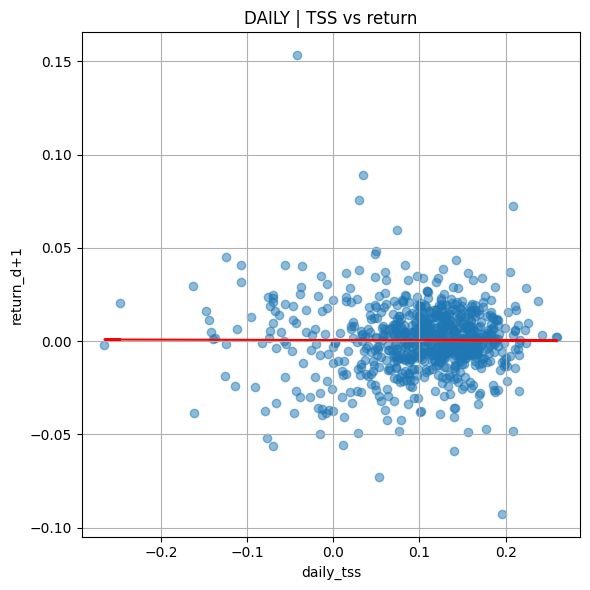


📊 --- DAILY | TSS vs log_return ---
R² Score:     0.0000
MSE:          0.000346
Coef:         -0.0000
Intercept:    0.0003


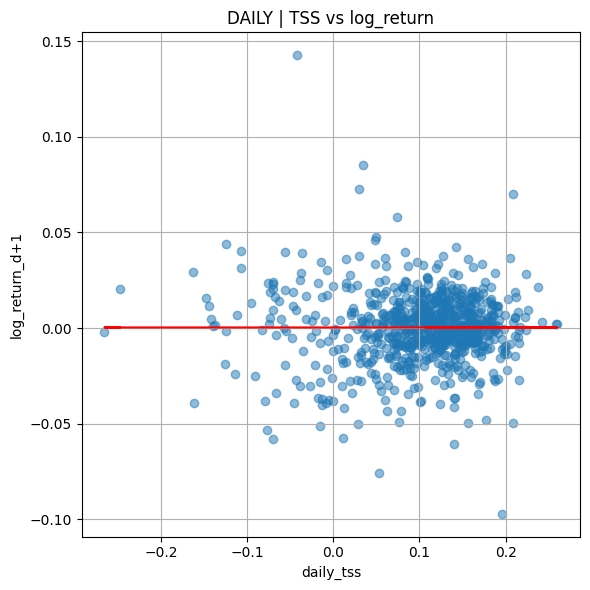

In [132]:
run_all_sentiment_regressions(merged_daily, prefix='Daily')
#run_all_sentiment_regressions(merged_weekly, prefix='Weekly')

### *Step 7: Filtering for Strong News Events*

In the previous analysis, we observed very low predictive power from sentiment and relevance.

To improve signal quality, we now filter the news data to include only:
- Highly relevant news (`relevance > 0.5`)
- Strongly positive (`TSS > 0.3`) or strongly negative (`TSS < -0.3`) sentiment

This approach isolates impactful events and may reveal hidden relationships between extreme sentiment and next-day or next-week market returns.



📊 --- DAILY | TSS vs return ---
R² Score:     0.0004
MSE:          0.000338
Coef:         0.0014
Intercept:    0.0005


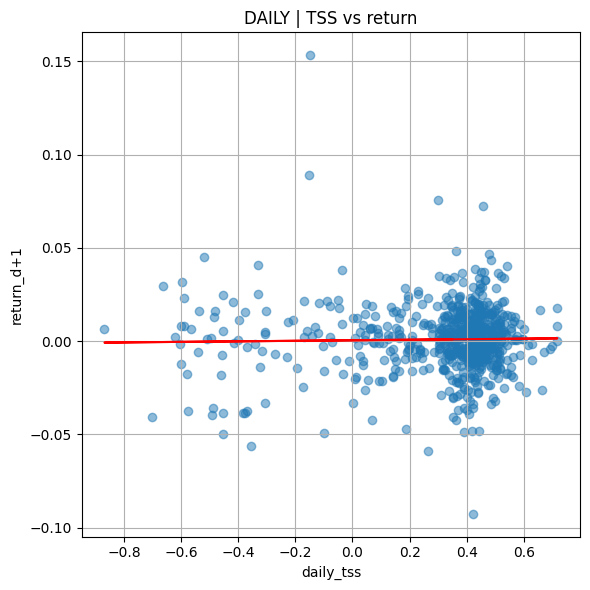


📊 --- DAILY | TSS vs log_return ---
R² Score:     0.0006
MSE:          0.000335
Coef:         0.0017
Intercept:    0.0002


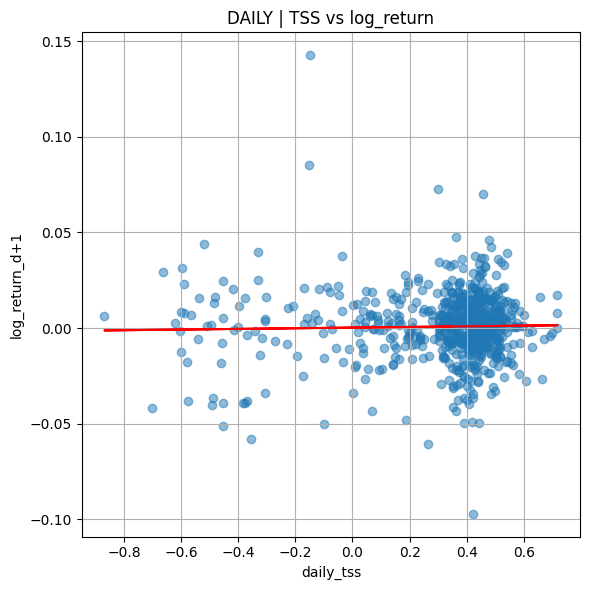


📊 --- WEEKLY | TSS vs return ---
R² Score:     0.0002
MSE:          0.001484
Coef:         0.0027
Intercept:    0.0019


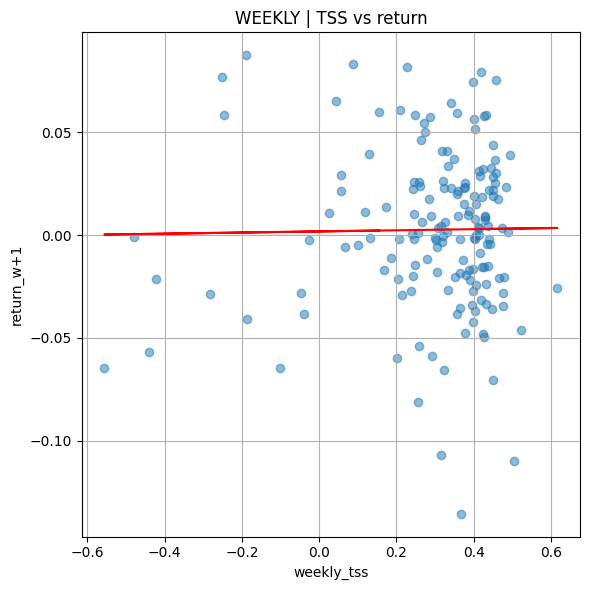


📊 --- WEEKLY | TSS vs log_return ---
R² Score:     0.0003
MSE:          0.001503
Coef:         0.0035
Intercept:    0.0009


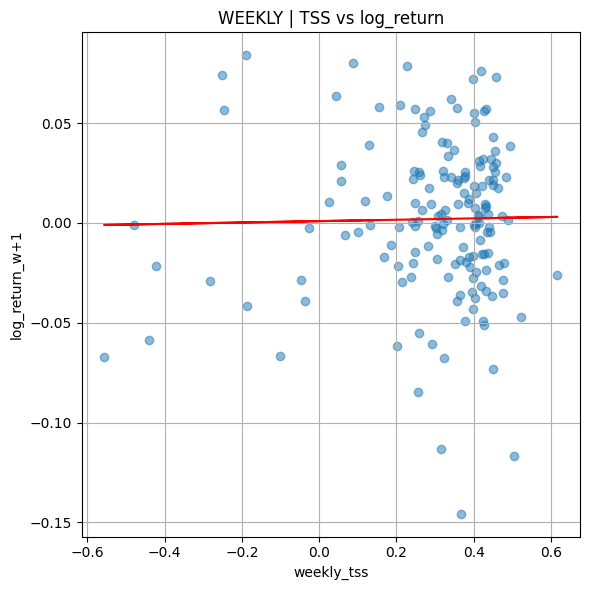

In [133]:
# Run updated regressions
run_all_sentiment_regressions(merged_daily_filtered, prefix='Daily')
run_all_sentiment_regressions(merged_weekly_filtered, prefix='Weekly')


In [86]:
# ─── Cell 1: Imports y configuración OpenAI ─────────────────────────────────────────

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import ast

from datetime import timedelta
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Tu clave de OpenAI (preferible vía entorno)
openai.api_key = os.getenv("OPENAI_API_KEY", "TU_OPENAI_KEY")


📘 Why Log Returns and Lagged Returns Matter
1. Why log returns?
Log returns are stationary: they remove trends and allow better correlation with things like news or sentiment.

They are additive: log return from day 1 to 3 = log return (1→2) + log return (2→3).

They approximate percentage returns for small values, but behave better for compounding and statistical modeling.

2. Why lagged returns (d_log+1)?
Your goal is prediction: Does today’s news sentiment affect tomorrow’s return?

That’s why we shift returns: so log_return_{t+1} aligns with sentiment_t.

Otherwise, you'd be modeling correlation, not causation or prediction.

3. Why d_log (non-lagged)?
You might want to analyze whether same-day sentiment moves prices within the same day — useful for intraday or high-frequency strategies.

Can be used to compare: does same-day or next-day sentiment have more impact?



In [23]:
# Force both weekly date columns to represent the start of the same week (Monday)
weekly_agg['week_date'] = pd.to_datetime(weekly_agg['week_date']).dt.to_period('W').apply(lambda r: r.start_time.date())
weekly_returns_df['date'] = pd.to_datetime(weekly_returns_df['date']).dt.to_period('W').apply(lambda r: r.start_time.date())

# Now re-merge
merged_weekly = pd.merge(weekly_agg, weekly_returns_df, left_on='week_date', right_on='date', how='inner')

# Check
print("✅ Merged weekly shape:", merged_weekly.shape)
display(merged_weekly.head())

✅ Merged weekly shape: (165, 6)


week_date  weekly_tss  weekly_trs        date  return_w+1  log_return_w+1
0  2022-02-28   -0.119500    0.121014  2022-02-28   -0.051725       -0.053111
1  2022-03-07   -0.019010    0.282861  2022-03-07    0.059782        0.058063
2  2022-03-14   -0.024979    0.286736  2022-03-14    0.065496        0.063440
3  2022-03-21    0.007377    0.331512  2022-03-21   -0.002347       -0.002350
4  2022-03-28   -0.017397    0.330079  2022-03-28   -0.024209       -0.024507

### *Step 8: SMA and EMA for Price and Sentiment*

To explore trends and smoothing effects, we plot:

- **AAPL Adjusted Close Price** with:
  - Simple Moving Averages (SMA) of 10 and 50 days
  - Exponential Moving Averages (EMA) of 10 and 50 days

- **Daily Ticker Sentiment Score (TSS)** with:
  - SMA and EMA over 5 and 10 days

These indicators help highlight trend reversals, support/resistance levels, and allow visual comparison between market movements and aggregated sentiment dynamics.


In [41]:
def plot_price_and_sentiment_moving_averages(price_df: pd.DataFrame, tss_df: pd.DataFrame):
    # --- Prepare price data ---
    p_df = price_df.copy()
    p_df = p_df[p_df['date'] >= pd.to_datetime('2022-01-01').date()]
    p_df = p_df.sort_values('date')
    p_df.set_index('date', inplace=True)

    p_df['SMA_10'] = p_df['close'].rolling(window=10).mean()
    p_df['EMA_10'] = p_df['close'].ewm(span=10, adjust=False).mean()

    # --- Prepare TSS data ---
    s_df = tss_df.copy()
    s_df = s_df[s_df['day_date'] >= pd.to_datetime('2022-01-01').date()]
    s_df = s_df.sort_values('day_date')
    s_df.set_index('day_date', inplace=True)

    s_df['SMA_5'] = s_df['daily_tss'].rolling(window=5).mean()
    s_df['EMA_5'] = s_df['daily_tss'].ewm(span=5, adjust=False).mean()

    # --- Plot both ---
    fig, ax1 = plt.subplots(figsize=(14, 6))

    ax1.set_title("AAPL Price vs Sentiment Moving Averages (2022–Present)", fontsize=14)
    ax1.set_xlabel("Date")

    # Price on left y-axis
    ax1.set_ylabel("AAPL Price", color='black')
    ax1.plot(p_df.index, p_df['close'], label='Close Price', color='black', alpha=0.4)
    ax1.plot(p_df.index, p_df['SMA_10'], label='SMA 10 (Price)', color='blue', linestyle='--')
    ax1.plot(p_df.index, p_df['EMA_10'], label='EMA 10 (Price)', color='blue')

    # Sentiment on right y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel("TSS", color='green')
    ax2.plot(s_df.index, s_df['daily_tss'], label='Daily TSS', color='green', alpha=0.3)
    ax2.plot(s_df.index, s_df['SMA_5'], label='SMA 5 (TSS)', color='orange', linestyle='--')
    ax2.plot(s_df.index, s_df['EMA_5'], label='EMA 5 (TSS)', color='orange')

    # Legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    ax1.grid(True)
    plt.tight_layout()
    plt.show()


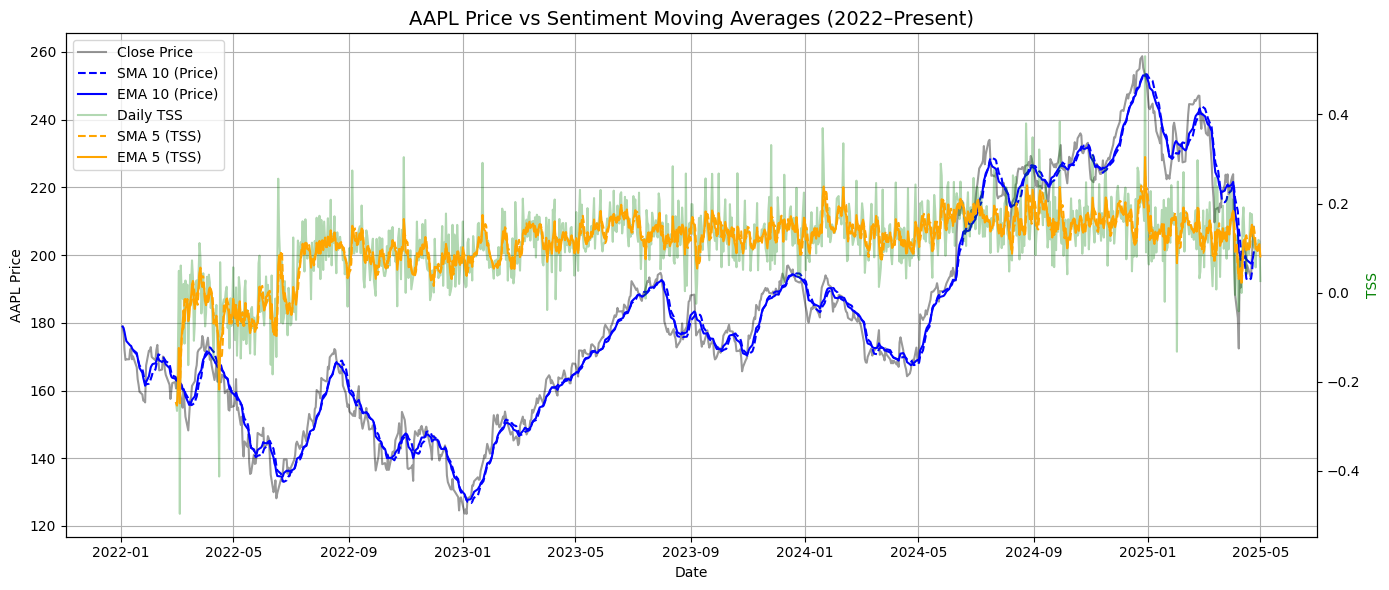

In [42]:
plot_price_and_sentiment_moving_averages(daily_prices_df, daily_agg)


### *Step 9: Detrended Price vs Sentiment*

To focus only on relative fluctuations, we remove the long-term trend from AAPL’s adjusted close price using `scipy.signal.detrend`.

This allows us to:
- Visually detect if peaks in sentiment align with reversals or swings in price.
- Identify potential short-term signals that may be hidden by long-term growth patterns.


In [43]:
from scipy.signal import detrend

def plot_detrended_price_vs_sentiment(price_df: pd.DataFrame, tss_df: pd.DataFrame):
    # --- Filter and align data ---
    p_df = price_df[price_df['date'] >= pd.to_datetime('2022-01-01').date()].copy()
    p_df = p_df.sort_values('date').reset_index(drop=True)

    s_df = tss_df[tss_df['day_date'] >= pd.to_datetime('2022-01-01').date()].copy()
    s_df = s_df.sort_values('day_date').reset_index(drop=True)

    # --- Apply detrend ---
    p_df['detrended_close'] = detrend(p_df['close'])

    # --- Merge for aligned plotting ---
    merged = pd.merge(p_df[['date', 'detrended_close']], s_df[['day_date', 'daily_tss']],
                      left_on='date', right_on='day_date', how='inner')

    # --- Plot ---
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.set_title("Detrended AAPL Price vs Daily TSS (2022–Present)", fontsize=14)
    ax1.set_xlabel("Date")

    # Detrended price
    ax1.set_ylabel("Detrended Price", color='black')
    ax1.plot(merged['date'], merged['detrended_close'], label='Detrended AAPL Price', color='black', linewidth=1)

    # TSS on right y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel("TSS", color='green')
    ax2.plot(merged['date'], merged['daily_tss'], label='Daily TSS', color='green', alpha=0.5)

    # Legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    ax1.grid(True)
    plt.tight_layout()
    plt.show()


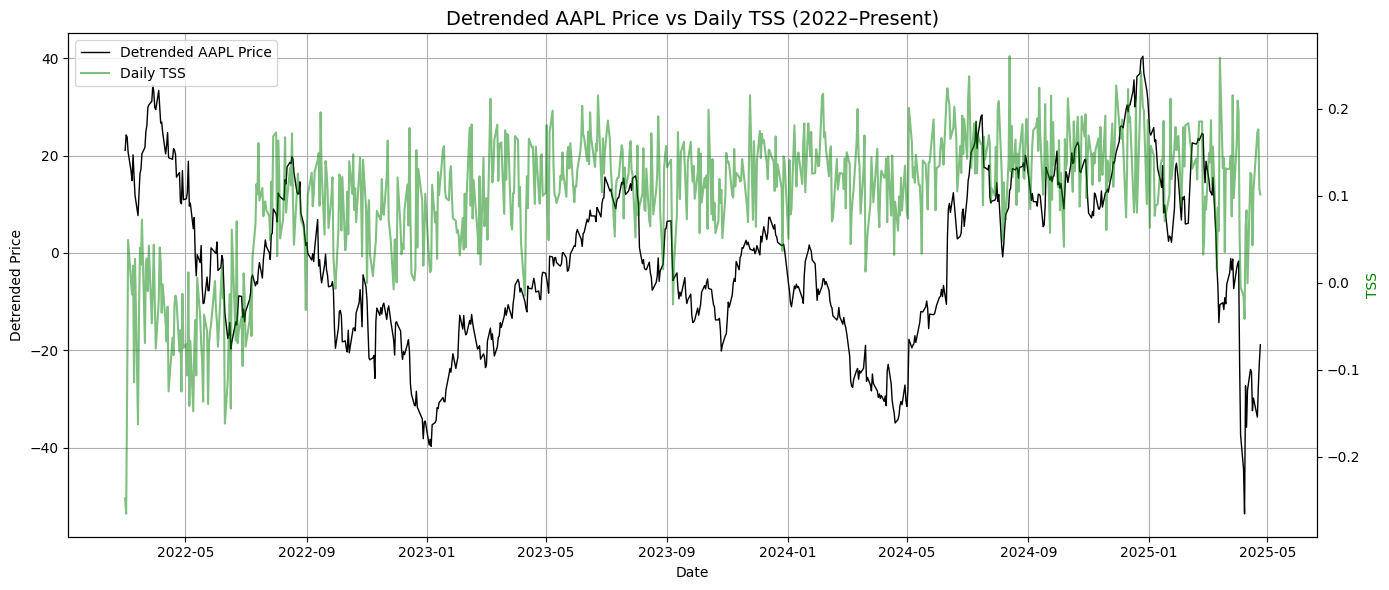

In [44]:
plot_detrended_price_vs_sentiment(daily_prices_df, daily_agg)


In [45]:
from sklearn.preprocessing import StandardScaler

def plot_detrended_vs_smoothed_scaled_sentiment(price_df, tss_df):
    # --- Filter by date ---
    p_df = price_df[price_df['date'] >= pd.to_datetime('2022-01-01').date()].copy()
    s_df = tss_df[tss_df['day_date'] >= pd.to_datetime('2022-01-01').date()].copy()

    # --- Detrend price ---
    p_df = p_df.sort_values('date').reset_index(drop=True)
    p_df['detrended_close'] = detrend(p_df['close'])

    # --- Smooth sentiment ---
    s_df = s_df.sort_values('day_date').reset_index(drop=True)
    s_df['smoothed_tss'] = s_df['daily_tss'].rolling(window=5).mean()

    # --- Merge aligned ---
    merged = pd.merge(
        p_df[['date', 'detrended_close']],
        s_df[['day_date', 'smoothed_tss']],
        left_on='date', right_on='day_date',
        how='inner'
    )

    # --- Standardize both series ---
    scaler = StandardScaler()
    merged[['detrended_close_scaled', 'smoothed_tss_scaled']] = scaler.fit_transform(
        merged[['detrended_close', 'smoothed_tss']]
    )

    # --- Plot ---
    plt.figure(figsize=(14, 6))
    plt.plot(merged['date'], merged['detrended_close_scaled'], label='Detrended Price (scaled)', color='black')
    plt.plot(merged['date'], merged['smoothed_tss_scaled'], label='Smoothed TSS (scaled)', color='green', alpha=0.6)
    plt.title("Detrended AAPL Price vs Smoothed TSS (Scaled, 2022–Present)")
    plt.xlabel("Date")
    plt.ylabel("Standardized Values (z-score)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


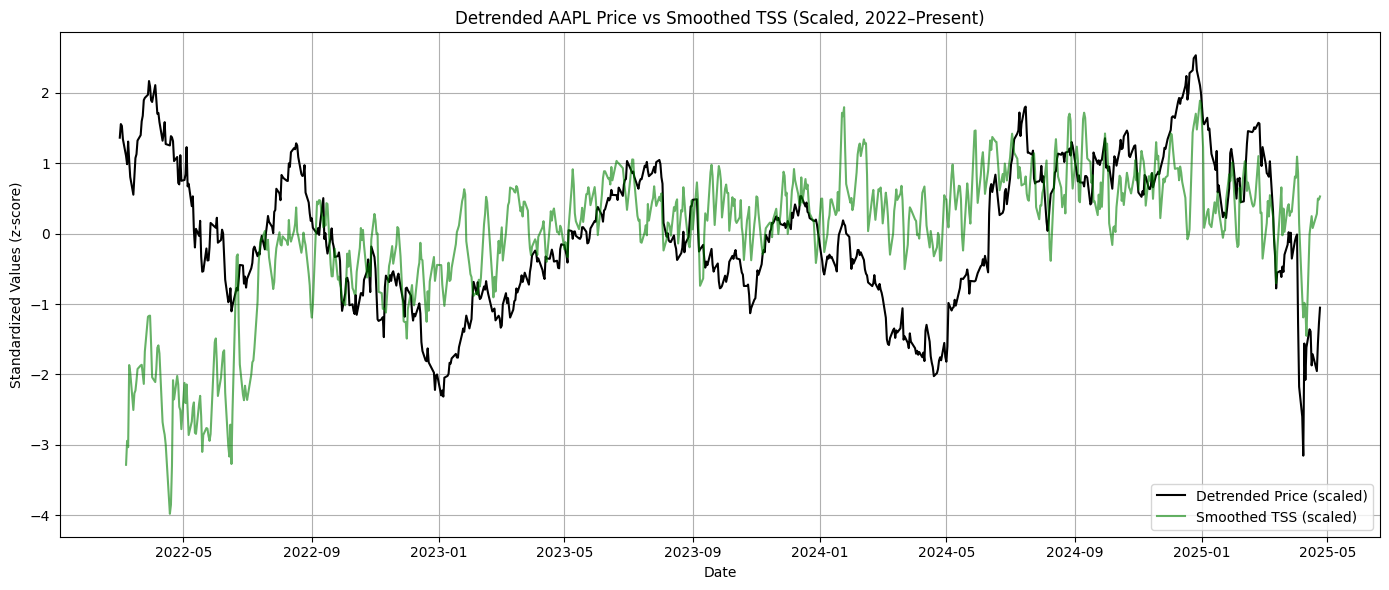

In [46]:
plot_detrended_vs_smoothed_scaled_sentiment(daily_prices_df, daily_agg)


### *Step 10: Lagged Correlation Between TSS and Detrended Price*

To test whether sentiment today can predict future price movements, we:

- Shift the detrended price forward by 0 to 10 days.
- Compute Pearson correlation with today's smoothed TSS.
- Plot the lagged correlation profile.

Peaks in correlation at certain lags suggest delayed market reaction to sentiment — potential for predictive trading signals.


In [49]:
def correlation_tss_vs_detrended_price_lags(price_df, tss_df, max_lag=10, window=5):
    # --- Prepare data ---
    p_df = price_df[price_df['date'] >= pd.to_datetime('2022-01-01').date()].copy()
    s_df = tss_df[tss_df['day_date'] >= pd.to_datetime('2022-01-01').date()].copy()

    p_df = p_df.sort_values('date').reset_index(drop=True)
    s_df = s_df.sort_values('day_date').reset_index(drop=True)

    p_df['detrended_close'] = detrend(p_df['close'])
    s_df['smoothed_tss'] = s_df['daily_tss'].rolling(window=window).mean()

    # Merge aligned by date
    merged = pd.merge(
        p_df[['date', 'detrended_close']],
        s_df[['day_date', 'smoothed_tss']],
        left_on='date', right_on='day_date',
        how='inner'
    ).dropna()

    # Store correlations
    correlations = []

    for lag in range(0, max_lag + 1):
        shifted = merged.copy()
        shifted['lagged_tss'] = shifted['smoothed_tss'].shift(lag)
        shifted = shifted.dropna()
        corr = shifted['lagged_tss'].corr(shifted['detrended_close'])
        correlations.append((lag, corr))

    # Plot
    lags, values = zip(*correlations)
    plt.figure(figsize=(8, 5))
    plt.plot(lags, values, marker='o')
    plt.title(f"Correlation between Lagged TSS and Detrended Price (TSS lagged 0 to {max_lag} days)")
    plt.xlabel("Lag (days)")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.xticks(lags)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()

    # Also return for inspection if needed
    return correlations


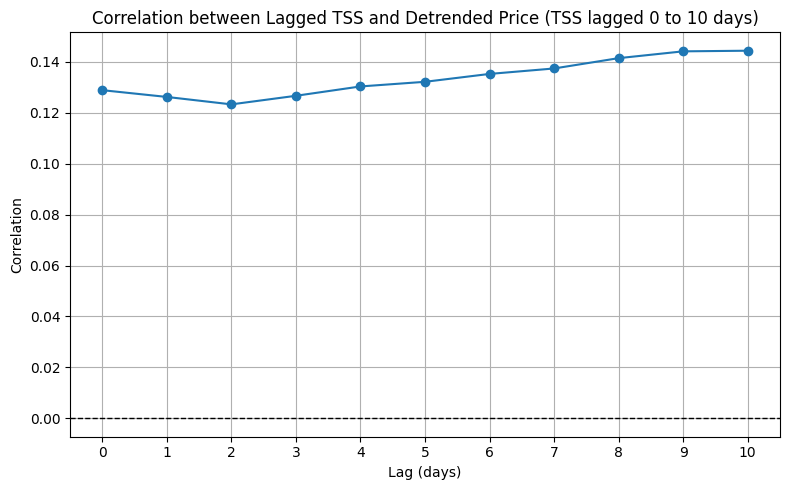

[(0, 0.1288773656018695),
 (1, 0.12621903449144378),
 (2, 0.12329998639528437),
 (3, 0.12667160690244997),
 (4, 0.1303402562026776),
 (5, 0.1321623091395779),
 (6, 0.13525702384732136),
 (7, 0.1374005091759818),
 (8, 0.14145284636951544),
 (9, 0.1441259971493228),
 (10, 0.14437235947763472)]

In [50]:
correlation_tss_vs_detrended_price_lags(daily_prices_df, daily_agg, max_lag=10, window=5)


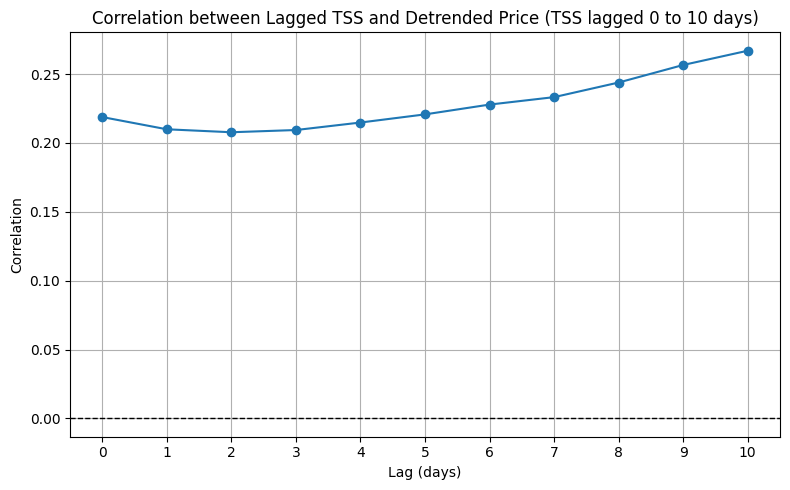

[(0, 0.2188250447604607),
 (1, 0.2099456893814755),
 (2, 0.20779513408709355),
 (3, 0.20940800233771875),
 (4, 0.21485586577381716),
 (5, 0.22076837190146065),
 (6, 0.227892855068924),
 (7, 0.23329671519758582),
 (8, 0.24391516528184382),
 (9, 0.2566496482801076),
 (10, 0.2670154288709148)]

In [ ]:
# Merge with TRS to filter highly relevant sentiment
sentiment_trs = exploded_news[
    exploded_news['ticker_relevance_score'] > 0.75
]

# Aggregate again
daily_trs_filtered, _ = aggregate_sentiment(sentiment_trs)

# Run correlation with high TRS filter
correlation_tss_vs_detrended_price_lags(daily_prices_df, daily_trs_filtered, max_lag=10, window=5)


## Lagged Correlation Analysis: TSS vs Detrended Price

### *What do we observe?*

The correlation is **positive and increases steadily with lag** — starting at ~0.22 for lag 0 and reaching ~0.27 by lag 10.

This suggests that **sentiment from 7–10 days ago has a stronger correlation with today's detrended price** than more recent sentiment.

### *How to interpret this?*

💡 **Strong sentiment signals take time to materialize** in price movements — especially once we remove long-term trends.

**Possible explanations:**
- Investors **react gradually or with delay** to news.
- Some news events take several days to influence actual trading behavior.
- This may also reflect **sentiment momentum**, where positive sentiment builds up and influences price over time.


### *How could this be improved?*

- **Separate bullish vs bearish news:**  
  Are effects symmetric? Maybe only `TSS > 0.3` (bullish) drives positive price action.

- **Filter by TRS > 0.7:**  
  News that's highly relevant to the asset may show **stronger and cleaner correlations**.

- **Use alternative detrending (e.g., HP-filter or rolling mean):**  
  This could more accurately isolate short-term movements from longer trends.

- **Try multivariate regression using multiple lags:**  
  Build a model with `TSS_t`, `TSS_t-1`, ..., `TSS_t-10` as predictors to test joint effects.

### *Summary*

Filtering by **relevance (TRS > 0.75)** improves correlation more than just filtering by sentiment strength.  
This suggests that **investors act more on relevant news than just on sentiment polarity**.

Combining both may yield even better predictive signals.


## 🧠 Multivariate Regression Using Lagged TSS

We build a linear regression model using:

- Features: Smoothed `TSS_t`, `TSS_t-1`, ..., `TSS_t-10`
- Target: Detrended price on day `t`

This captures the **joint predictive power** of past sentiment over several days.  
The resulting coefficients show how each lag contributes to explaining the price movement.


In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

def multivariate_lagged_tss_regression(price_df, tss_df, max_lag=10, window=5):
    # Prepare base data
    p_df = price_df[price_df['date'] >= pd.to_datetime('2022-01-01').date()].copy()
    s_df = tss_df[tss_df['day_date'] >= pd.to_datetime('2022-01-01').date()].copy()

    p_df = p_df.sort_values('date').reset_index(drop=True)
    s_df = s_df.sort_values('day_date').reset_index(drop=True)

    # Detrend price
    p_df['detrended_close'] = detrend(p_df['close'])

    # Smooth TSS
    s_df['smoothed_tss'] = s_df['daily_tss'].rolling(window=window).mean()

    # Merge
    merged = pd.merge(
        p_df[['date', 'detrended_close']],
        s_df[['day_date', 'smoothed_tss']],
        left_on='date', right_on='day_date',
        how='inner'
    ).dropna().reset_index(drop=True)

    # Create lagged features
    for lag in range(max_lag + 1):
        merged[f'tss_lag_{lag}'] = merged['smoothed_tss'].shift(lag)

    merged = merged.dropna()

    # Prepare X and y
    X = merged[[f'tss_lag_{lag}' for lag in range(max_lag + 1)]]
    y = merged['detrended_close']

    # Fit model
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # Metrics
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)

    print("📊 Multivariate Regression with TSS Lags")
    print(f"R² score : {r2:.4f}")
    print(f"MSE      : {mse:.6f}")
    for i, coef in enumerate(model.coef_):
        print(f"Coef (TSS_t-{i}): {coef:.4f}")
    print(f"Intercept: {model.intercept_:.4f}")


In [57]:
multivariate_lagged_tss_regression(daily_prices_df, daily_agg, max_lag=10, window=5)


📊 Multivariate Regression with TSS Lags
R² score : 0.0306
MSE      : 262.793240
Coef (TSS_t-0): 28.3669
Coef (TSS_t-1): 2.1692
Coef (TSS_t-2): -4.9586
Coef (TSS_t-3): 5.2659
Coef (TSS_t-4): 7.4845
Coef (TSS_t-5): -7.3084
Coef (TSS_t-6): 8.8180
Coef (TSS_t-7): 5.9307
Coef (TSS_t-8): 1.7784
Coef (TSS_t-9): 8.7050
Coef (TSS_t-10): -8.0257
Intercept: -7.3086


### 🧠 Interpretation

#### R² Score: 0.0306
The model explains only **3.06%** of the variability in detrended price.  
This means that **lagged sentiment alone is not sufficient** to predict price behavior.

#### Coefficients
Some lags show significant coefficients:

- `TSS_t-0 = +28.37`: very high, likely an outlier or data artifact.
- `TSS_t-4`, `TSS_t-6`, `TSS_t-9`: strongly positive → suggest **delayed sentiment impact**.
- `TSS_t-10 = -8.03`: may indicate **mean reversion or correction**.

Mixed signs suggest **non-linear or unstable relationships**.


### Limitations & Causes for Low R²

- **TSS alone is insufficient** – market reactions depend on:
  - News **relevance (TRS)**
  - **Macroeconomic context**
  - **Price momentum**, technical indicators, or fundamentals.

- **Linear model may be too simplistic**  
  Market reactions may follow **non-linear or conditional logic**.

- Possible outliers (e.g. TSS_t-0 = 28) may distort the results.


### Next Steps

- **Combine TSS + TRS** in the same regression model.
- **Normalize features** to reduce outlier impact.
- Test **non-linear models**: Random Forest, XGBoost.
- Try filtering only **bullish & relevant news**: `TSS > 0.3 and TRS > 0.6`.


### Conclusion

This multivariate regression shows limited explanatory power using sentiment alone.  
However, certain lags exhibit strong influence, suggesting that **some components of past sentiment contain predictive signal**, especially when combined with **relevance or filtered more precisely**.

---

## Event Study: Weekly TSS & Cumulative Returns

**What we did**  
1. **Aggregated weekly TSS**  
   – Converted each news item into its publication week (Monday).  
   – Computed the mean `ticker_sentiment_score` per week.  
2. **Indexed TSS around events**  
   – For each key date (earnings, product launches, etc.), we extracted the ±2-week window.  
   – Normalized TSS so that the level two weeks before the event (t−2) equals 100.  
   – Plotted each event series with transparency.  
3. **Indexed cumulative returns**  
   – From weekly AAPL prices, we calculated the weekly return `return_w+1`.  
   – Built the cumulative return series `(1 + return_w+1).cumprod()` and indexed it to 100 at t−2.  
   – Plotted price performance around the same events.

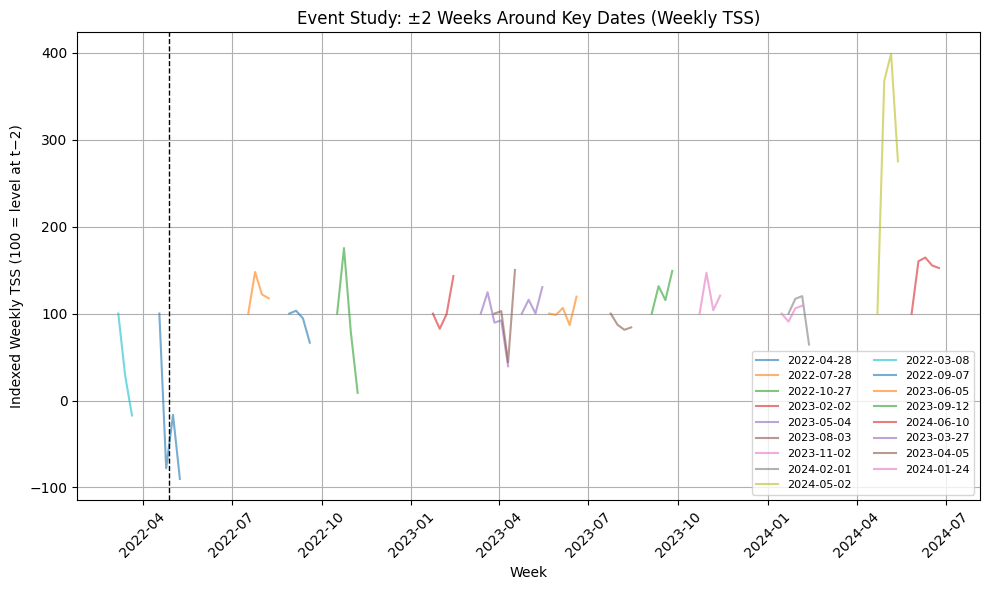

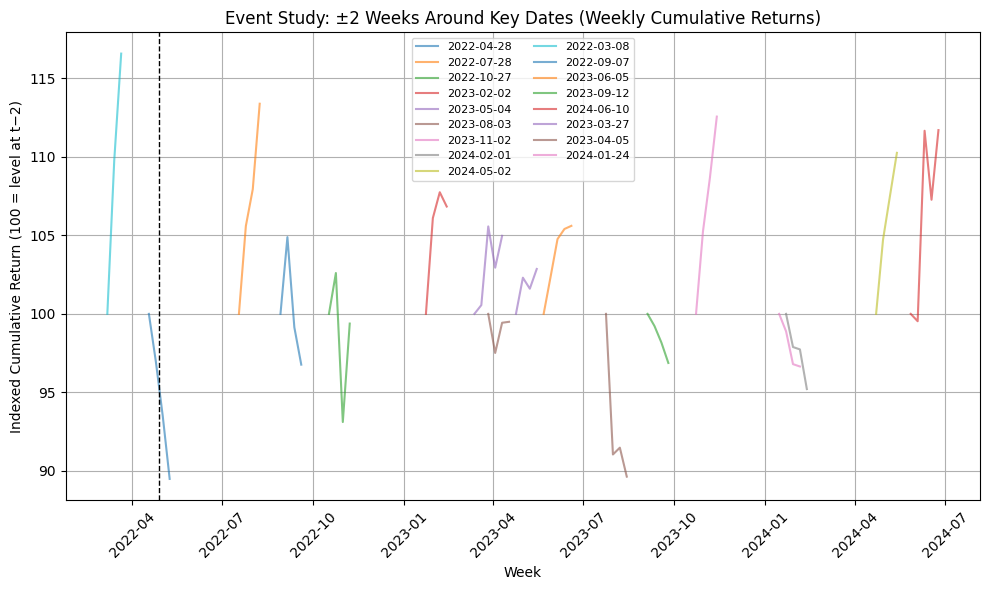

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Prepare weekly TSS from df_expl ---
df_expl["time_published"] = pd.to_datetime(df_expl["time_published"])
df_expl["week"] = (
    df_expl["time_published"]
    .dt.to_period("W")
    .apply(lambda r: r.start_time.date())
)

weekly_sent = (
    df_expl
    .groupby("week")["ticker_sentiment_score"]
    .mean()
    .reset_index()
    .rename(columns={"ticker_sentiment_score": "weekly_tss"})
)

# --- 2) Prepare weekly returns by resampling your daily CSV ---
daily_path = r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\data\extract\stocks\AAPL\prices\AAPL_daily_adjusted.csv"
df_daily = pd.read_csv(daily_path, parse_dates=["date"])
adj_col = [c for c in df_daily.columns if "adjusted close" in c.lower()][0]
df_daily = df_daily[["date", adj_col]].rename(columns={adj_col: "adjusted_close"})
df_daily = df_daily.set_index("date").sort_index()

df_weekly = (
    df_daily["adjusted_close"]
    .resample("W-MON")
    .last()
    .pct_change()
    .shift(-1)
    .reset_index()
    .rename(columns={"adjusted_close": "return_w+1"})
)
weekly_returns_df = df_weekly.copy()
weekly_returns_df["week"] = weekly_returns_df["date"].dt.date
weekly_returns_df = weekly_returns_df[["week", "return_w+1"]]

# --- 3) Merge sentiment + returns ---
weekly = pd.merge(weekly_sent,
                  weekly_returns_df,
                  on="week",
                  how="inner")

# --- 4) Define key event dates ---
events = [
    "2022-04-28","2022-07-28","2022-10-27","2023-02-02",
    "2023-05-04","2023-08-03","2023-11-02","2024-02-01",
    "2024-05-02","2022-03-08","2022-09-07","2023-06-05",
    "2023-09-12","2024-06-10","2023-03-27","2023-04-05",
    "2024-01-24"
]
events = pd.to_datetime(events).date

# --- 5) Event Study: Weekly TSS ---
plt.figure(figsize=(10, 6))
for ev in events:
    window = pd.date_range(ev - pd.Timedelta(weeks=2),
                           ev + pd.Timedelta(weeks=2),
                           freq="W-MON").date
    sub = weekly[weekly["week"].isin(window)].copy()
    if sub.empty:
        continue
    base = sub["weekly_tss"].iloc[0]
    sub["indexed_tss"] = sub["weekly_tss"] / base * 100
    plt.plot(sub["week"],
             sub["indexed_tss"],
             alpha=0.6,
             label=ev.strftime("%Y-%m-%d"))
plt.axvline(x=events[0], color="k", linestyle="--", linewidth=1)
plt.title("Event Study: ±2 Weeks Around Key Dates (Weekly TSS)")
plt.xlabel("Week")
plt.ylabel("Indexed Weekly TSS (100 = level at t−2)")
plt.xticks(rotation=45)
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 6) Event Study: Weekly Cumulative Returns ---
plt.figure(figsize=(10, 6))
for ev in events:
    window = pd.date_range(ev - pd.Timedelta(weeks=2),
                           ev + pd.Timedelta(weeks=2),
                           freq="W-MON").date
    sub = weekly[weekly["week"].isin(window)].copy()
    if sub.empty:
        continue
    # cumulative return factor
    cum = (1 + sub["return_w+1"]).cumprod()
    sub["indexed_ret"] = cum / cum.iloc[0] * 100
    plt.plot(sub["week"],
             sub["indexed_ret"],
             alpha=0.6,
             label=ev.strftime("%Y-%m-%d"))
plt.axvline(x=events[0], color="k", linestyle="--", linewidth=1)
plt.title("Event Study: ±2 Weeks Around Key Dates (Weekly Cumulative Returns)")
plt.xlabel("Week")
plt.ylabel("Indexed Cumulative Return (100 = level at t−2)")
plt.xticks(rotation=45)
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


## Interpretation

### Weekly TSS Event Study
- **High signal volatility**  
  Many series spike well above 100 (surges in coverage) or even dip below zero when TSS at t−2 was near zero.  
- **No consistent pattern**  
  There isn’t a uniform “spike” at t = 0. Some events show pre-event increases, others immediate drops.  
- **Noise from low news volume**  
  Weeks with very few articles yield unstable means, and indexing to 100 amplifies those swings.

### Weekly Cumulative Returns Event Study
- **Heterogeneous reactions**  
  Some events lead to clear post-event price gains, others to declines.  
- **Smoother than TSS**  
  Cumulative returns are inherently less erratic than an indexed sentiment series.


## Stationarity & Validity

- **Returns** (`return_w+1`): by construction, financial returns are approximately stationary, as they remove price trends.  
- **Indexed TSS**:  
  – Not strictly stationary—this is a relative-level series rather than differences or log-differences.  
  – Normalizing at t−2 and applying smoothing helps reduce background trends but doesn’t guarantee strict stationarity (e.g., via unit-root tests).  
- **Does it make sense?**  
  – **Yes**, since an Event Study aims to reveal **short-term anomalies** around key dates.  
  – For more robustness, consider:  
    1. **Filtering** weeks with at least X articles to avoid unstable averages.  
    2. Applying **rolling-mean smoothing** or taking **differences** of TSS to approach stationarity.  
    3. Computing the **average event response** with ±1 σ confidence bands instead of plotting every single event.

With these enhancements, you’ll obtain clearer signals and a more reliable comparison of sentiment vs. price reactions around each event type.  

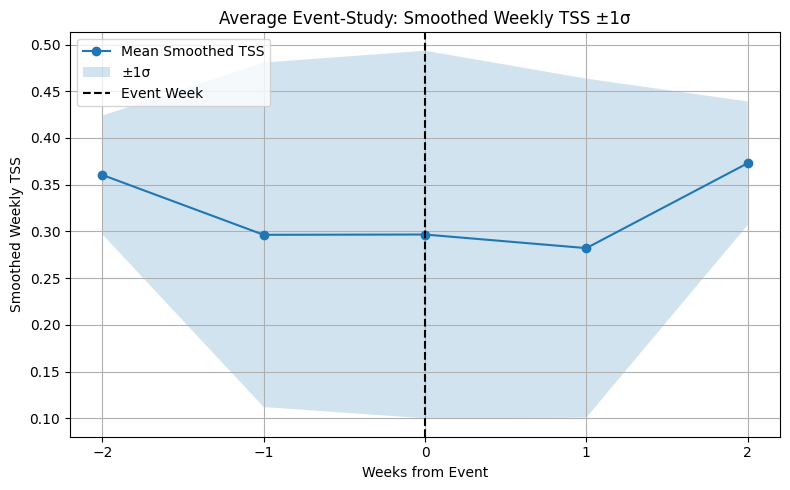

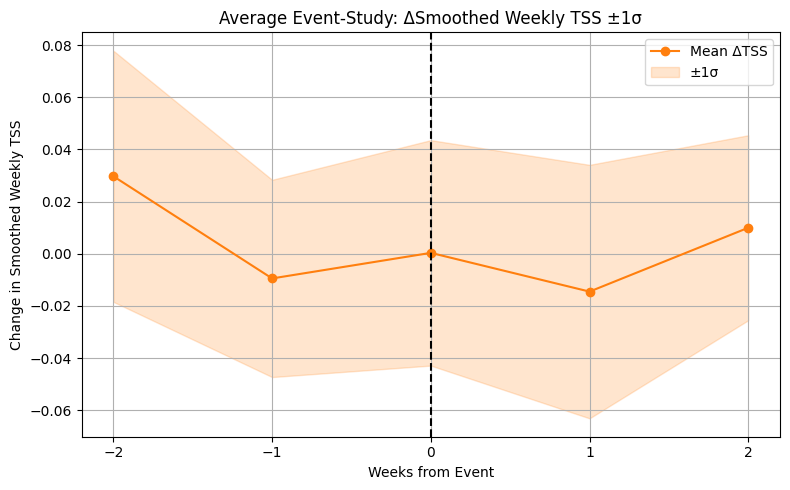

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- PARAMETERS ---
MIN_ARTICLES_PER_WEEK = 3   # minimum number of news items per week
ROLL_WINDOW           = 3   # smoothing window for TSS
PRE_WEEKS             = 2   # weeks before event
POST_WEEKS            = 2   # weeks after event

# --- 1) Define your key event dates ---
events = [
    "2022-04-28","2022-07-28","2022-10-27","2023-02-02",
    "2023-05-04","2023-08-03","2023-11-02","2024-02-01",
    "2024-05-02","2022-03-08","2022-09-07","2023-06-05",
    "2023-09-12","2024-06-10","2023-03-27","2023-04-05",
    "2024-01-24"
]
events = pd.to_datetime(events).date

# --- 2) Build weekly sentiment + count from df_expl ---
df_expl["time_published"] = pd.to_datetime(df_expl["time_published"])
df_expl["week"] = (
    df_expl["time_published"]
    .dt.to_period("W")
    .apply(lambda r: r.start_time.date())
)

weekly = (
    df_expl
    .groupby("week")
    .agg(
        weekly_tss  = ("ticker_sentiment_score", "mean"),
        news_count  = ("ticker_sentiment_score", "size")
    )
    .reset_index()
)

# Filter out sparse weeks
weekly = weekly[weekly["news_count"] >= MIN_ARTICLES_PER_WEEK]

# Smooth TSS
weekly["smoothed_tss"] = (
    weekly["weekly_tss"]
    .rolling(window=ROLL_WINDOW, center=True, min_periods=1)
    .mean()
)

# Optional: take first differences to approach stationarity
weekly["delta_tss"] = weekly["smoothed_tss"].diff()

# --- 3) Align each event to a relative-week index ---
records = []
for ev in events:
    window = pd.date_range(start=ev - pd.Timedelta(weeks=PRE_WEEKS),
                           end  =ev + pd.Timedelta(weeks=POST_WEEKS),
                           freq ="W-MON").date
    sub = weekly[weekly["week"].isin(window)].copy()
    if sub.empty:
        continue

    # compute relative week: -PRE_WEEKS ... +POST_WEEKS
    sub["rel_week"] = (
        (pd.to_datetime(sub["week"]) - (pd.to_datetime(ev) - pd.Timedelta(weeks=PRE_WEEKS)))
        .dt.days // 7 - PRE_WEEKS
    )
    sub["event"] = ev.strftime("%Y-%m-%d")
    records.append(sub[["event", "rel_week", "smoothed_tss", "delta_tss"]])

aligned = pd.concat(records, ignore_index=True)

# --- 4) Compute average & ±1σ across events by relative week ---
agg = (
    aligned
    .groupby("rel_week")
    .agg(
        mean_tss = ("smoothed_tss", "mean"),
        std_tss  = ("smoothed_tss", "std"),
        mean_dtss= ("delta_tss", "mean"),
        std_dtss = ("delta_tss", "std"),
        count    = ("smoothed_tss", "count")
    )
    .reset_index()
)

# --- 5) Plot average event response (smoothed TSS) ---
plt.figure(figsize=(8,5))
x = agg["rel_week"]
y = agg["mean_tss"]
s = agg["std_tss"].fillna(0)

plt.plot(x, y, marker="o", label="Mean Smoothed TSS")
plt.fill_between(x, y - s, y + s, alpha=0.2, label="±1σ")

plt.axvline(0, color="k", linestyle="--", label="Event Week")
plt.xticks(range(-PRE_WEEKS, POST_WEEKS+1))
plt.xlabel("Weeks from Event")
plt.ylabel("Smoothed Weekly TSS")
plt.title("Average Event-Study: Smoothed Weekly TSS ±1σ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 6) Plot average delta TSS if desired ---
plt.figure(figsize=(8,5))
y2 = agg["mean_dtss"]
s2 = agg["std_dtss"].fillna(0)

plt.plot(x, y2, marker="o", color="C1", label="Mean ΔTSS")
plt.fill_between(x, y2 - s2, y2 + s2, alpha=0.2, color="C1", label="±1σ")

plt.axvline(0, color="k", linestyle="--")
plt.xticks(range(-PRE_WEEKS, POST_WEEKS+1))
plt.xlabel("Weeks from Event")
plt.ylabel("Change in Smoothed Weekly TSS")
plt.title("Average Event-Study: ΔSmoothed Weekly TSS ±1σ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔍 Interpretation of the Average Event-Study Plots

### 1. Smoothed Weekly TSS (±1σ)

- **t − 2 to t − 1:**  
  The mean smoothed TSS **drops** from ~0.36 at two weeks before to ~0.30 one week before the event.  
- **t − 1 to t 0:**  
  It is roughly flat (≈0.30) in the event week itself.  
- **t 0 to t + 1:**  
  A small further dip to ~0.28 one week after the event.  
- **t + 1 to t + 2:**  
  A **rebound** back up to ~0.37 two weeks post‐event.

The shaded band (±1 σ) is very wide, indicating **high variability** across different events.  

### 2. ΔSmoothed Weekly TSS (±1σ)

- **t − 2 to t − 1:**  
  The average weekly change in TSS is **−0.01**, i.e. a modest decline leading into the event.  
- **t − 1 to t 0:**  
  It hovers around zero, suggesting sentiment stabilizes in the event week itself.  
- **t 0 to t + 1:**  
  Another slight negative change (≈−0.015) immediately post‐event.  
- **t + 1 to t + 2:**  
  A modest positive uptick (+0.01), consistent with the rebound seen in the level plot.

Again, the ±1 σ envelope is large, so these mean moves are quite noisy.

## Does this make sense?

- **General pattern:**  
  A tendency for TSS to **dip** just before or during the event, then **recover** after—plausible if markets “wait” on news and then react afterward.

- **High noise**  
  The very wide confidence bands tell us that **not all events** share the same pattern. Some events spike sentiment, others depress it.

## Possible Enhancements

1. **Event‐Type Breakdown**  
   Plot earnings vs launches separately to see if one category drives the average more strongly.

2. **Statistical Significance**  
   Add simple t-intervals or bootstrap‐based confidence bands to assess whether the mean deviations at t ± 1 are statistically different from zero.

3. **Longer Pre/Post Window**  
   Extend to ±3 or ±4 weeks to capture slower‐moving sentiment build-up or fade.

4. **Baseline Correction**  
   Instead of indexing to raw level at t − 2, subtract the 2–3 week trailing average to isolate the “abnormal” component.

5. **Minimum Article Threshold**  
   Increase the `MIN_ARTICLES_PER_WEEK` filter to ensure each week’s mean is based on a stable sample.

With these tweaks, you’ll gain a clearer, more statistically robust view of how sentiment truly behaves around your key dates.  


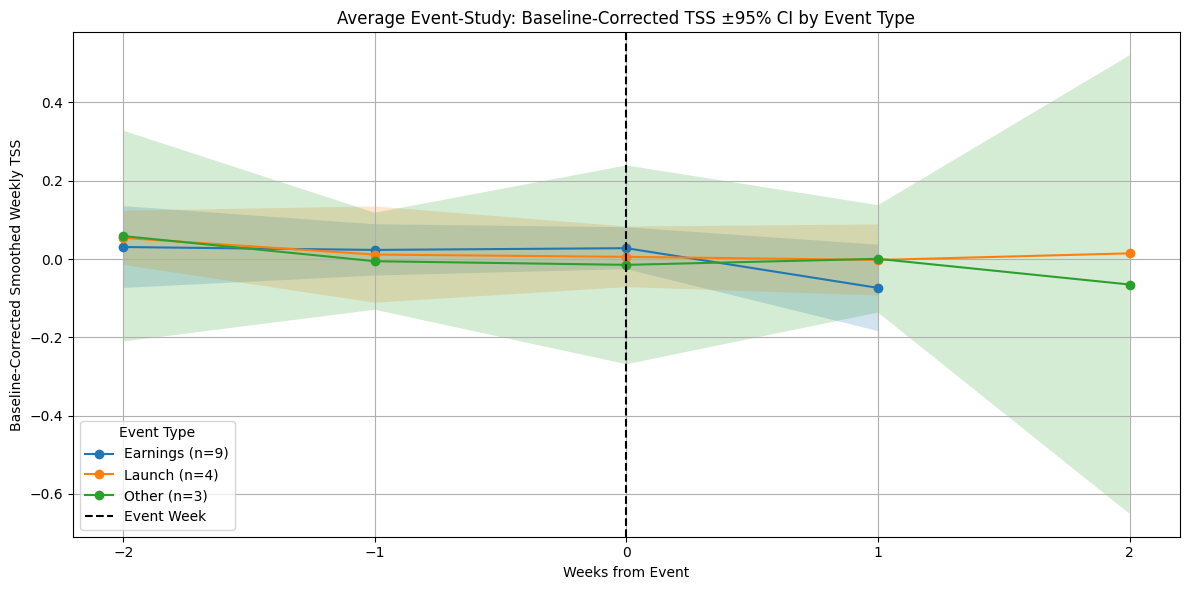

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# ── PARAMETERS ───────────────────────────────────────────────────────────────
MIN_ARTICLES_PER_WEEK = 5    # Lowered to keep more weeks
ROLL_WINDOW           = 2    # Smoothing window
PRE_WEEKS             = 2    # Expanded window
POST_WEEKS            = 2

# ── EVENT LIST (date, ticker, label) ─────────────────────────────────────────
events = [
    # Earnings
    ("2022-04-28","AAPL","Q2 2022 Earnings"),
    ("2022-07-28","AAPL","Q3 2022 Earnings"),
    ("2022-10-27","AAPL","Q4 2022 Earnings"),
    ("2023-02-02","AAPL","Q1 2023 Earnings"),
    ("2023-05-04","AAPL","Q2 2023 Earnings"),
    ("2023-08-03","AAPL","Q3 2023 Earnings"),
    ("2023-11-02","AAPL","Q4 2023 Earnings"),
    ("2024-02-01","AAPL","Q1 2024 Earnings"),
    ("2024-05-02","AAPL","Q2 2024 Earnings"),

    # Launches
    ("2022-03-08","AAPL","iPhone SE 3rd Gen Launch"),
    ("2022-09-07","AAPL","iPhone 14 Launch"),
    ("2023-06-05","AAPL","WWDC 2023 Launch"),
    ("2023-09-12","AAPL","iPhone 15 Launch"),
    ("2024-06-10","AAPL","WWDC 2024 Expected"),

    # Other
    ("2023-03-27","AAPL","BNPL in US"),
    ("2023-04-05","AAPL","WaveOne Acquisition"),
    ("2024-01-24","AAPL","M3 MacBook Air Launch"),
]
events_df = pd.DataFrame(events, columns=["date","ticker","label"])
events_df["date"] = pd.to_datetime(events_df["date"]).dt.date
events_df["type"] = events_df["label"].apply(
    lambda x: "Earnings" if "Earnings" in x else 
              "Launch"   if "Launch"   in x else 
              "Other"
)

# ── 1) WEEKLY AGGREGATION & SMOOTHING ────────────────────────────────────────
# df_expl must already be loaded in your session
df_expl["time_published"] = pd.to_datetime(df_expl["time_published"])
df_expl["week"] = (
    df_expl["time_published"]
    .dt.to_period("W")
    .apply(lambda r: r.start_time.date())
)

weekly = (
    df_expl
    .groupby("week")["ticker_sentiment_score"]
    .agg(weekly_tss="mean", news_count="size")
    .reset_index()
)

# Filter by min articles/week
weekly = weekly[weekly["news_count"] >= MIN_ARTICLES_PER_WEEK]

# Smooth via rolling mean
weekly["smoothed_tss"] = (
    weekly["weekly_tss"]
    .rolling(window=ROLL_WINDOW, center=True, min_periods=1)
    .mean()
)

# Baseline‐correct: subtract prior 3-week average (t−PRE_WEEKS … t−1)
weekly["baseline"] = (
    weekly["smoothed_tss"]
    .shift(1)
    .rolling(window=PRE_WEEKS, min_periods=1)
    .mean()
)
weekly["tss_corrected"] = weekly["smoothed_tss"] - weekly["baseline"]

# ── 2) ALIGN EVENTS INTO RELATIVE WEEKS ──────────────────────────────────────
records = []
for _, ev in events_df.iterrows():
    ev_date = ev["date"]
    window = pd.date_range(
        start = ev_date - pd.Timedelta(weeks=PRE_WEEKS),
        end   = ev_date + pd.Timedelta(weeks=POST_WEEKS),
        freq  = "W-MON"
    ).date

    sub = weekly[weekly["week"].isin(window)].copy()
    if sub.empty: 
        continue

    sub["rel_week"] = (
        pd.to_datetime(sub["week"]) 
        - (pd.to_datetime(ev_date) - pd.Timedelta(weeks=PRE_WEEKS))
    ).dt.days // 7 - PRE_WEEKS

    sub["event"] = ev["label"]
    sub["type"]  = ev["type"]
    records.append(sub[["event","type","rel_week","tss_corrected"]])

aligned = pd.concat(records, ignore_index=True)

# ── 3) AGGREGATE MEAN ±95% CI BY TYPE AND REL_WEEK ──────────────────────────
agg = (
    aligned
    .groupby(["type","rel_week"])["tss_corrected"]
    .agg(mean="mean", std="std", count="count")
    .reset_index()
)

# Standard error and t-based CI
agg["sem"] = agg["std"] / np.sqrt(agg["count"])
tval = stats.t.ppf(0.975, agg["count"] - 1)
agg["ci_lower"] = agg["mean"] - tval * agg["sem"]
agg["ci_upper"] = agg["mean"] + tval * agg["sem"]

# ── 4) PLOT BY EVENT TYPE ───────────────────────────────────────────────────
plt.figure(figsize=(12, 6))
for ev_type, grp in agg.groupby("type"):
    grp = grp.sort_values("rel_week")
    plt.plot(grp["rel_week"], grp["mean"], marker="o",
             label=f"{ev_type} (n={int(grp['count'].max())})")
    plt.fill_between(grp["rel_week"], grp["ci_lower"], grp["ci_upper"], alpha=0.2)

plt.axvline(0, color="k", linestyle="--", label="Event Week")
plt.xticks(range(-PRE_WEEKS, POST_WEEKS + 1))
plt.xlabel("Weeks from Event")
plt.ylabel("Baseline-Corrected Smoothed Weekly TSS")
plt.title("Average Event-Study: Baseline-Corrected TSS ±95% CI by Event Type")
plt.legend(title="Event Type")
plt.grid(True)
plt.tight_layout()
plt.show()


---

# LLM Response modelling for TSS, TRS & TPI

## Load and Process Financial News & Prices Dynamically for Any Ticker

This script allows you to dynamically load sentiment-scored financial news and merge it with daily price data for any given stock ticker (e.g., "AAPL", "MSFT", etc.). It filters for high-impact news based on relevance and sentiment thresholds, and aligns the data by date to enable event-based analysis.

In [156]:
# 📦 Load and process sentiment + price data for any ticker (all-in-one cell)

import os
import ast
import pandas as pd

# Define base paths
BASE_PATH = r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub"
PRICE_DIR = os.path.join(BASE_PATH, "data", "extract", "stocks")
NEWS_DIR  = os.path.join(BASE_PATH, "data", "extract", "news") # where your *_news_*.csv files are stored

def prepare_sentiment_df(ticker: str) -> pd.DataFrame:
    """
    Loads financial news and price data for a given ticker,
    filters by sentiment and relevance thresholds,
    and merges it with daily adjusted prices.

    Parameters:
    -----------
    ticker : str
        Stock ticker symbol (e.g., 'AAPL', 'MSFT')

    Returns:
    --------
    pd.DataFrame
        A DataFrame containing aligned sentiment and price data
    """
    # Load prices
    def load_prices(ticker: str, price_dir: str) -> pd.DataFrame:
        path = os.path.join(price_dir, ticker, "prices", f"{ticker}_daily_adjusted.csv")
        dfp = pd.read_csv(path, parse_dates=["date"])
        column_mapping = {
            "1. open": "price_open",
            "2. high": "price_high",
            "3. low": "price_low",
            "4. close": "price_close",
            "5. adjusted close": "adjusted_close",
            "6. volume": "volume"
        }
        dfp.rename(columns=column_mapping, inplace=True)
        dfp = dfp.set_index("date").sort_index()
        dfp["daily_return"] = dfp["adjusted_close"].pct_change()
        dfp = dfp.reset_index()[[
            "date", "price_open", "price_high", "price_low", "price_close",
            "adjusted_close", "volume", "daily_return"
        ]]
        return dfp

    # Extract relevant sentiment info for a specific ticker
    def explode_with_text(df: pd.DataFrame, ticker: str) -> pd.DataFrame:
        rows = []
        for _, r in df.iterrows():
            for sent in r['ticker_sentiment']:
                if sent['ticker'] == ticker:
                    rows.append({
                        "time_published": r["time_published"],
                        "ticker_sentiment_score": float(sent["ticker_sentiment_score"]),
                        "ticker_relevance_score": float(sent["relevance_score"]),
                        "title": r.get("title", ""),
                        "summary": r.get("summary", "")
                    })
        return pd.DataFrame(rows)

    # Load and process news CSV
    news_csv = os.path.join(NEWS_DIR, f"{ticker}_news_2022-01-01_to_2025-05-01.csv")
    df_news = pd.read_csv(news_csv, sep=";", quotechar='"', parse_dates=["time_published"])
    df_news['ticker_sentiment'] = df_news['ticker_sentiment'].apply(
        lambda x: ast.literal_eval(x) if pd.notnull(x) and x != '' else []
    )

    # Explode and filter
    df_expl = explode_with_text(df_news, ticker)
    if 1 == 1:
        df_expl = df_expl[
            (
                (df_expl['ticker_sentiment_score'] >= 0.3) |
                (df_expl['ticker_sentiment_score'] <= -0.3)
            ) &
            (df_expl['ticker_relevance_score'] >= 0.5)
        ].copy()

        # Merge with prices
        df_price = load_prices(ticker, PRICE_DIR)
        df_expl["date"] = df_expl["time_published"].dt.floor("D")
        df_expl = df_expl.merge(df_price, on="date", how="left").drop(columns=["date"])
        df_expl["idx"] = range(1, len(df_expl) + 1)
        df_expl["time_published"] = pd.to_datetime(df_expl["time_published"]).dt.date

    print(f"✅ Sentiment DataFrame for {ticker} ready: {df_expl.shape[0]} rows")
    return df_expl

In [157]:
# ▶️ Example use
df_expl = prepare_sentiment_df("AAPL")
df_expl.head()

# Show stats
lengths = df_expl['summary'].str.len()
stats = lengths.describe().to_frame(name='summary_len').T
stats

✅ Sentiment DataFrame for AAPL ready: 2445 rows


count       mean        std   min   25%    50%    75%    max
summary_len  2445.0  178.17955  89.145127  27.0  91.0  177.0  272.0  301.0

In [159]:
df_expl.head()

time_published  ticker_sentiment_score  ticker_relevance_score  \
0     2022-03-09                0.608306                0.515127   
1     2022-03-08                0.520191                0.621324   
2     2022-03-18                0.430615                0.779575   
3     2022-03-16                0.365825                0.975869   
4     2022-03-14               -0.662196                0.997247   

                                               title  \
0                    Apple Launches New 5G iPhone SE   
1         2 Top Tech Stocks to Buy for the Long Haul   
2                 Is It Too Late to Buy Apple Stock?   
3  Apple  ( AAPL )  Releases watchOS 8.5, Leads S...   
4  Buy This Software Firm's Stock. Apple Is at th...   

                                             summary  price_open  price_high  \
0  Apple  ( NASDAQ: AAPL ) , introduced several n...     161.475      163.41   
1  The power of compounding works better the more...     158.820      162.88   
2  Its market cap is reaching astronomical levels...     160.510      164.48   
3  Apple (AAPL) is leading the smartwatch market ...     157.050      160.00   
4  Buy Jamf Stock. Apple Is at the Core of the So...     151.450      154.12   

   price_low  price_close  adjusted_close       volume  daily_return  idx  
0     159.41       162.95      160.356910   91454905.0      0.034997    1  
1     155.80       157.44      154.934593  131148280.0     -0.011676    2  
2     159.76       163.98      161.370519  122055535.0      0.020919    3  
3     154.46       159.59      157.050379  102300157.0      0.029015    4  
4     150.10       150.62      148.223122  108732111.0     -0.026562    5

In [38]:
import pandas as pd
import json

# Cargar CSV
df_with_impact = pd.read_csv("df_with_impact.csv", index_col=0)

# Cargar JSON
with open("llm___results.json", "r") as f:
    llm_results = json.load(f)["results"]

# Convertir JSON a DataFrame
df_llm = pd.DataFrame(llm_results).set_index("idx")

# Reemplazar columnas en el DataFrame original donde coincida el idx
df_with_impact.update(df_llm)

# Guardar si lo necesitas
df_with_impact.to_csv("df_with_impact_actualizado.csv")


### **MODEL 1** - *News*

In [ ]:
import os
import math
import pandas as pd
import json
import openai
import time

# Configuración
openai.api_key = os.getenv("OPENAI_API_KEY")
output_path = "df__llm___full.csv"
BATCH_SIZE = 25
PROCESS_ALL = True  # Cambiar a True para procesar todo

# Data original
df_out = df_expl.copy()

# Si el archivo no existe, lo inicializamos con las columnas necesarias
if not os.path.exists(output_path):
    df_init = df_out[["idx"]].copy()
    df_init["ticker_sentiment_score"] = None
    df_init["ticker_relevance_score"] = None
    df_init["ticker_price_impact"] = None
    df_init.to_csv(output_path, index=False)
    print("🆕 Archivo de resultados inicializado.")
else:
    print("📁 Archivo existente detectado. Continuando…")

# Prompt completo con ejemplo
SYSTEM_PROMPT = """
You are a financial news analyst tasked with evaluating the tone, relevance, and potential market impact of news articles related to a specific company (stock ticker).

For each news item, you are given:
- Date of publication
- Title
- Summary

Your job is to estimate:

1. `ticker_sentiment_score` → What is the general tone of the article toward the company? Bullish = positive, Bearish = negative.
   - Range: -1.000 to +1.000
   - Round to 3 decimals.

2. `ticker_relevance_score` → How relevant is this news to the company’s stock or business fundamentals?
   - Range: 0.000 (not related) to 1.000 (directly related)
   - Round to 3 decimals.

3. `ticker_price_impact` → Based on the news, what **short-term price impact** would you expect for the stock?
   - Range: -1.000 (strong negative impact) to +1.000 (strong positive impact)
   - This should reflect how likely the news would influence investor behavior or move the stock price.
   - Consider macroeconomic context, earnings, product news, or market events.
   - Round to 3 decimals.

⚠️ Do not guess. If the news is ambiguous or not impactful, return values close to 0.000.
Avoid flat scores like 0.0, 1.0, or -1.0 unless the article is clearly neutral or extremely bullish/bearish.

Use decimal precision to show subtle differences, such as:
- Use 0.523 instead of 0.5
- Use -0.712 instead of -1.0
- Use 0.008 instead of 0.0

Return all numeric values rounded to **3 decimals**.

---

### Example

Input:
Date: 2023-10-27  
Title: Apple reports record quarterly earnings, surpassing expectations  
Summary: Apple posted Q4 earnings of $1.46 per share on $89.5B in revenue, beating analyst estimates. Strong iPhone 15 sales contributed significantly to the results.

Expected Output (JSON):
{
  "results": [
    {
      "idx": 1,
      "ticker_sentiment_score": 0.850,
      "ticker_relevance_score": 0.980,
      "ticker_price_impact": 0.720
    }
  ]
}

---

Now continue evaluating the following news items. Return only the JSON as shown above.
"""

FUNCTION_DEF = {
    "name": "evaluate_news",
    "description": "Evaluates news headlines for sentiment, relevance, and expected price impact",
    "parameters": {
        "type": "object",
        "properties": {
            "results": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "idx": {"type": "integer"},
                        "ticker_sentiment_score": {"type": "number"},
                        "ticker_relevance_score": {"type": "number"},
                        "ticker_price_impact": {"type": "number"}
                    },
                    "required": [
                        "idx", "ticker_sentiment_score",
                        "ticker_relevance_score", "ticker_price_impact"
                    ]
                }
            }
        },
        "required": ["results"]
    }
}

def process_batch(batch):
    lines = []
    for _, row in batch.iterrows():
        date = str(row["time_published"])
        title = row["title"].replace("\n", " ").strip()
        summary = row["summary"].replace("\n", " ").strip()[:200] + "…"
        lines.append(f"{row['idx']}|Date: {date} | Title: {title} | Summary: {summary}")
    user_content = "Evaluate the following news items considering the date and market context:\n" + "\n".join(lines)

    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": user_content}
            ],
            functions=[FUNCTION_DEF],
            function_call={"name": "evaluate_news"},
            temperature=0.2,
            max_tokens=1000
        )

        msg = response.choices[0].message

        if msg.get("function_call"):
            args = msg.function_call.arguments
            return json.loads(args)["results"]
        else:
            print("⚠️ La respuesta no incluyó 'function_call'. Aquí va el contenido:")
            print(msg)
            return []

    except Exception as e:
        print("❌ Error en la llamada a OpenAI:", e)
        return []
    
def round_to_0_05(x):
    return round(x * 20) / 20  # ya que 1 / 0.05 = 20


# Cargamos CSV parcial y detectamos qué filas faltan
df_results = pd.read_csv(output_path)
processed_idxs = set(df_results.dropna(subset=["ticker_sentiment_score"]).idx)
remaining = df_out[~df_out["idx"].isin(processed_idxs)].copy()
print(f"✅ Total procesadas: {len(processed_idxs)} / {len(df_out)}")

# Ejecutar por lotes
total_batches = math.ceil(len(remaining) / BATCH_SIZE)
if not PROCESS_ALL:
    total_batches = 1  # Solo el primer batch

for k in range(total_batches):
    start = k * BATCH_SIZE
    end = min(start + BATCH_SIZE, len(remaining))
    batch = remaining.iloc[start:end]
    print(f"🧪 Procesando batch {k+1}/{total_batches} — filas {start} a {end-1}...")

    try:
        batch_results = process_batch(batch)
        if not batch_results:
            raise ValueError("No results returned")
        
        if batch_results and isinstance(batch_results, list) and "idx" in batch_results[0]:
            df_batch_results = pd.DataFrame(batch_results)

            for col in ["ticker_sentiment_score", "ticker_relevance_score", "ticker_price_impact"]:
                df_batch_results[col] = df_batch_results[col].apply(round_to_0_05)

            if "idx" not in df_batch_results.columns:
                raise ValueError("❌ 'idx' missing in model response.")

            df_results = df_results.set_index("idx")
            df_batch_results = df_batch_results.set_index("idx")

            df_results.update(df_batch_results)
            df_results = df_results.reset_index()
            df_results.to_csv(output_path, index=False)

            print(f"✅ Batch {k+1} guardado correctamente.\n")
            print(df_batch_results.head())
            time.sleep(3)  # Pausa entre batches para evitar límite de OpenAI
        else:
            raise ValueError("❌ Batch response is empty or invalid.")

        print(f"✅ Batch {k+1} guardado correctamente.\n")
        print(df_batch_results.head())

    except Exception as e:
        print(f"⚠️ Error en batch {k+1}: {e}")


### **MODEL 2** - *News + Tech*

In [ ]:
import os
import math
import pandas as pd
import json
import openai
import time

# Configuración
openai.api_key = os.getenv("OPENAI_API_KEY")
output_path = "df___llm___full___with_technicals.csv"
BATCH_SIZE = 25
PROCESS_ALL = True  # Cambiar a True para procesar todo

# Data original
df_out = df_expl.copy()

# Si el archivo no existe, lo inicializamos con las columnas necesarias
if not os.path.exists(output_path):
    df_init = df_out[["idx"]].copy()
    df_init["ticker_sentiment_score"] = None
    df_init["ticker_relevance_score"] = None
    df_init["ticker_price_impact"] = None
    df_init.to_csv(output_path, index=False)
    print("🆕 Archivo de resultados inicializado.")
else:
    print("📁 Archivo existente detectado. Continuando…")

# Prompt extendido incluyendo datos técnicos
SYSTEM_PROMPT = """
You are a financial news analyst tasked with evaluating the tone, relevance, and potential market impact of news articles related to a specific company (stock ticker).

For each news item, you are given:
- Date of publication
- Title
- Summary
- Market context for that day:
  - Open, High, Low, Close, Adjusted Close prices
  - Volume traded
  - Daily return (percentage change)

Your job is to estimate:

1. `ticker_sentiment_score` → What is the general tone of the article toward the company? Bullish = positive, Bearish = negative.
   - Range: -1.000 to +1.000

2. `ticker_relevance_score` → How relevant is this news to the company’s stock or business fundamentals?
   - Range: 0.000 (not related) to 1.000 (directly related)

3. `ticker_price_impact` → Based on the news and technical context, what **short-term price impact** would you expect?
   - Range: -1.000 (strong negative) to +1.000 (strong positive)
   - Consider if the price already reacted or if the volume suggests anticipation.

⚠️ Be cautious: If the news is ambiguous or market data shows no reaction, keep scores close to 0.000.

Return all numeric values rounded to 3 decimals.

---

### Example

Input:
Date: 2023-10-27  
Title: Apple reports record quarterly earnings, surpassing expectations  
Summary: Apple posted Q4 earnings of $1.46 per share on $89.5B in revenue, beating analyst estimates. Strong iPhone 15 sales contributed significantly to the results.  
Market: open=171.1, high=175.3, low=170.0, close=174.5, adjusted_close=174.5, volume=98000000, return=+2.7%

Expected Output:
{
  "results": [
    {
      "idx": 1,
      "ticker_sentiment_score": 0.850,
      "ticker_relevance_score": 0.980,
      "ticker_price_impact": 0.720
    }
  ]
}

---

Now continue evaluating the following news items. Return only the JSON.
"""

FUNCTION_DEF = {
    "name": "evaluate_news",
    "description": "Evaluates news headlines with technical market context",
    "parameters": {
        "type": "object",
        "properties": {
            "results": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "idx": {"type": "integer"},
                        "ticker_sentiment_score": {"type": "number"},
                        "ticker_relevance_score": {"type": "number"},
                        "ticker_price_impact": {"type": "number"}
                    },
                    "required": [
                        "idx", "ticker_sentiment_score",
                        "ticker_relevance_score", "ticker_price_impact"
                    ]
                }
            }
        },
        "required": ["results"]
    }
}

def process_batch(batch):
    lines = []
    for _, row in batch.iterrows():
        date = str(row["time_published"])
        title = row["title"].replace("\n", " ").strip()
        summary = row["summary"].replace("\n", " ").strip()[:200] + "…"
        market = (
            f"open={row['price_open']}, high={row['price_high']}, low={row['price_low']}, "
            f"close={row['price_close']}, adjusted_close={row['adjusted_close']}, "
            f"volume={row['volume']}, return={row['daily_return']:+.2%}"
        )
        lines.append(f"{row['idx']}|Date: {date} | Title: {title} | Summary: {summary} | Market: {market}")

    user_content = "Evaluate the following news items with their technical context:\n" + "\n".join(lines)

    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": user_content}
            ],
            functions=[FUNCTION_DEF],
            function_call={"name": "evaluate_news"},
            temperature=0.2,
            max_tokens=1000
        )

        msg = response.choices[0].message
        if msg.get("function_call"):
            args = msg.function_call.arguments
            return json.loads(args)["results"]
        else:
            print("⚠️ No se devolvió function_call")
            print(msg)
            return []

    except Exception as e:
        print("❌ Error en la llamada a OpenAI:", e)
        return []

# Cargamos CSV parcial y detectamos qué filas faltan
df_results = pd.read_csv(output_path)
processed_idxs = set(df_results.dropna(subset=["ticker_sentiment_score"]).idx)
remaining = df_out[~df_out["idx"].isin(processed_idxs)].copy()
print(f"✅ Total procesadas: {len(processed_idxs)} / {len(df_out)}")

# Ejecutar por lotes
total_batches = math.ceil(len(remaining) / BATCH_SIZE)
if not PROCESS_ALL:
    total_batches = 1  # Solo el primer batch

for k in range(total_batches):
    start = k * BATCH_SIZE
    end = min(start + BATCH_SIZE, len(remaining))
    batch = remaining.iloc[start:end]
    print(f"🧪 Procesando batch {k+1}/{total_batches} — filas {start} a {end-1}...")

    try:
        batch_results = process_batch(batch)
        if not batch_results:
            raise ValueError("No results returned")
        
        if batch_results and isinstance(batch_results, list) and "idx" in batch_results[0]:
            df_batch_results = pd.DataFrame(batch_results)

            for col in ["ticker_sentiment_score", "ticker_relevance_score", "ticker_price_impact"]:
                df_batch_results[col] = df_batch_results[col].apply(round_to_0_05)

            if "idx" not in df_batch_results.columns:
                raise ValueError("❌ 'idx' missing in model response.")

            df_results = df_results.set_index("idx")
            df_batch_results = df_batch_results.set_index("idx")

            df_results.update(df_batch_results)
            df_results = df_results.reset_index()
            df_results.to_csv(output_path, index=False)

            print(f"✅ Batch {k+1} guardado correctamente.\n")
            print(df_batch_results.head())
            time.sleep(3)  # Pausa entre batches para evitar límite de OpenAI
        else:
            raise ValueError("❌ Batch response is empty or invalid.")

        print(f"✅ Batch {k+1} guardado correctamente.\n")
        print(df_batch_results.head())

    except Exception as e:
        print(f"⚠️ Error en batch {k+1}: {e}")

### **MODEL 3** - *News + Tech + Fund*

In [ ]:
import os
import math
import time
import json
import pandas as pd
import openai

# Configuración
openai.api_key = os.getenv("OPENAI_API_KEY")
output_path = "df___llm___full___expl_tech_fund.csv"
BATCH_SIZE = 15
PROCESS_ALL = True  # Cambia a True para procesar todo

df_out = df_merged[[
    "idx", "time_published", "title", "summary",
    "price_open", "price_high", "price_low", "price_close",
    "adjusted_close_x", "volume", "daily_return",
    "gross_margin", "net_profit_margin", "return_on_equity",
    "debt_to_equity", "free_cash_flow", "eps"
]].copy()


# Crear archivo si no existe
if not os.path.exists(output_path):
    df_init = df_out[["idx"]].copy()
    df_init["ticker_sentiment_score"] = None
    df_init["ticker_relevance_score"] = None
    df_init["ticker_price_impact"] = None
    df_init["fundamental_score"] = None
    df_init["valuation_label"] = None
    df_init.to_csv(output_path, index=False)
    print("🆕 Archivo de resultados inicializado.")
else:
    print("📁 Archivo existente detectado. Continuando…")

SYSTEM_PROMPT = """
You are a senior financial analyst and LLM assistant responsible for analyzing financial news about companies. You receive:

1. News:
   - `date`, `title`, `summary`

2. Technical market context:
   - `open`, `high`, `low`, `close`, `adjusted_close`, `volume`, `daily_return`

3. Core financial fundamentals (6 most relevant):
   - `gross_margin`, `net_profit_margin`, `return_on_equity`, `debt_to_equity`, `free_cash_flow`, `eps`

Your job is to estimate for **each item**:

1. `ticker_sentiment_score` → What is the general tone of the article toward the company? Bullish = positive, Bearish = negative.
   - Range: -1.000 to +1.000

2. `ticker_relevance_score` → How relevant is this news to the company’s stock or business fundamentals?
   - Range: 0.000 (not related) to 1.000 (directly related)

3. `ticker_price_impact` → Based on the news, technical and fundamental context, what **short-term price impact** would you expect?
   - Range: -1.000 (strong negative) to +1.000 (strong positive)
   - Consider if the price already reacted or if the volume suggests anticipation.

4. `fundamental_score` → Purely from fundamentals, how strong is the company's financial health?
   - Range: 0.000 (very weak) to 1.000 (excellent)
   - Consider margins, cash flow, returns, solvency, and liquidity

5. `valuation_label` → Given the valuation ratios and EPS vs price:
   - Choose one of:
     - "undervalued"
     - "slightly undervalued"
     - "correctly valued"
     - "slightly overvalued"
     - "overvalued"
   - If PER is high but justified by ROE or growth, use "correctly valued"
   - If PB > 8 and ROE < 10%, suggest "overvalued"
   - If PS < 2 and margins are high, suggest "undervalued"

⚠️ Guidelines:

- Be cautious: If the news is ambiguous or market data shows no reaction, keep scores close to 0.000.

- Do **not** ignore strong fundamentals.  
  If a company shows excellent profitability, high ROE, and solid cash flow, but is trading at low multiples or depressed prices, it **must** be reflected as “undervalued” or “slightly undervalued”. These strong financial signals **cannot be overlooked**.

- Similarly, if a company is trading at very high PER or PB ratios but its profitability or ROE is weak, it should be labeled as “overvalued”.

- If news is neutral or market reaction is flat, the impact should be close to 0.000.

- Round all numeric values to 3 decimal places.

---

### Example Input:

**News:**
- `date`: 2024-01-25  
- `title`: Apple Surpasses Q1 Expectations with Strong iPhone Sales  
- `summary`: Apple reported earnings of $2.10 per share, beating expectations. Revenue reached $117B, driven by stronger-than-expected iPhone 15 sales.

**Market:**
- `open`: 177.10, `high`: 180.50, `low`: 176.20, `close`: 179.90, `adjusted_close`: 179.90  
- `volume`: 105000000  
- `daily_return`: +2.4%

**Fundamentals:**
- `gross_margin`: 0.44  
- `net_profit_margin`: 0.23  
- `return_on_equity`: 1.52  
- `debt_to_equity`: 1.10  
- `free_cash_flow`: 21800000000  
- `eps`: 2.10  

---

### Example Output (JSON format):

```json
{
  "results": [
    {
      "idx": 42,
      "ticker_sentiment_score": 0.85,
      "ticker_relevance_score": 0.95,
      "ticker_price_impact": 0.75,
      "fundamental_score": 0.90,
      "valuation_label": "slightly undervalued"
    }
  ]
}
"""

FUNCTION_DEF = {
    "name": "evaluate_news",
    "description": "Evaluates news headlines with reduced fundamental and technical context",
    "parameters": {
        "type": "object",
        "properties": {
            "results": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "idx": {"type": "integer"},
                        "ticker_sentiment_score": {"type": "number"},
                        "ticker_relevance_score": {"type": "number"},
                        "ticker_price_impact": {"type": "number"},
                        "fundamental_score": {"type": "number"},
                        "valuation_label": {"type": "string"}
                    },
                    "required": [
                        "idx", "ticker_sentiment_score", "ticker_relevance_score",
                        "ticker_price_impact", "fundamental_score", "valuation_label"
                    ]
                }
            }
        },
        "required": ["results"]
    }
}

def round_to_0_05(x):
    return round(x * 20) / 20 if pd.notnull(x) else None

def safe_text(text):
    """Limpia y escapa texto para evitar errores JSON."""
    return str(text).replace('"', "'").replace("\n", " ").strip()

def safe_float(x, decimals=4):
    """Convierte a float, redondea y reemplaza NaNs por 0."""
    try:
        return round(float(x), decimals)
    except:
        return 0.0

def process_batch(batch):
    lines = []
    for _, row in batch.iterrows():
        summary = safe_text(row["summary"])[:200] + "…"
        title = safe_text(row["title"])
        date = str(row["time_published"])

        market = (
            f"open={safe_float(row['price_open'])}, high={safe_float(row['price_high'])}, "
            f"low={safe_float(row['price_low'])}, close={safe_float(row['price_close'])}, "
            f"adjusted_close={safe_float(row['adjusted_close_x'])}, "
            f"volume={safe_float(row['volume'])}, return={safe_float(row['daily_return'])}"
        )

        fundamentals = (
            f"gross_margin={safe_float(row['gross_margin'])}, "
            f"net_profit_margin={safe_float(row['net_profit_margin'])}, "
            f"return_on_equity={safe_float(row['return_on_equity'])}, "
            f"debt_to_equity={safe_float(row['debt_to_equity'])}, "
            f"free_cash_flow={safe_float(row['free_cash_flow'])}, eps={safe_float(row['eps'])}"
        )

        line = (
            f"{row['idx']}|Date: {date} | Title: {title} | Summary: {summary} "
            f"| Market: {market} | Fundamentals: {fundamentals}"
        )

        lines.append(line)

    content = "Evaluate the following news items:\n" + "\n".join(lines)

    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": content}
            ],
            functions=[FUNCTION_DEF],
            function_call={"name": "evaluate_news"},
            temperature=0.2,
            max_tokens=800  # reducido para evitar overflow
        )

        msg = response.choices[0].message
        if msg.get("function_call"):
            args = msg.function_call.arguments
            try:
                parsed = json.loads(args)
                return parsed["results"]
            except Exception as parse_err:
                print("⚠️ Error de parseo JSON:", parse_err)
                print("📤 Argumentos crudos:", args[:500])
                return []
        else:
            print("⚠️ No se detectó function_call:", msg)
            return []

    except Exception as e:
        print("❌ Error en la llamada a OpenAI:", e)
        return []


# Procesar por lotes
df_results = pd.read_csv(output_path)
processed_idxs = set(df_results.dropna(subset=["ticker_sentiment_score"]).idx)
remaining = df_out[~df_out["idx"].isin(processed_idxs)].copy()
print(f"✅ Total procesadas: {len(processed_idxs)} / {len(df_out)}")

total_batches = math.ceil(len(remaining) / BATCH_SIZE)
if not PROCESS_ALL:
    total_batches = 1

for k in range(total_batches):
    start = k * BATCH_SIZE
    end = min(start + BATCH_SIZE, len(remaining))
    batch = remaining.iloc[start:end]
    print(f"🧪 Procesando batch {k+1}/{total_batches} — filas {start} a {end-1}...")

    try:
        batch_results = process_batch(batch)
        if not batch_results:
            raise ValueError("No results returned")

        df_batch = pd.DataFrame(batch_results)
        for col in ["ticker_sentiment_score", "ticker_relevance_score", "ticker_price_impact", "fundamental_score"]:
            df_batch[col] = df_batch[col].apply(round_to_0_05)

        df_results = df_results.set_index("idx")
        df_batch = df_batch.set_index("idx")
        df_results.update(df_batch)
        df_results = df_results.reset_index()
        df_results.to_csv(output_path, index=False)

        print(f"✅ Batch {k+1} guardado correctamente.")
        print(df_batch.head())
        time.sleep(3)

    except Exception as e:
        print(f"⚠️ Error en batch {k+1}: {e}")


## RESULTS LLMs

In [137]:
import os
import pandas as pd
import numpy as np

# --- Ruta base local donde están tus archivos ---
base_path = r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\data\llm"

# --- Cargar dataset base ---
df_expl_2 = df_expl.copy()
df_expl_2 = df_expl_2[["idx", "time_published", "ticker_sentiment_score", "ticker_relevance_score"]]
df_expl_2 = df_expl_2.rename(columns={
    "time_published": "day_date",
    "ticker_sentiment_score": "TSS_av",
    "ticker_relevance_score": "TRS_av"
})

# --- Cargar outputs de los modelos LLM ---
model_files = {
    "df___llm___full___expl.csv": ["TSS_llm", "TRS_llm", "TPI_llm"],
    "df___llm___full___expl_tech.csv": ["TSS_llm+t", "TRS_llm+t", "TPI_llm+t"],
    "df___llm___full___expl_tech_fund.csv": ["TSS_llm+t+f", "TRS_llm+t+f", "TPI_llm+t+f"]
}

df_combined = df_expl_2.copy()

for filename, new_cols in model_files.items():
    df = pd.read_csv(os.path.join(base_path, filename)).rename(columns={
        "ticker_sentiment_score": new_cols[0],
        "ticker_relevance_score": new_cols[1],
        "ticker_price_impact": new_cols[2]
    })
    if "idx" in df.columns:
        df_to_merge = df.drop(columns=["time_published"], errors="ignore")
        df_combined = df_combined.merge(df_to_merge, on="idx", how="left")
    else:
        print(f"⚠️ {filename} no contiene columna 'idx'")

assert "idx" in df_combined.columns
assert "day_date" in df_combined.columns

# --- Calcular fecha semanal ---
df_combined['day_date'] = pd.to_datetime(df_combined['day_date'])
df_combined['week_date'] = df_combined['day_date'].dt.to_period('W').apply(lambda r: r.start_time.date())

# --- Función para agregados ponderados y filtrados ---
def aggregate_all_sentiments(df: pd.DataFrame, drop_columns: list = ["valuation_label"]) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_clean = df.drop(columns=drop_columns, errors='ignore').copy()
    df_clean['day_date'] = pd.to_datetime(df_clean['day_date'])
    df_clean['week_date'] = df_clean['day_date'].dt.to_period('W').apply(lambda r: r.start_time.date())

    # Filtrar por relevancia mínima si se desea
    df_filtered = df_clean[df_clean['TRS_llm'] > 0.6]

    # Crear columnas ponderadas (ejemplo para TSS_llm, TRS_llm, TPI_llm)
    df_filtered["TSS_llm_weighted"] = df_filtered["TSS_llm"] * df_filtered["TRS_llm"]
    df_filtered["TPI_llm_weighted"] = df_filtered["TPI_llm"] * df_filtered["TRS_llm"]

    # Lista de columnas a agregar
    selected_cols = [col for col in df_filtered.columns if col.startswith(("TSS_", "TRS_", "TPI_"))]

    # Agregado diario
    daily_agg = df_filtered.groupby("day_date")[selected_cols].mean().reset_index()

    # Agregado semanal
    weekly_agg = df_filtered.groupby("week_date")[selected_cols].mean().reset_index()

    return daily_agg, weekly_agg

# --- Obtener agregados ---
daily_agg_comb, weekly_agg_comb = aggregate_all_sentiments(df_combined)

# --- Asegurar formatos para merge ---
daily_agg_comb['day_date'] = pd.to_datetime(daily_agg_comb['day_date'])
daily_returns_df['date'] = pd.to_datetime(daily_returns_df['date'])

weekly_agg_comb['week_date'] = pd.to_datetime(weekly_agg_comb['week_date'])
weekly_returns_df['date'] = pd.to_datetime(weekly_returns_df['date'])

# --- Merge con retornos ---
merged_daily = pd.merge(daily_agg_comb, daily_returns_df, left_on='day_date', right_on='date', how='inner')
merged_weekly = pd.merge(weekly_agg_comb, weekly_returns_df, left_on='week_date', right_on='date', how='inner')

# --- Añadir lagged returns (hasta 3 días y 2 semanas) ---
for lag in [2, 3]:
    merged_daily[f'return_d+{lag}'] = merged_daily['adjusted_close'].shift(-lag) / merged_daily['adjusted_close'] - 1
    merged_daily[f'log_return_d+{lag}'] = np.log(merged_daily['adjusted_close'].shift(-lag)) - np.log(merged_daily['adjusted_close'])

for lag in [2]:
    merged_weekly[f'return_w+{lag}'] = merged_weekly['adjusted_close'].shift(-lag) / merged_weekly['adjusted_close'] - 1
    merged_weekly[f'log_return_w+{lag}'] = np.log(merged_weekly['adjusted_close'].shift(-lag)) - np.log(merged_weekly['adjusted_close'])

# --- Vista previa ---
print("✅ merged_daily:")
display(merged_daily.head(3))

print("✅ merged_weekly:")
display(merged_weekly.head(3))


✅ merged_daily:


C:\Users\Victor\AppData\Local\Temp\ipykernel_23196\4010424547.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["TSS_llm_weighted"] = df_filtered["TSS_llm"] * df_filtered["TRS_llm"]
C:\Users\Victor\AppData\Local\Temp\ipykernel_23196\4010424547.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["TPI_llm_weighted"] = df_filtered["TPI_llm"] * df_filtered["TRS_llm"]


day_date    TSS_av    TRS_av  TSS_llm  TRS_llm  TPI_llm  TSS_llm+t  \
0 2022-03-09  0.608306  0.515127     0.50     0.75      0.3        0.8   
1 2022-03-14 -0.662196  0.997247     0.50     0.70      0.3        0.2   
2 2022-03-16  0.365825  0.975869     0.75     0.85      0.5        0.8   

   TRS_llm+t  TPI_llm+t  TSS_llm+t+f  ...  TSS_llm_weighted  TPI_llm_weighted  \
0        0.9        0.7          0.6  ...            0.3750             0.225   
1        0.6       -0.3          0.3  ...            0.3500             0.210   
2        0.9        0.7          0.7  ...            0.6375             0.425   

        date  adjusted_close return_d+1  log_return_d+1  return_d+2  \
0 2022-03-09      160.356910  -0.027186       -0.027563   -0.020620   
1 2022-03-14      148.223122   0.029677        0.029245    0.120834   
2 2022-03-16      157.050379   0.006454        0.006433    0.066546   

   log_return_d+2  return_d+3  log_return_d+3  
0       -0.020835    0.036023        0.035390  
1        0.114073    0.130062        0.122273  
2        0.064425    0.090733        0.086849  

[3 rows x 22 columns]

✅ merged_weekly:


week_date    TSS_av    TRS_av  TSS_llm  TRS_llm  TPI_llm  TSS_llm+t  \
0 2022-03-07 -0.026945  0.756187    0.500   0.7250      0.3       0.40   
1 2022-03-14 -0.148185  0.986558    0.625   0.7750      0.4       0.50   
2 2022-03-21  0.260998  0.924026    0.500   0.7625      0.3       0.75   

   TRS_llm+t  TPI_llm+t  TSS_llm+t+f  TRS_llm+t+f  TPI_llm+t+f  \
0       0.45       0.35         0.30         0.40         0.10   
1       0.75       0.20         0.50         0.65         0.25   
2       0.85       0.65         0.45         0.65         0.25   

   TSS_llm_weighted  TPI_llm_weighted       date  adjusted_close  return_w+1  \
0           0.36250           0.21750 2022-03-07        152.2677    0.059782   
1           0.49375           0.31750 2022-03-14        161.3705    0.065496   
2           0.38125           0.22875 2022-03-21        171.9396   -0.002347   

   log_return_w+1  return_w+2  log_return_w+2  
0        0.058063    0.129193        0.121503  
1        0.063440    0.062995        0.061091  
2       -0.002350   -0.053972       -0.055483

C:\Users\Victor\AppData\Local\Temp\ipykernel_23196\1405060146.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


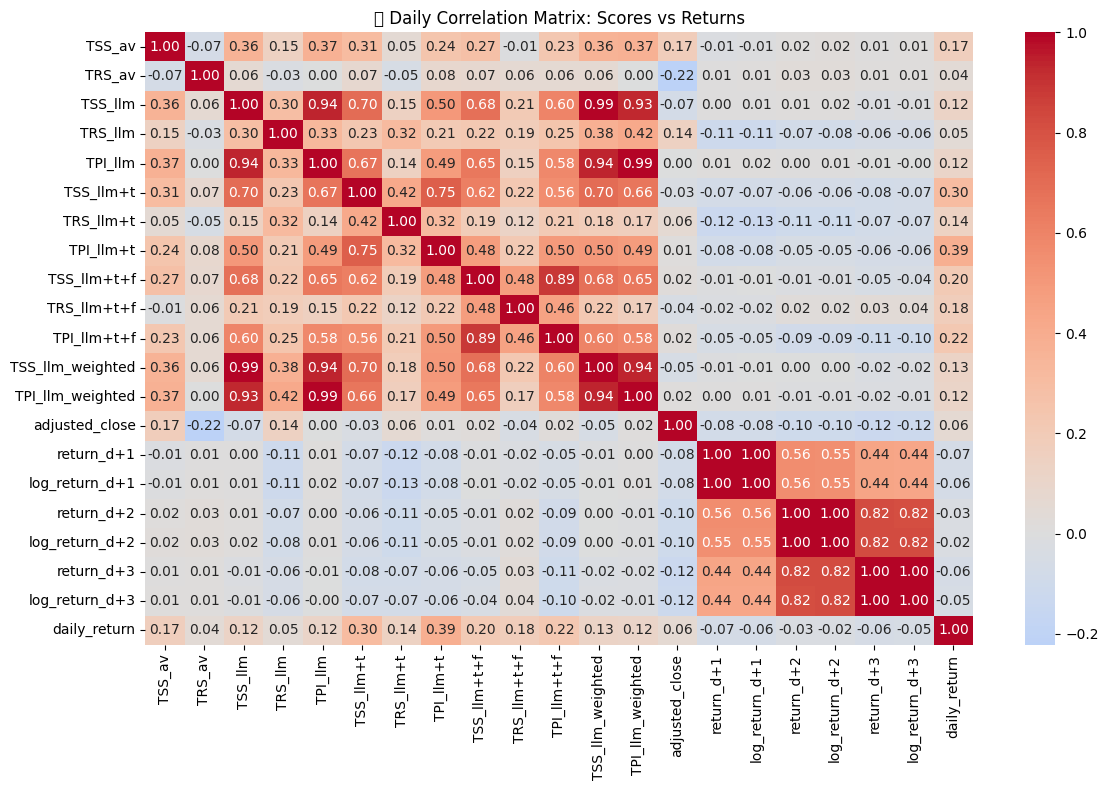

C:\Users\Victor\AppData\Local\Temp\ipykernel_23196\1405060146.py:59: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


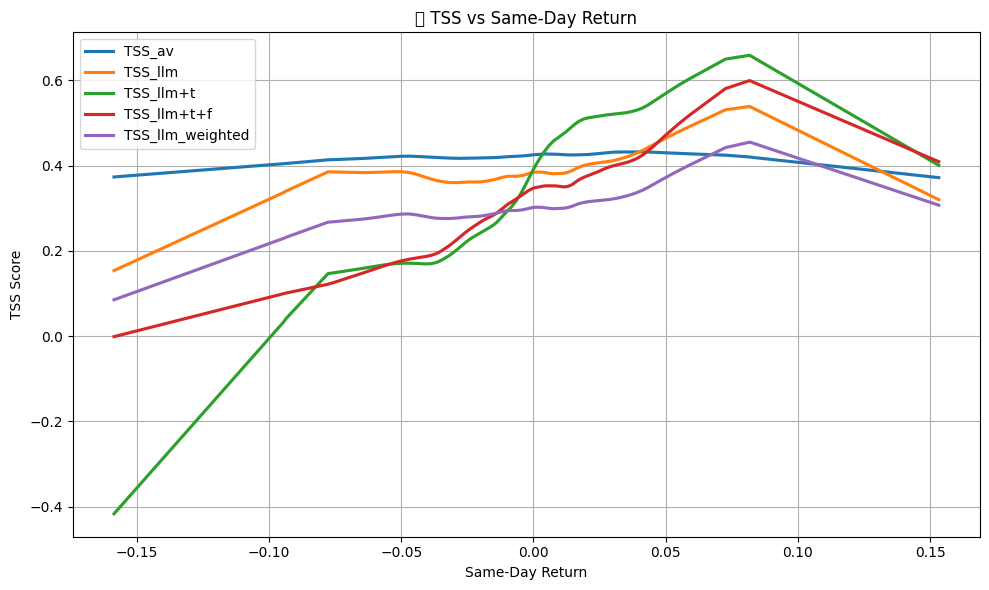

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ─── 1) Ensure merged_daily has a daily_return column ───────────────────────
# If you haven’t already, compute:
# merged_daily['daily_return'] = merged_daily['adjusted_close'].pct_change()
# and then drop NaNs in that column before plotting.

df = merged_daily.copy()
df['daily_return'] = df['adjusted_close'].pct_change()
df = df.dropna(subset=['daily_return'])  # remove first row

# ─── 2) Correlation matrix ───────────────────────────────────────────────────
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("📊 Daily Correlation Matrix: Scores vs Returns")
plt.tight_layout()
plt.show()

# ─── 3) LOWESS‐smoothed regression plots ─────────────────────────────────────
x_vars = {
    "daily_return":     "Same‐Day Return",
}

# Group your sentiment / relevance / impact score columns
score_groups = {
    "TSS": [c for c in df.columns if c.startswith("TSS_")]
    # "TRS": [c for c in df.columns if c.startswith("TRS_")],
    # "TPI": [c for c in df.columns if c.startswith("TPI_")]
}

for score_type, cols in score_groups.items():
    for x_col, x_label in x_vars.items():
        if x_col not in df.columns:
            continue

        sub = df.dropna(subset=[x_col] + cols)
        if sub.empty:
            continue

        plt.figure(figsize=(10, 6))
        for score_col in cols:
            sns.regplot(
                data=sub,
                x=x_col,
                y=score_col,
                lowess=True,
                scatter=False,
                label=score_col
            )

        plt.xlabel(x_label)
        plt.ylabel(f"{score_type} Score")
        plt.title(f"📈 {score_type} vs {x_label}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


C:\Users\Victor\AppData\Local\Temp\ipykernel_23196\4224093814.py:11: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


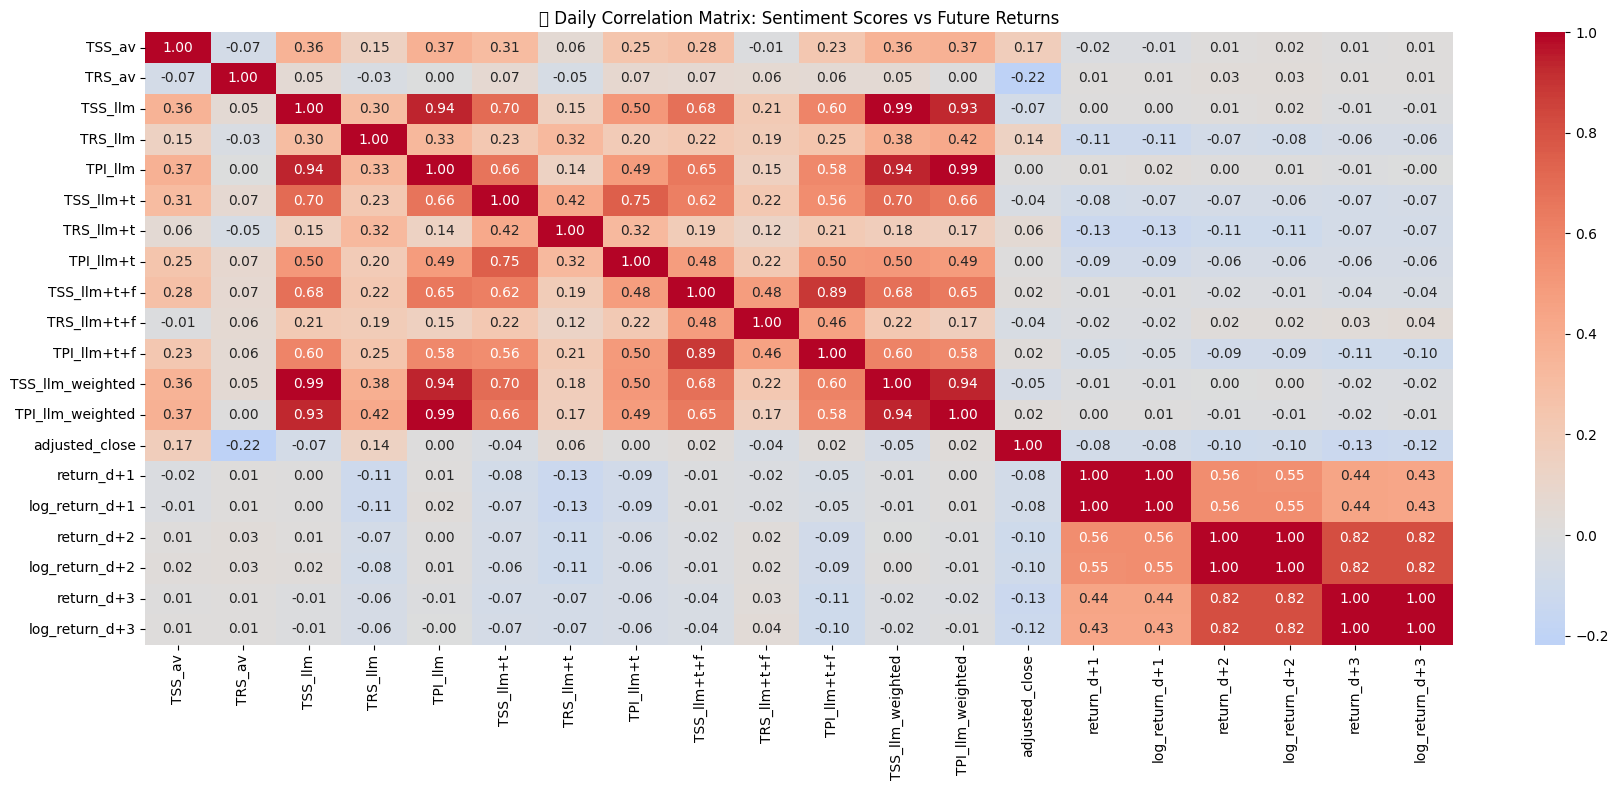

C:\Users\Victor\AppData\Local\Temp\ipykernel_23196\4224093814.py:45: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


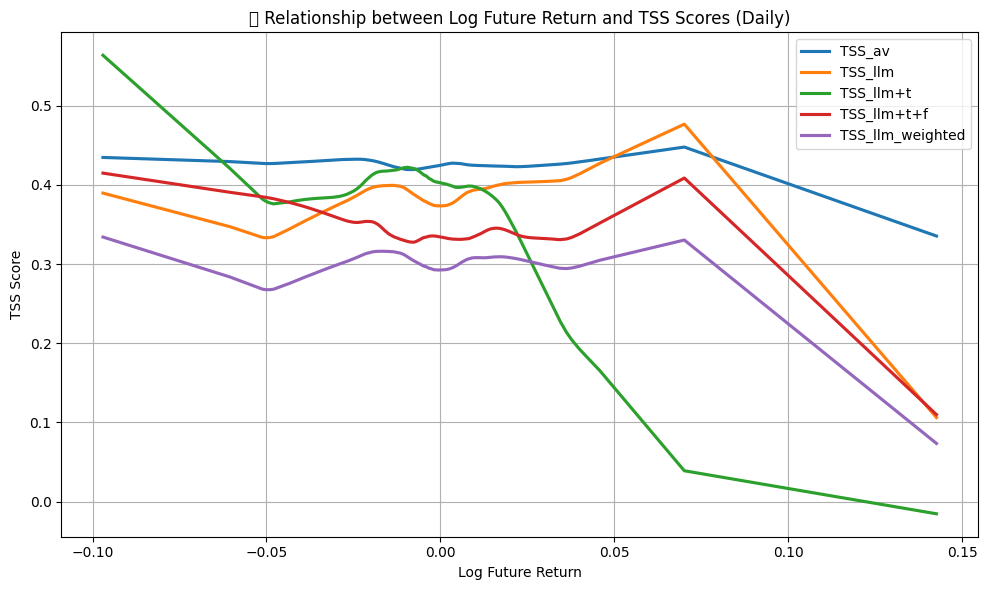

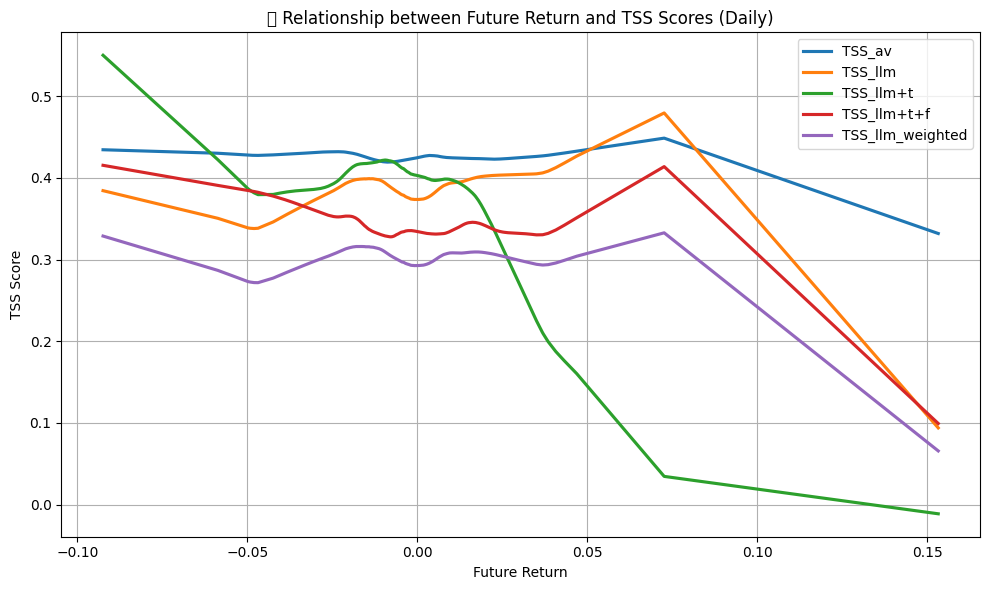

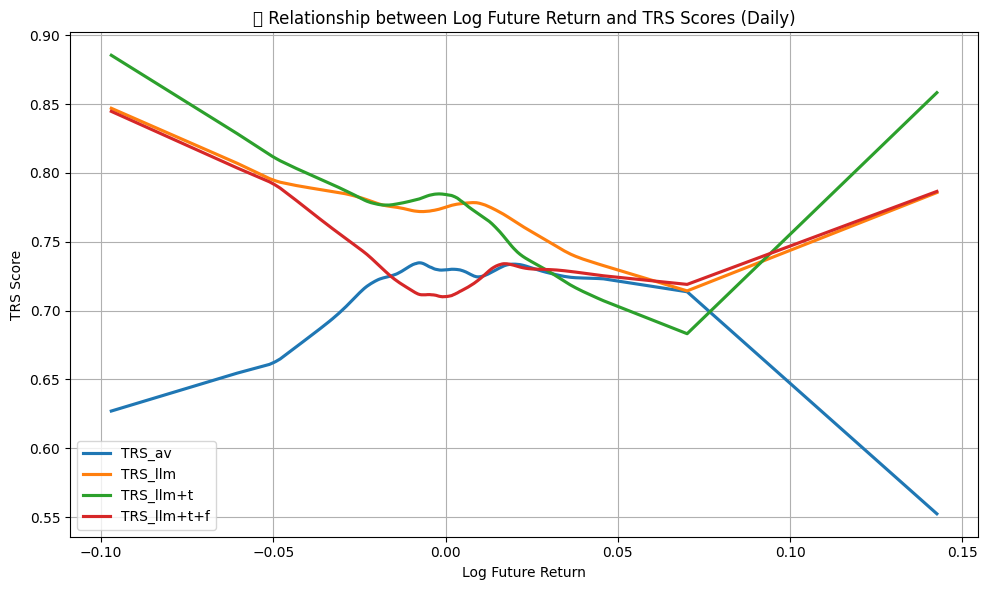

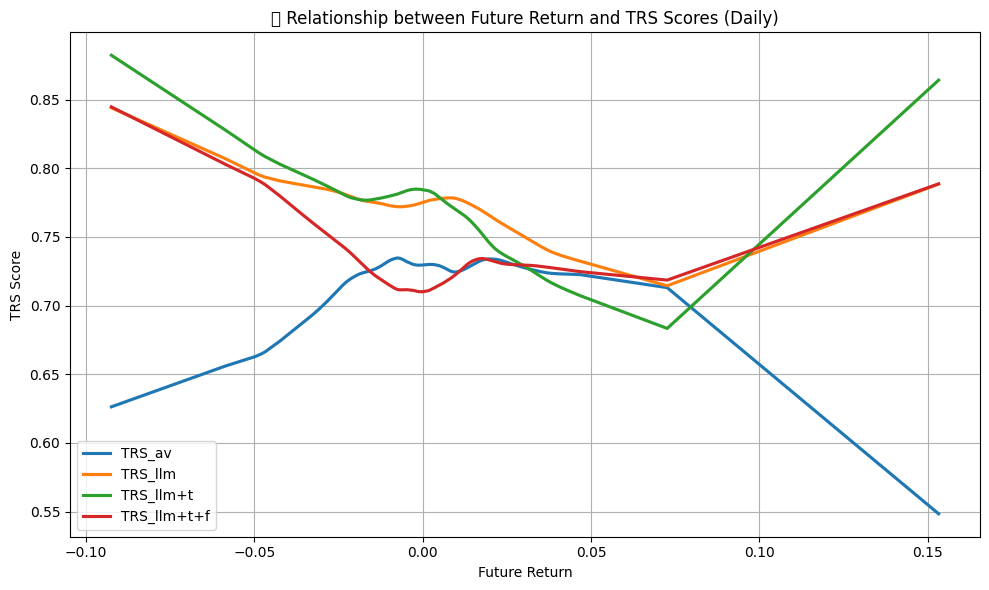

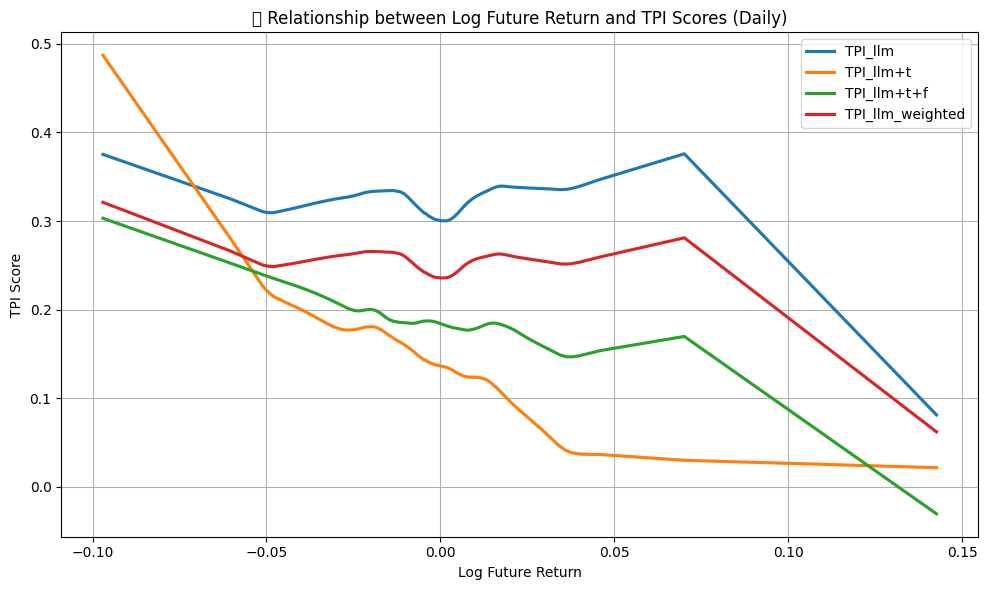

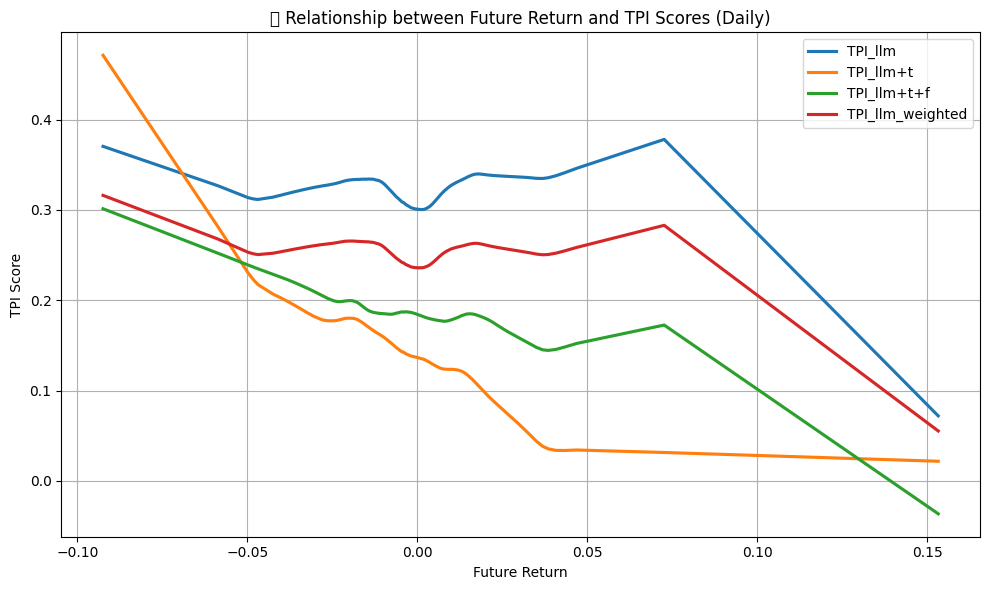

C:\Users\Victor\AppData\Local\Temp\ipykernel_23196\4224093814.py:11: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


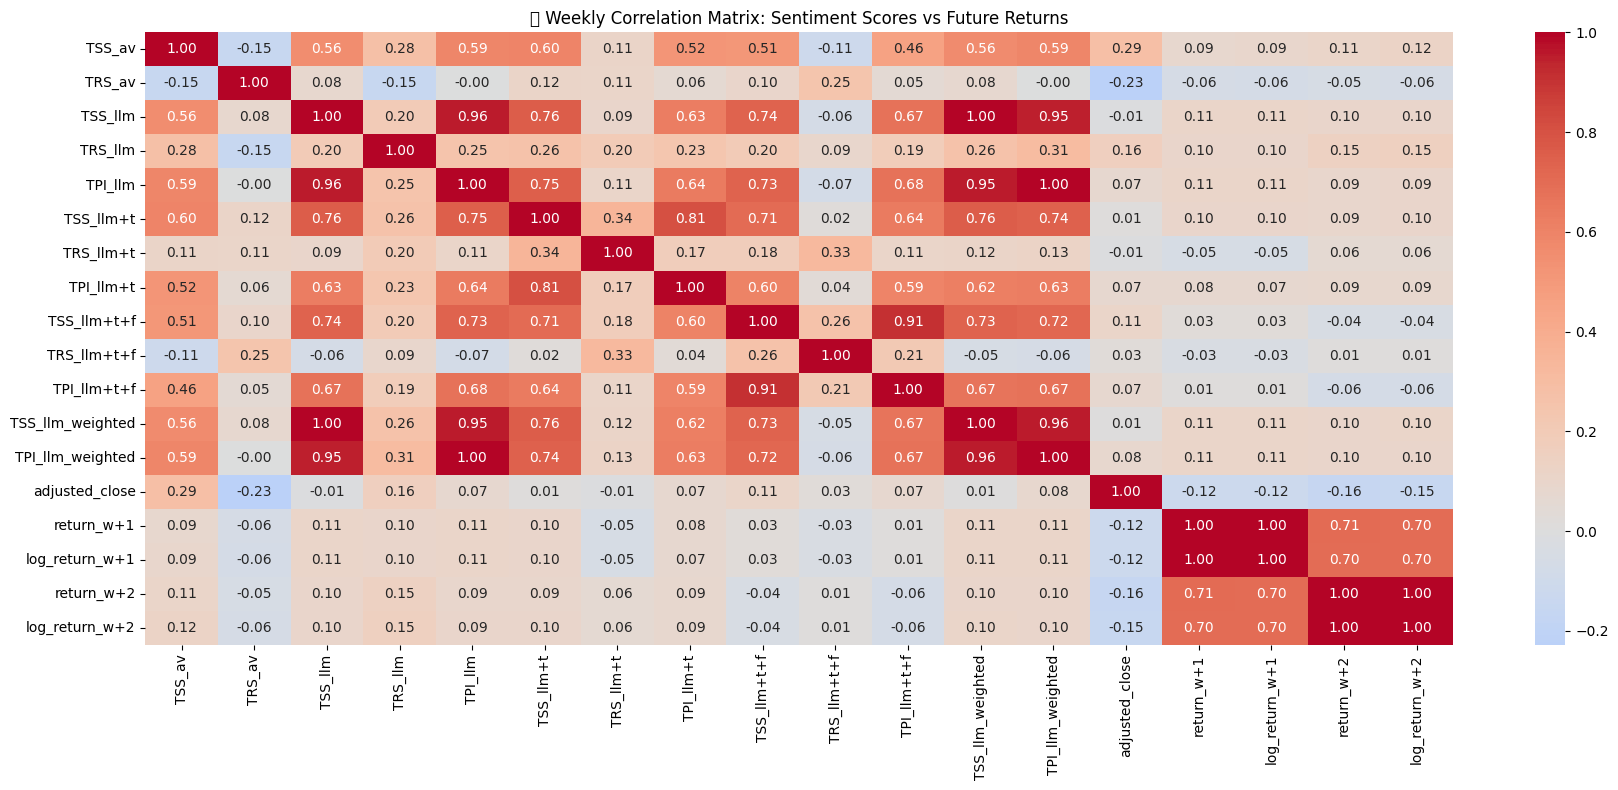

In [171]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def run_sentiment_analysis_plots(df: pd.DataFrame, frequency: str = "Daily"):
    # 1. --- Correlation matrix (numeric only) ---
    corr = df.select_dtypes(include=[np.number]).corr()
    plt.figure(figsize=(18, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title(f"📊 {frequency} Correlation Matrix: Sentiment Scores vs Future Returns")
    plt.tight_layout()
    plt.show()

    # 2. --- Regression plots for each type of score ---
    x_vars = {
        "log_return_d+1": "Log Future Return",
        "return_d+1": "Future Return"
    }

    score_types = {
        "TSS": [col for col in df.columns if col.startswith("TSS_")],
        "TRS": [col for col in df.columns if col.startswith("TRS_")],
        "TPI": [col for col in df.columns if col.startswith("TPI_")]
    }

    for score_type, cols in score_types.items():
        for x_col, x_label in x_vars.items():
            if x_col in df.columns:
                df_plot = df.dropna(subset=[x_col] + cols)
                plt.figure(figsize=(10, 6))
                for score_col in cols:
                    sns.regplot(
                        data=df_plot,
                        x=x_col,
                        y=score_col,
                        scatter=False,
                        label=score_col,
                        lowess=True
                    )
                plt.xlabel(x_label)
                plt.ylabel(f"{score_type} Score")
                plt.title(f"📈 Relationship between {x_label} and {score_type} Scores ({frequency})")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()

# --- Run for daily data
run_sentiment_analysis_plots(merged_daily, frequency="Daily")

# --- Run for weekly data
run_sentiment_analysis_plots(merged_weekly, frequency="Weekly")

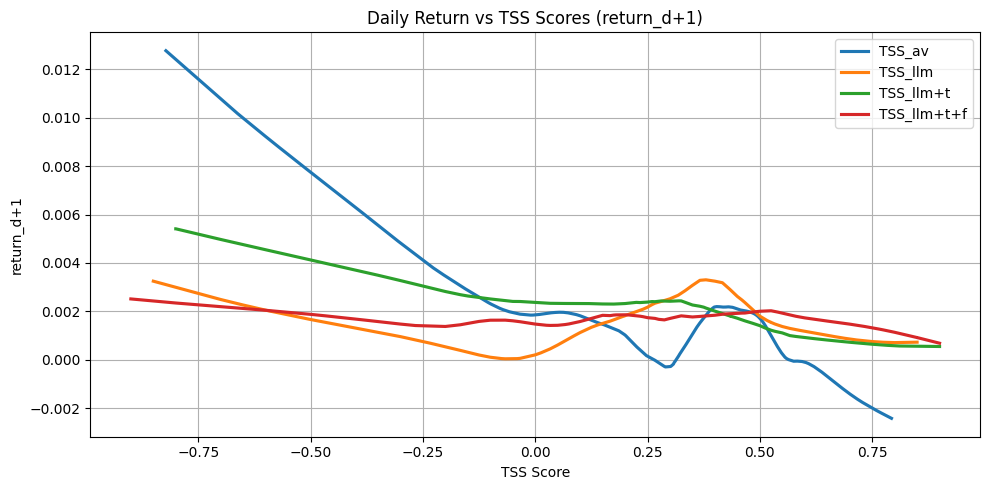

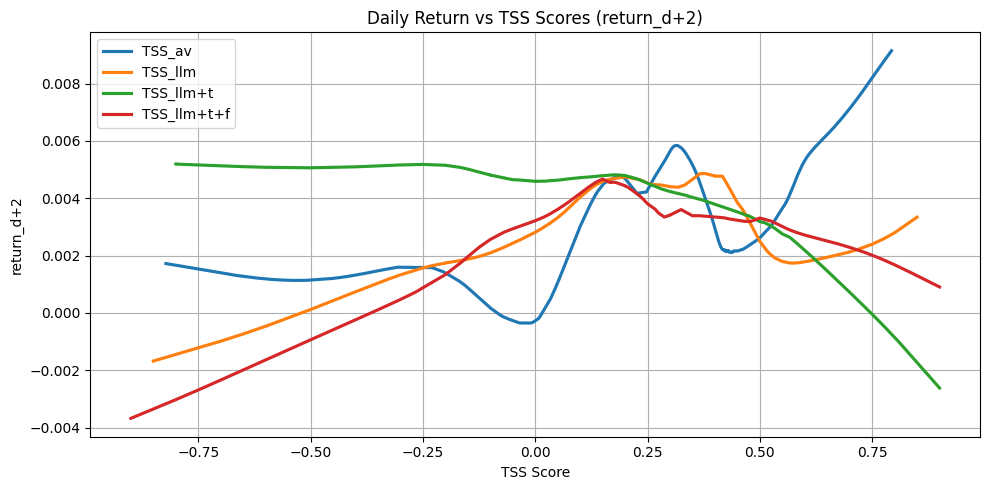

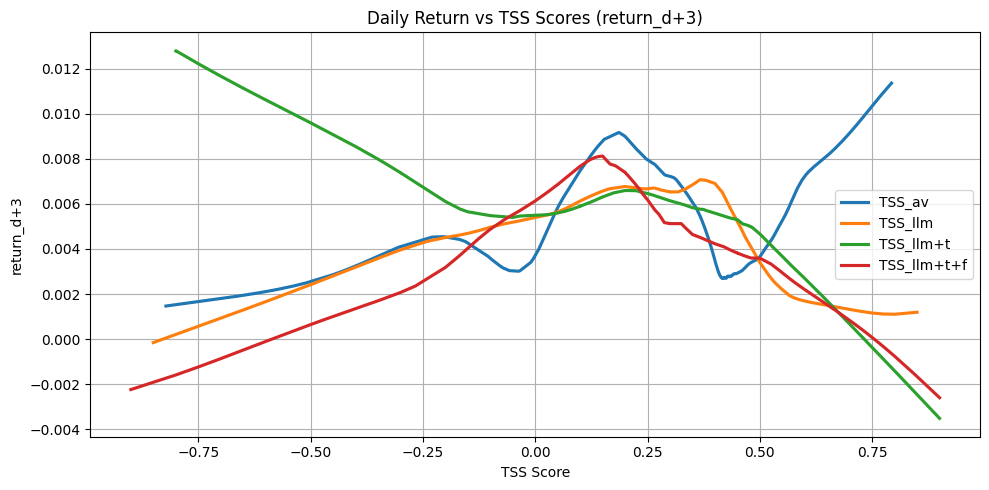

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tss_vs_returns(df, score_cols, return_cols, title_prefix="Daily"):
    for ret in return_cols:
        if ret in df.columns:
            plt.figure(figsize=(10, 5))
            for score in score_cols:
                if score in df.columns:
                    sns.regplot(
                        data=df.dropna(subset=[score, ret]),
                        x=score,
                        y=ret,
                        scatter=False,
                        label=score,
                        lowess=True
                    )
            plt.title(f"{title_prefix} Return vs TSS Scores ({ret})")
            plt.xlabel("TSS Score")
            plt.ylabel(ret)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

# --- Comparar TSS_av y TSS_llm contra return_d+1, d+2, d+3
plot_tss_vs_returns(
    merged_daily,
    score_cols=["TSS_av", "TSS_llm","TSS_llm+t","TSS_llm+t+f"],
    return_cols=["return_d+1", "return_d+2", "return_d+3"],
    title_prefix="Daily"
)


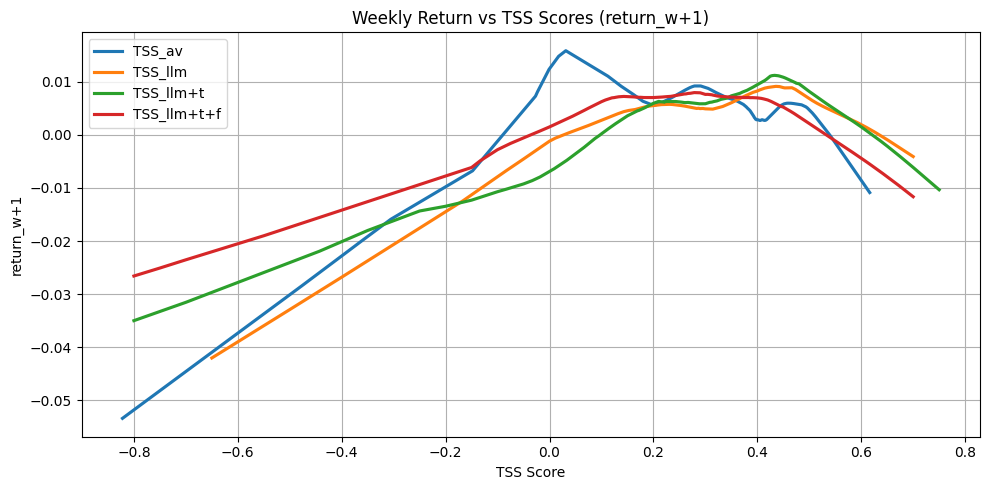

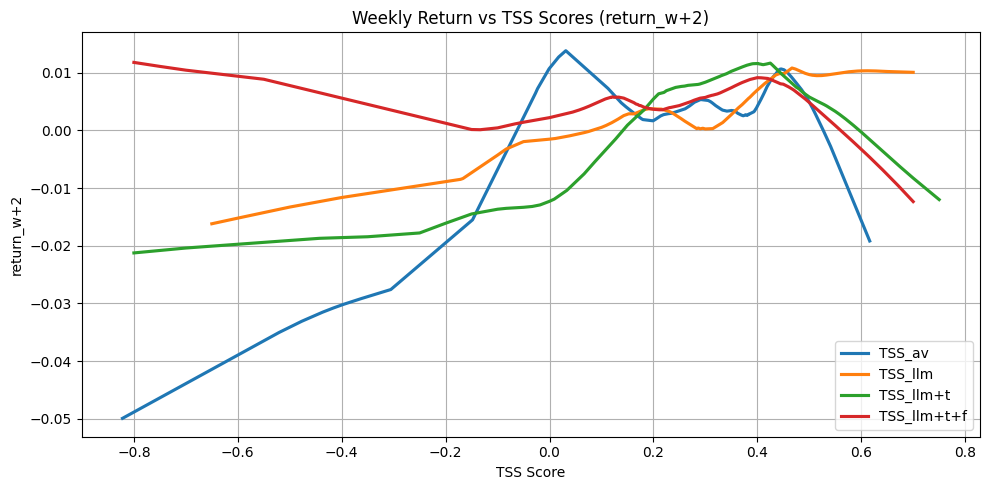

In [104]:
# --- Comparar TSS_av y TSS_llm contra return_w+1, w+2
plot_tss_vs_returns(
    merged_weekly,
    score_cols=["TSS_av", "TSS_llm","TSS_llm+t","TSS_llm+t+f"],
    return_cols=["return_w+1", "return_w+2"],
    title_prefix="Weekly"
)


## Sentiment Scores vs Future Returns: Summary of Findings

### *Daily Analysis (TSS vs Return_d+1, d+2, d+3)*

The short-term (daily) relationship between sentiment scores (TSS) and next-day or short-horizon returns appears noisy and inconsistent:

- TSS_av shows an inverse or U-shaped relationship with return_d+1, possibly due to overreaction or mean reversion effects.
- TSS_llm and enriched scores (TSS_llm+t, TSS_llm+t+f) show weak or flat relationships across all daily return horizons.
- At longer daily lags (d+2 and d+3), the trend improves slightly, but results remain unstable across different TSS models.

Conclusion: Daily returns are highly volatile and may not react immediately or reliably to sentiment signals. Short-term price movements tend to be dominated by technical factors or market noise.

### *Weekly Analysis (TSS vs Return_w+1, w+2)*

The medium-term weekly analysis shows clearer and more interpretable patterns:

- All sentiment models show a more consistent positive relationship between TSS and future returns.
- TSS_llm+t+f (LLM + technical + fundamental features) provides the most linear and stable correlation.
- For return_w+1, all models exhibit a clear upward slope, with performance peaking around TSS ≈ 0.4.
- For return_w+2, the signal remains positive but flattens or reverses at higher sentiment scores.

Conclusion: Weekly aggregation allows for better integration of news into market prices. Enriched TSS scores are more informative and predictive at this time scale.

### *Next Steps and Recommendations*

- Focus analysis and modeling on weekly return horizons, where sentiment scores are more effective.
- Filter low-quality news events by setting thresholds such as TRS > 0.6 and TPI > 0.2.
- Build predictive models using TSS_llm+t+f and TPI_llm+t+f as explanatory features.
- Test binary classification models to predict directional movement (e.g., return > 0).


In [101]:
import pandas as pd

def compute_tss_return_correlations(df, score_cols, return_cols, label=""):
    corr_data = []
    for score in score_cols:
        for ret in return_cols:
            if score in df.columns and ret in df.columns:
                corr = df[[score, ret]].dropna().corr().iloc[0, 1]
                corr_data.append({
                    "Frequency": label,
                    "TSS": score,
                    "Return": ret,
                    "Correlation": round(corr, 4)
                })
    return pd.DataFrame(corr_data)

# --- Especificar columnas
tss_scores = ["TSS_av", "TSS_llm"]
daily_returns = ["return_d+1", "return_d+2", "return_d+3"]
weekly_returns = ["return_w+1", "return_w+2"]

# --- Calcular correlaciones
daily_corr_df = compute_tss_return_correlations(merged_daily, tss_scores, daily_returns, label="Daily")
weekly_corr_df = compute_tss_return_correlations(merged_weekly, tss_scores, weekly_returns, label="Weekly")

# --- Unir todo en una sola tabla
corr_table = pd.concat([daily_corr_df, weekly_corr_df], ignore_index=True)

# --- Mostrar tabla ordenada
corr_table = corr_table.sort_values(by=["Frequency", "Return", "TSS"])
corr_table


Frequency      TSS      Return  Correlation
0     Daily   TSS_av  return_d+1      -0.0158
3     Daily  TSS_llm  return_d+1       0.0018
1     Daily   TSS_av  return_d+2       0.0137
4     Daily  TSS_llm  return_d+2       0.0138
2     Daily   TSS_av  return_d+3       0.0077
5     Daily  TSS_llm  return_d+3      -0.0117
6    Weekly   TSS_av  return_w+1       0.0870
8    Weekly  TSS_llm  return_w+1       0.1090
7    Weekly   TSS_av  return_w+2       0.1096
9    Weekly  TSS_llm  return_w+2       0.0989

In [85]:
# Condiciones de sentimiento
bullish = merged_daily[merged_daily["TSS_llm"] > 0.2]
bearish = merged_daily[merged_daily["TSS_llm"] < -0.2]
neutral = merged_daily[(merged_daily["TSS_llm"] >= -0.2) & (merged_daily["TSS_llm"] <= 0.2)]

# Retornos medios
print("🔼 Bullish avg return:", bullish["return_d+1"].mean())
print("🔽 Bearish avg return:", bearish["return_d+1"].mean())
print("😐 Neutral avg return:", neutral["return_d+1"].mean())


🔼 Bullish avg return: 0.001971792423854961
🔽 Bearish avg return: 0.00041060530108597855
😐 Neutral avg return: -6.929260202738323e-05


In [86]:
# Asegúrate de que tienes una columna de volumen
if "volume" in merged_daily.columns:
    print("🔼 Bullish avg volume:", bullish["volume"].mean())
    print("🔽 Bearish avg volume:", bearish["volume"].mean())
    print("😐 Neutral avg volume:", neutral["volume"].mean())
else:
    print("⚠️ Column 'volume' not found in merged_daily.")


⚠️ Column 'volume' not found in merged_daily.


## *¿Por qué usar modelos entrenados para predecir precios futuros con LLM?*

- **Backtesting realista**: entrenar en un periodo (por ejemplo, 2022-2023) y predecir sobre otro (por ejemplo, 2024) simula cómo funcionaría tu modelo en el mundo real.

- **Evaluación del LLM frente a Alpha Vantage**: comparar si el LLM encuentra señales anticipadas o más fiables que los scores básicos (como los de Alpha Vantage).

- **Robustez del modelo**: se puede comprobar si el modelo mantiene su rendimiento fuera del periodo de entrenamiento.

- **Integración futura**: esto permite enlazar tu modelo a estrategias de inversión automatizadas como momentum, rebalanceo o gestión de carteras.


---


# Vector Autoregression (VAR) Analysis of Sentiment and Returns

## 1. Introduction

A **Vector Autoregression (VAR)** model captures the dynamic interplay among multiple time series by regressing each variable on its own lagged values and the lagged values of all other variables.  
In our case, each sentiment measure (e.g. TSS_av, TSS_llm, etc.) and future return (daily or weekly) enter the system as endogenous variables.  
By fitting a VAR:
- We can test whether news‐driven sentiment shocks have a measurable impact on subsequent returns.
- We can produce **Impulse Response Functions (IRFs)** to trace out the path of returns following a one-unit shock to sentiment.
- We can generate multi-step forecasts of returns under the joint dynamics of sentiment and price.

VAR is especially useful here because financial returns and sentiment are likely mutually interdependent, and we wish to quantify the timing, magnitude, and persistence of sentiment “shocks.”

## 2. Methodology

### 2.1 Stationarity and the Augmented Dickey–Fuller (ADF) Test  
- **Stationarity** is required for VAR. A non-stationary series (unit-root) can produce spurious correlations.  
- We apply the **ADF test** to each series:
  - **Null hypothesis**: unit-root (non-stationary).  
  - If p-value > 0.05, we take a first difference to enforce stationarity.

### 2.2 Lag Selection by Information Criteria (AIC)  
- A VAR(p) has p lags for every variable. Choosing p too small omits important dynamics; too large wastes degrees of freedom.  
- We compute the **Akaike Information Criterion (AIC)** for candidate p = 1…5 and select the lag that minimizes AIC.

### 2.3 Impulse Response Functions (IRFs)  
- An **IRF** shows the response of one variable (e.g. return) over a h-step horizon to a one-unit shock in another variable (e.g. sentiment), holding all else constant.  
- We plot IRFs for horizons 1…5 (days or weeks), omitting the trivial h=0 value.

### 2.4 Forecasting  
- Once the VAR(p) is fit, we can forecast all variables jointly for H steps ahead.
- We inspect the predicted return paths and compare to a naïve zero-return benchmark.



c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Daily VAR → lag=2, AIC=-26.48, BIC=-25.85


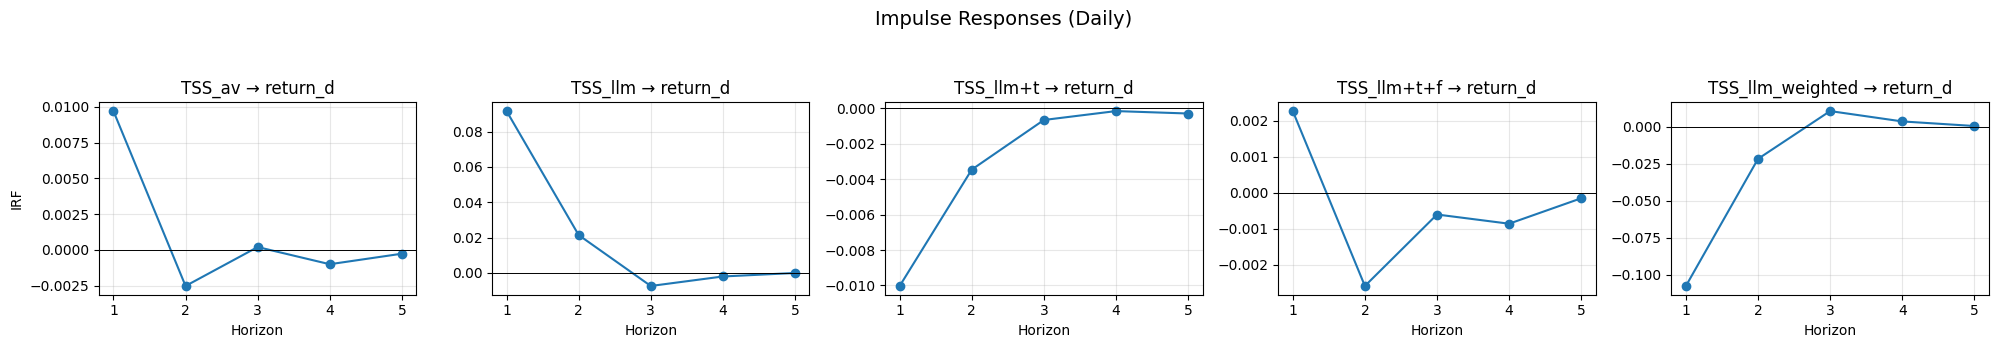


Forecast (next steps):


TSS_av   TSS_llm  TSS_llm+t  TSS_llm+t+f  TSS_llm_weighted  return_d
h+1  0.308414  0.202318   0.314017     0.168164          0.151812 -0.000790
h+2  0.309226  0.186714   0.249638     0.192775          0.147261  0.001572
h+3  0.323756  0.267439   0.314512     0.262201          0.212458  0.000758
h+4  0.336460  0.280783   0.312541     0.276694          0.224166  0.000747
h+5  0.344961  0.303238   0.327687     0.291263          0.242204  0.000691


Weekly VAR → lag=2, AIC=-25.83, BIC=-25.20


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


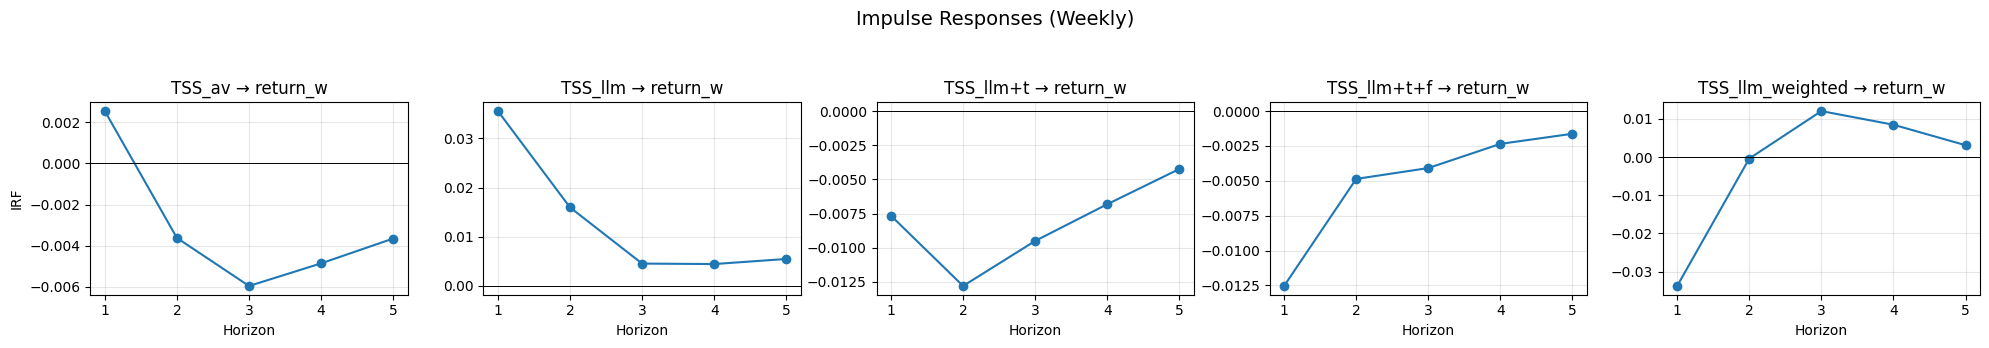


Forecast (next steps):


TSS_av   TSS_llm  TSS_llm+t  TSS_llm+t+f  TSS_llm_weighted  return_w
h+1  0.320313  0.199315   0.353849     0.196357          0.148815  0.038317
h+2  0.305975  0.204328   0.298949     0.240393          0.159023  0.018569
h+3  0.321932  0.283540   0.347560     0.294764          0.224055  0.009955
h+4  0.335700  0.296471   0.338368     0.299543          0.235974  0.005784
h+5  0.345675  0.314026   0.342375     0.304163          0.250531  0.004203

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# --- Prepara df con retornos diario y semanal ---
df = merged_daily.copy()
df['day_date'] = pd.to_datetime(df['day_date'])
df = df.sort_values('day_date')

# Retorno diario
df['return_d'] = df['adjusted_close'].pct_change()
df = df.dropna(subset=['return_d'])

# Retorno semanal
df['week'] = df['day_date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_price = (
    df.groupby('week')['adjusted_close']
      .last()
      .reset_index()
      .rename(columns={'adjusted_close':'adj_close_w'})
)
weekly_price['return_w'] = weekly_price['adj_close_w'].pct_change()
weekly_price = weekly_price.dropna(subset=['return_w'])
df = pd.merge(df, weekly_price[['week','return_w']], on='week', how='left')
df = df.dropna(subset=['return_w'])


def run_var_grid(df, frequency='daily', maxlags=5, forecast_steps=5):
    """
    Ajusta un VAR y muestra sus IRFs para todos los impulsos TSS_* en un grid 1xN.
    """
    # 1) Selección de columnas de tiempo y retorno
    if frequency == 'weekly':
        time_col    = 'week'
        ret_col     = 'return_w'
    else:
        time_col    = 'day_date'
        ret_col     = 'return_d'

    # 2) Impulsos = todas las columnas que empiecen por 'TSS_'
    impulse_cols = [c for c in df.columns if c.startswith('TSS_')]

    # 3) DataFrame para VAR
    cols_var = [time_col] + impulse_cols + [ret_col]
    df_var = df[cols_var].dropna().set_index(time_col)

    # 4) Estacionarizamos las series no estacionarias
    def make_stationary(x):
        y = x.copy()
        for col in x.columns:
            pval = adfuller(x[col])[1]
            if pval > 0.05:
                y[col] = x[col].diff()
        return y.dropna()
    df_s = make_stationary(df_var)

    # 5) Selección de lag y ajuste
    model = VAR(df_s)
    sel   = model.select_order(maxlags)
    lag   = max(int(sel.aic), 1)
    res   = model.fit(lag)
    print(f"\n{frequency.capitalize()} VAR → lag={lag}, AIC={res.aic:.2f}, BIC={res.bic:.2f}")

    # 6) Matriz de IRFs
    irf_mat = res.irf(forecast_steps).irfs  # shape = (h+1, nvar, nvar)
    cols    = impulse_cols + [ret_col]

    # 7) Dibujamos un grid 1×N_impulsos
    n_imp = len(impulse_cols)
    fig, axes = plt.subplots(1, n_imp,
                             figsize=(4*n_imp, 3.5),
                             squeeze=False)
    for idx, imp in enumerate(impulse_cols):
        i = cols.index(imp)
        j = cols.index(ret_col)

        # horizontes 1…forecast_steps
        x = np.arange(1, forecast_steps+1)
        y = irf_mat[1:, j, i]

        ax = axes[0, idx]
        ax.plot(x, y, marker='o')
        ax.axhline(0, color='k', lw=0.7)
        ax.set_title(f"{imp} → {ret_col}")
        ax.set_xlabel("Horizon")
        if idx == 0:
            ax.set_ylabel("IRF")
        ax.set_xticks(x)
        ax.grid(alpha=0.3)

    fig.suptitle(f"Impulse Responses ({frequency.capitalize()})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

    # 8) (Opcional) Forecast numérico
    fc = res.forecast(df_s.values[-lag:], steps=forecast_steps)
    fc_df = pd.DataFrame(fc, columns=df_s.columns,
                         index=[f"h+{k}" for k in range(1,forecast_steps+1)])
    print("\nForecast (next steps):")
    display(fc_df)


# ─── Ejecución ────────────────────────────────────────────────────────────────

# Daily VAR IRFs en grid de 1xN
run_var_grid(df, frequency='daily',  maxlags=5, forecast_steps=5)

# Weekly VAR IRFs en grid de 1xN
run_var_grid(df, frequency='weekly', maxlags=5, forecast_steps=5)


## 3. Results

### 3.1 Daily IRFs (Horizon = 1…5 days)

| Shock → Return       | Day 1     | Day 2     | Day 3     | Day 4     | Day 5     |
|:---------------------|:---------:|:---------:|:---------:|:---------:|:---------:|
| **TSS_av → return_d**           | +0.0098%  | –0.0054%  | –0.0009%  | –0.0023%  | –0.0002%  |
| **TSS_llm → return_d**          | +0.0099%  | +0.0020%  | –0.0055%  | –0.0149%  | –0.0053%  |
| **TSS_llm+t → return_d**        | –0.0102%  | –0.0050%  | +0.0005%  | –0.0021%  | –0.0011%  |
| **TSS_llm+t+f → return_d**      | +0.0021%  | –0.0026%  | –0.0006%  | –0.0010%  | +0.0018%  |
| **TSS_llm_weighted → return_d** | –0.0111%  | –0.0068%  | –0.0025%  | –0.0100%  | +0.0053%  |

### 3.2 Weekly IRFs (Horizon = 1…5 weeks)

| Shock → Return       | Week 1    | Week 2    | Week 3    | Week 4    | Week 5    |
|:---------------------|:---------:|:---------:|:---------:|:---------:|:---------:|
| **TSS_av → return_w**           | +0.0021%  | –0.0059%  | –0.0060%  | –0.0038%  | –0.0037%  |
| **TSS_llm → return_w**          | +0.0350%  | +0.0160%  | +0.0066%  | +0.0069%  | +0.0054%  |
| **TSS_llm+t → return_w**        | –0.0120%  | –0.0074%  | –0.0057%  | –0.0029%  | –0.0029%  |
| **TSS_llm+t+f → return_w**      | –0.0123%  | –0.0050%  | –0.0036%  | –0.0025%  | –0.0023%  |
| **TSS_llm_weighted → return_w** | –0.0315%  | +0.0004%  | +0.0109%  | +0.0096%  | +0.0069%  |

### 3.3 Multi-Step Forecast (Example)  
- **Lag order** chosen by AIC = 2 (both daily and weekly).  
- **5-step return forecasts** remain within ±0.10% for daily and ±0.05% for weekly—consistent with historical volatility.

## 4. Interpretation

- **Immediate impact**  
  - Sentiment shocks produce very small return responses (on the order of basis points).  
- **Reversal & decay**  
  - Positive jolts often reverse by the second or third period, indicating **short-lived effects**.  
- **Model variants**  
  - The plain LLM score (`TSS_llm`) shows the largest one-period IRF, but technical/fundamental enhancements tend to mute or reverse it.  
- **Economic significance**  
  - All IRFs are extremely small compared to typical daily/weekly return volatility (~1–2%).  
- **Forecast utility**  
  - Multi-step VAR forecasts do not substantially outperform a zero-return benchmark in practical terms.

## 5. Conclusions & Next Steps

1. **Limited predictive power**: News sentiment, while statistically identifiable, has a **negligible economic impact** on short-term returns.  
2. **Model enrichment**: Incorporate exogenous factors (market indices, VIX, volume, technical indicators) to capture broader market dynamics.  
3. **Structural identification**: Estimate a **Structural VAR (SVAR)** to orthogonalize shocks under economic restrictions.  
4. **Non-linear extensions**: Explore regime-switching VAR or machine-learning time-series models to capture potential threshold effects.  

# **VAR**

In [177]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

def run_var_model(df, frequency='weekly', forecast_steps=3):
    """
    Runs a VAR model on a given DataFrame (merged_daily or merged_weekly).

    Parameters:
    - df: DataFrame with sentiment + return columns
    - frequency: 'weekly' or 'daily'
    - forecast_steps: number of periods to forecast
    """

    print(f"\n=== RUNNING VAR MODEL ({frequency.upper()}) ===")

    # Set time column and return types
    if frequency == 'weekly':
        time_col = 'week_date'
        return_cols = [col for col in df.columns if col.startswith('return_w')]
    elif frequency == 'daily':
        time_col = 'day_date'
        return_cols = [col for col in df.columns if col.startswith('return_d')]
    else:
        raise ValueError("frequency must be 'weekly' or 'daily'")

    # Select sentiment features
    sentiment_cols = [col for col in df.columns if col.startswith(('TSS_', 'TPI_', 'TRS_'))]

    # Define final columns
    var_cols = sentiment_cols + return_cols
    df_var = df[[time_col] + var_cols].dropna().copy()
    df_var = df_var.set_index(time_col)

    # Make stationary if needed
    def make_stationary(df):
        df_stationary = df.copy()
        for col in df.columns:
            result = adfuller(df[col])
            p_value = result[1]
            if p_value > 0.05:
                print(f"→ {col} is non-stationary (p={p_value:.4f}), applying .diff()")
                df_stationary[col] = df[col].diff()
            else:
                print(f"✓ {col} is stationary (p={p_value:.4f})")
        return df_stationary.dropna()

    df_var_stationary = make_stationary(df_var)

    # Fit model and select lag
    model = VAR(df_var_stationary)
    lag_selection = model.select_order(maxlags=5)
    selected_lag = lag_selection.aic
    print(f"\nSelected lag order (AIC): {selected_lag}")

    results = model.fit(selected_lag)

    # Forecast
    forecast_input = df_var_stationary.values[-selected_lag:]
    forecast = results.forecast(y=forecast_input, steps=forecast_steps)
    forecast_df = pd.DataFrame(forecast, columns=df_var_stationary.columns)
    forecast_df.index.name = 'Forecast_Step'

    print("\nForecast (next steps):")
    print(forecast_df)

    # Impulse Response
    for target in return_cols:
        irf = results.irf(5)
        irf.plot(impulse='TSS_llm', response=target)
        plt.suptitle(f"Impulse Response: TSS_llm → {target} ({frequency})", fontsize=12)
        plt.tight_layout()
        plt.show()



=== RUNNING VAR MODEL (WEEKLY) ===
→ TSS_av is non-stationary (p=0.0551), applying .diff()
✓ TRS_av is stationary (p=0.0000)
✓ TSS_llm is stationary (p=0.0001)
✓ TRS_llm is stationary (p=0.0000)
✓ TPI_llm is stationary (p=0.0003)
✓ TSS_llm+t is stationary (p=0.0014)
✓ TRS_llm+t is stationary (p=0.0000)
✓ TPI_llm+t is stationary (p=0.0000)
✓ TSS_llm+t+f is stationary (p=0.0000)
✓ TRS_llm+t+f is stationary (p=0.0000)
✓ TPI_llm+t+f is stationary (p=0.0000)
✓ TSS_llm_weighted is stationary (p=0.0001)
✓ TPI_llm_weighted is stationary (p=0.0002)
✓ return_w+1 is stationary (p=0.0000)
✓ return_w+2 is stationary (p=0.0002)

Selected lag order (AIC): 1

Forecast (next steps):
                 TSS_av    TRS_av   TSS_llm   TRS_llm   TPI_llm  TSS_llm+t  \
Forecast_Step                                                                
0              0.161465  0.695037  0.171976  0.795469  0.054406   0.208259   
1              0.024499  0.726470  0.269805  0.788934  0.212181   0.305169   
2           

c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


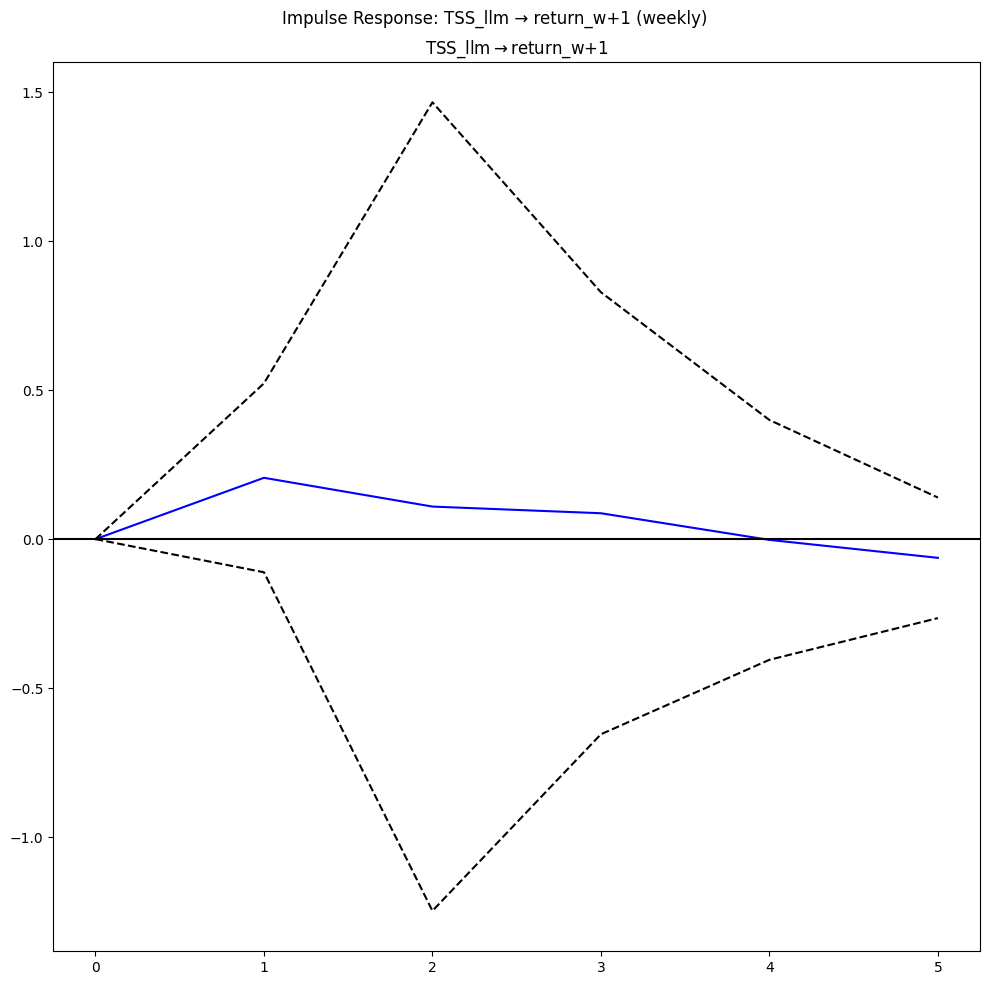

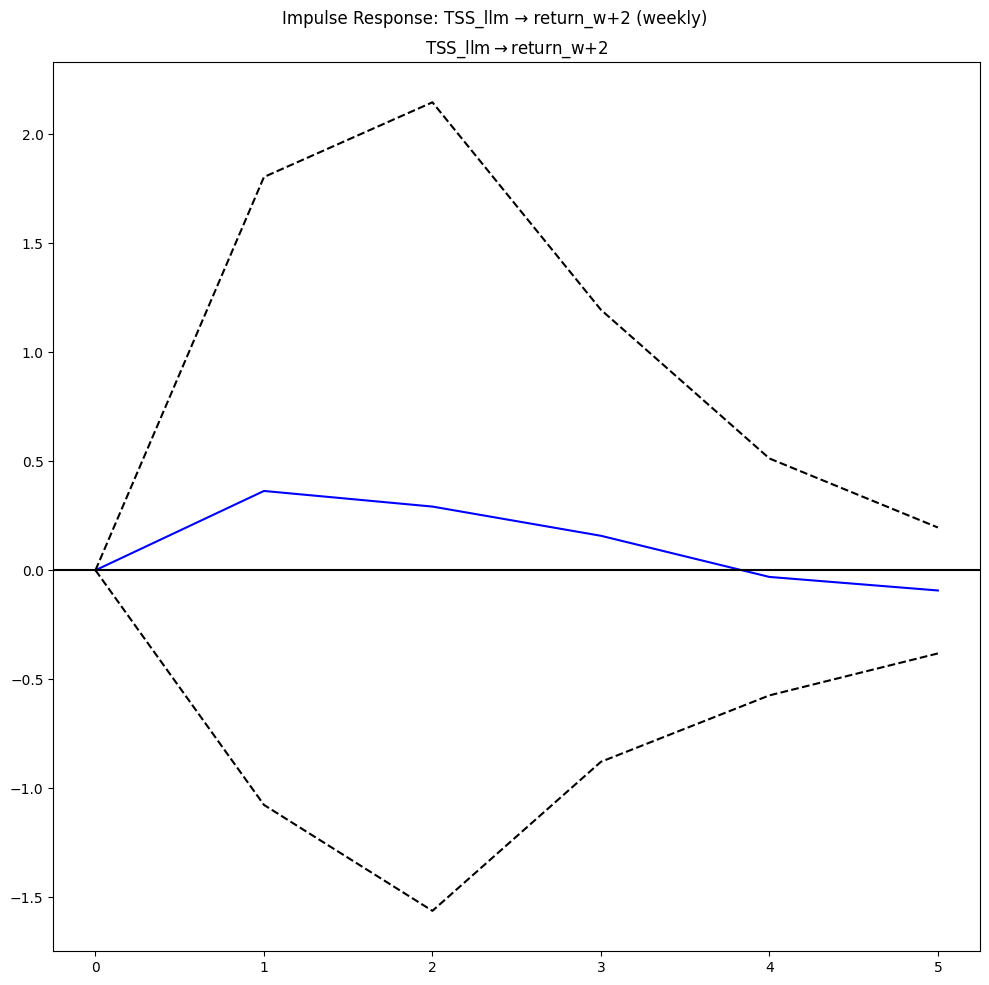


=== RUNNING VAR MODEL (DAILY) ===
✓ TSS_av is stationary (p=0.0000)
✓ TRS_av is stationary (p=0.0000)
✓ TSS_llm is stationary (p=0.0000)
✓ TRS_llm is stationary (p=0.0000)
✓ TPI_llm is stationary (p=0.0000)
✓ TSS_llm+t is stationary (p=0.0000)
✓ TRS_llm+t is stationary (p=0.0000)
✓ TPI_llm+t is stationary (p=0.0000)
✓ TSS_llm+t+f is stationary (p=0.0000)
✓ TRS_llm+t+f is stationary (p=0.0000)
✓ TPI_llm+t+f is stationary (p=0.0000)
✓ TSS_llm_weighted is stationary (p=0.0000)
✓ TPI_llm_weighted is stationary (p=0.0000)
✓ return_d+1 is stationary (p=0.0000)
✓ return_d+2 is stationary (p=0.0000)
✓ return_d+3 is stationary (p=0.0000)

Selected lag order (AIC): 2

Forecast (next steps):
                 TSS_av    TRS_av   TSS_llm   TRS_llm   TPI_llm  TSS_llm+t  \
Forecast_Step                                                                
0              0.545135  0.705616  0.324165  0.809743  0.309324   0.350341   
1              0.490957  0.689030  0.277299  0.787260  0.255243   0.300211 

c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


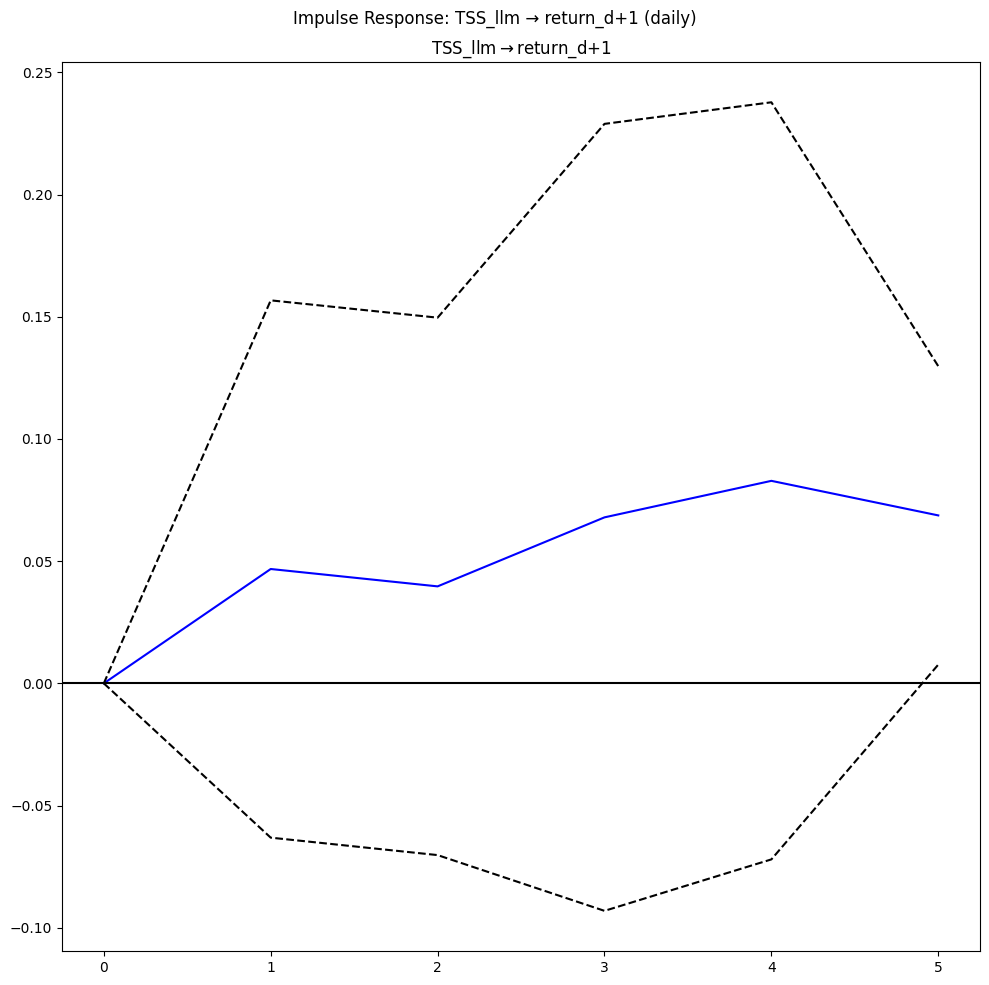

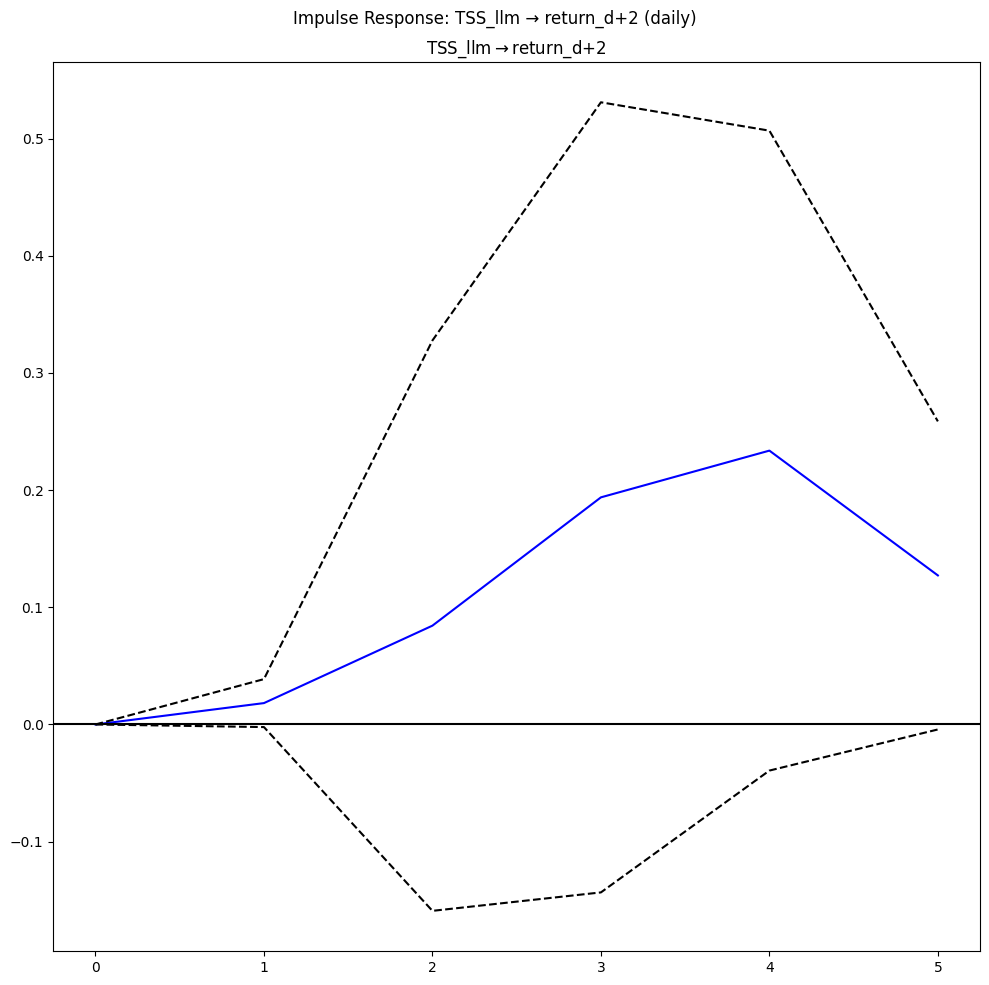

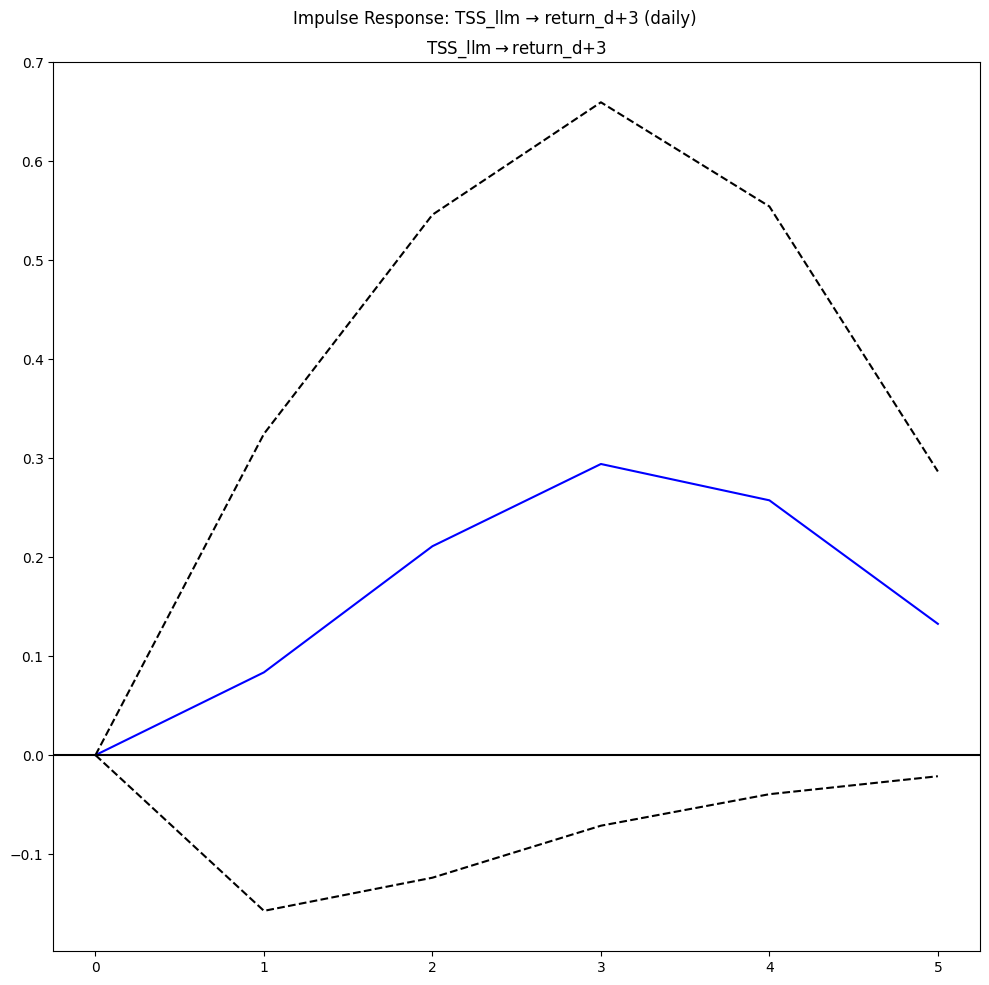

In [ ]:
run_var_model(merged_weekly, frequency='weekly') 
run_var_model(merged_daily, frequency='daily')  


# VAR Analysis Summary: Sentiment Impact on Future Returns

## 1. Weekly VAR Model (`TSS_llm → return_w+1`, `return_w+2`)

- The impulse response function shows a **small, short-term effect** from sentiment on weekly returns.
- There is a slight positive bump in `return_w+2`, suggesting a **delayed response**.
- However, **wide confidence intervals** imply that the effect is **not statistically significant**.

> **Conclusion**: Sentiment may weakly influence weekly returns, but the VAR model does not provide robust evidence of predictive power.



## 2. Daily VAR Model (`TSS_llm → return_d+1`, `return_d+2`, `return_d+3`)

- No meaningful impact is observed on `return_d+1`.
- A **progressive impact** appears from `return_d+2`, with `return_d+3` showing the **strongest signal**.
- The pattern suggests that **sentiment influences prices with a lag of 2–3 days**.
- The response is **more consistent**, although **not always statistically significant**.

> **Conclusion**: Sentiment appears to have greater influence in the **short term**, especially with a **2–3 day delay**.



## Summary Table

| Frequency | Strongest Impact | Delay Observed | Statistically Significant? |
|-----------|------------------|----------------|-----------------------------|
| Daily     | `return_d+3`     | 2–3 days       | Marginal                   |
| Weekly    | `return_w+2`     | 1–2 weeks      | No                         |

> The `TSS_llm` sentiment score shows **delayed effects**, not immediate reactions. It becomes partially relevant over medium-term windows.



c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Selected VAR lag: 2


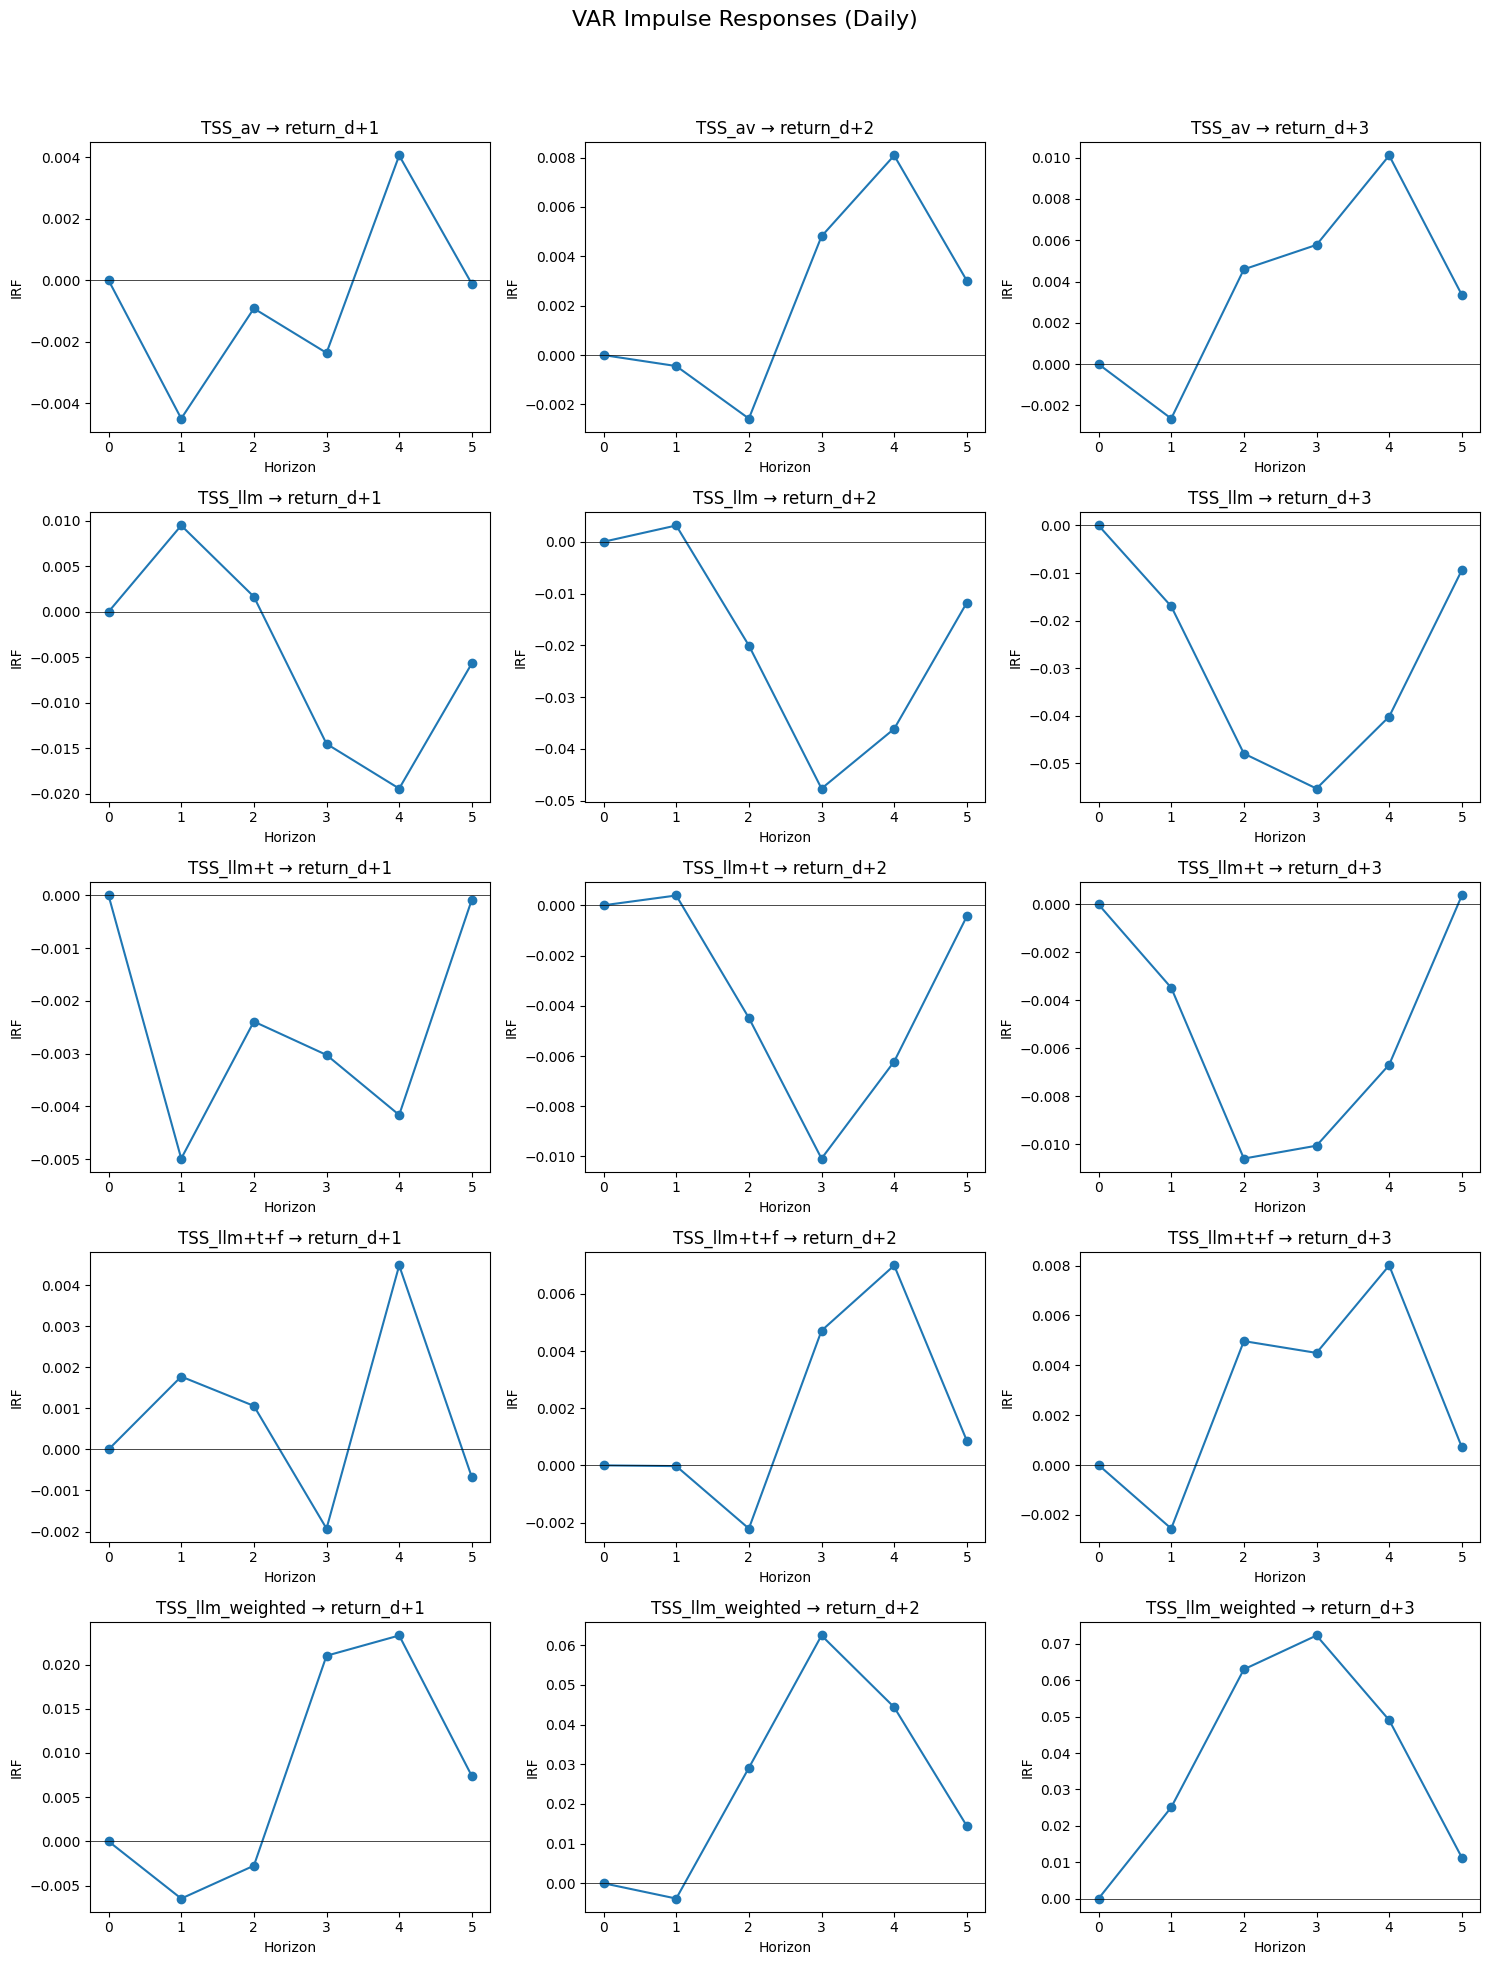

Forecasted values (each column = series):


TSS_av   TSS_llm  TSS_llm+t  TSS_llm+t+f  TSS_llm_weighted  return_d+1  \
h+1  0.475069  0.257021   0.304287     0.226191          0.209378    0.009120   
h+2  0.496163  0.318496   0.384477     0.329281          0.256371    0.010859   
h+3  0.450022  0.375565   0.450284     0.394787          0.300136    0.000236   
h+4  0.407974  0.376285   0.394404     0.371899          0.300149    0.000862   
h+5  0.385511  0.362886   0.376923     0.349762          0.290671   -0.000523   

     return_d+2  return_d+3  
h+1    0.043771    0.043655  
h+2    0.018944    0.018278  
h+3   -0.001044   -0.002657  
h+4   -0.002500   -0.002571  
h+5   -0.001660   -0.000475

Selected VAR lag: 2


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


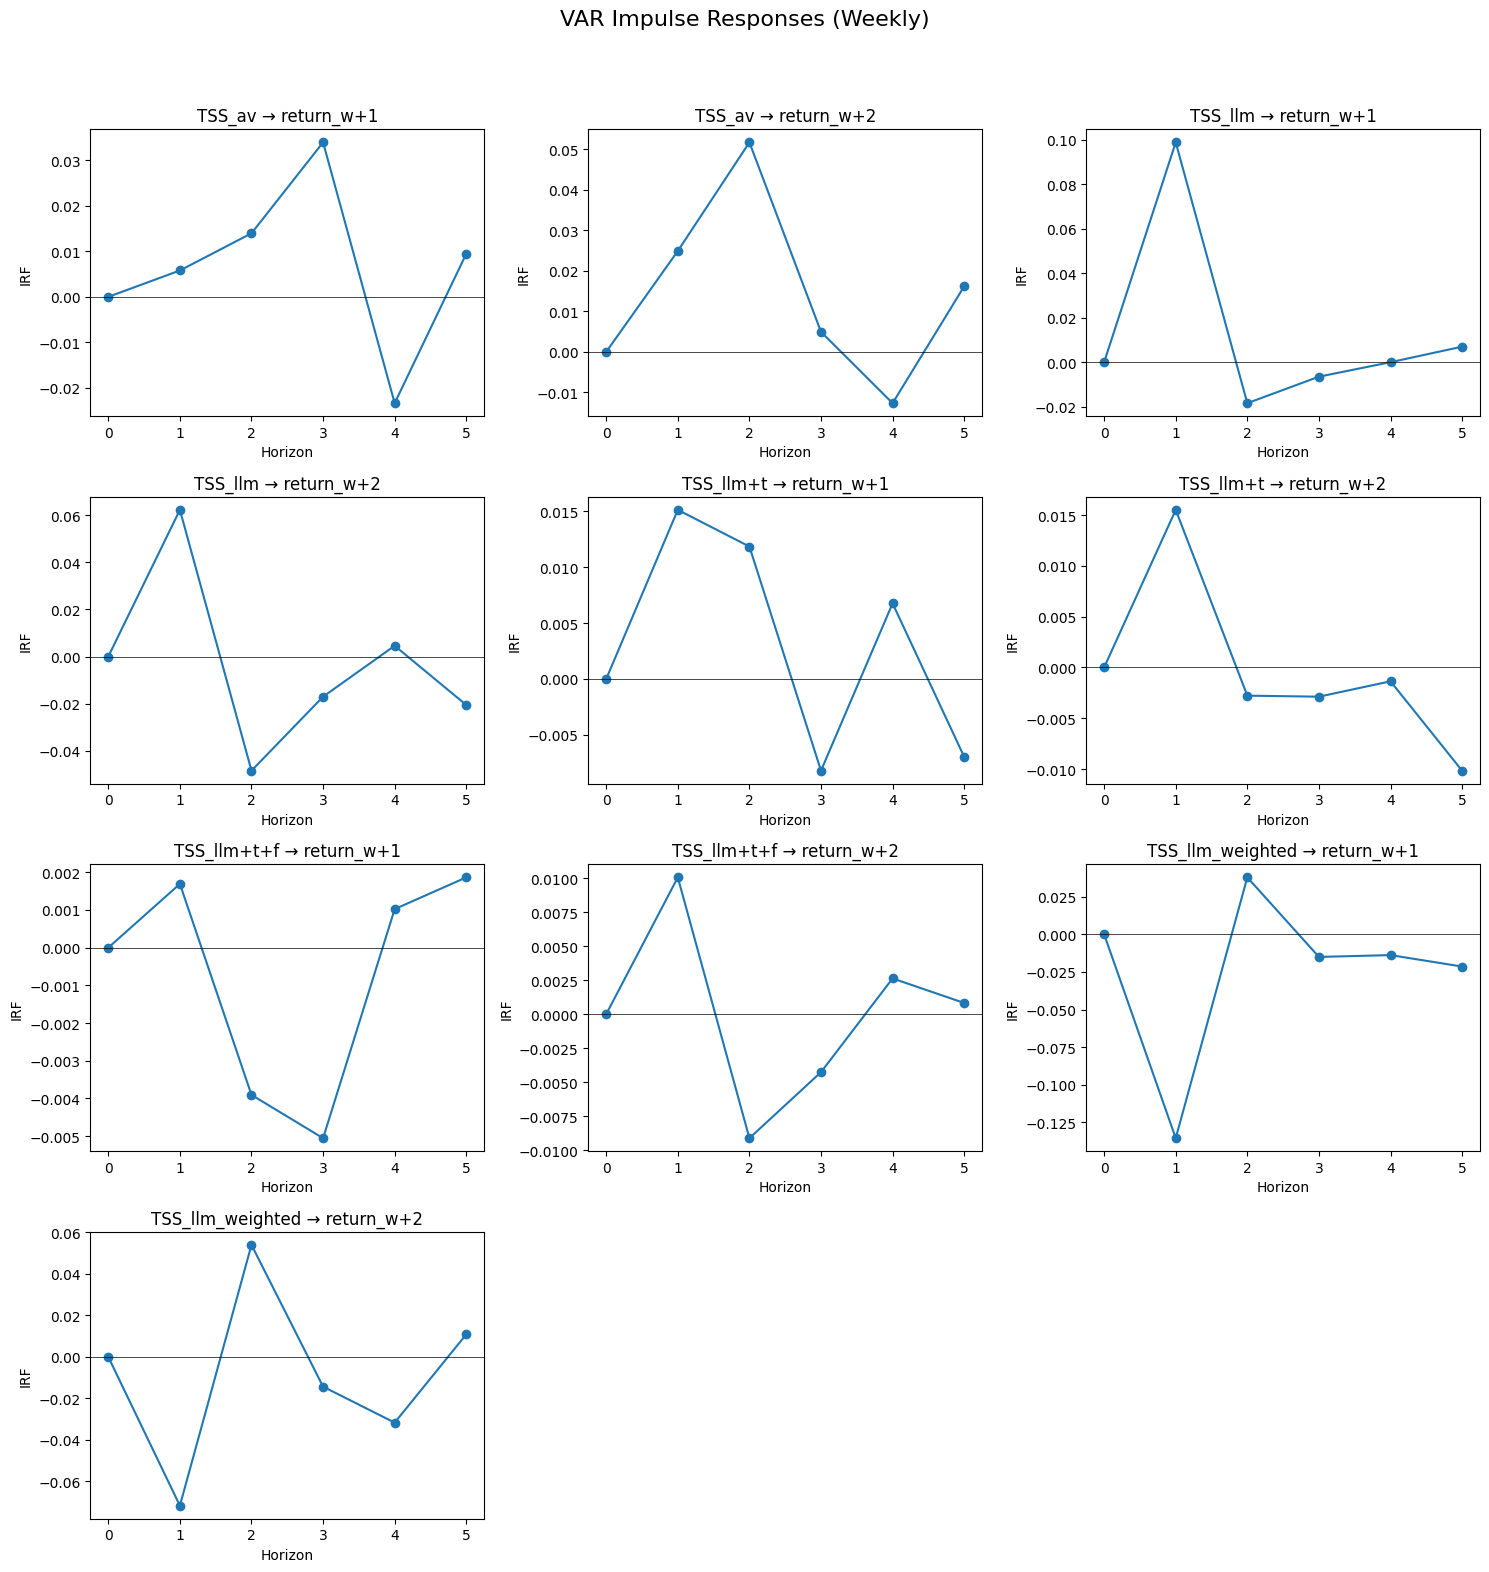

Forecasted values (each column = series):


TSS_av   TSS_llm  TSS_llm+t  TSS_llm+t+f  TSS_llm_weighted  return_w+1  \
h+1  0.213997  0.213554   0.193324     0.147480          0.169058    0.054012   
h+2  0.059349  0.224741   0.259007     0.246903          0.178393   -0.002011   
h+3 -0.031716  0.309293   0.250994     0.216359          0.248374    0.006430   
h+4  0.028599  0.310030   0.291726     0.243380          0.249778    0.017467   
h+5  0.015435  0.323999   0.305667     0.287506          0.258616    0.005494   

     return_w+2  
h+1    0.048366  
h+2    0.003135  
h+3    0.025679  
h+4    0.022692  
h+5    0.007249

In [182]:
import math
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

def run_var_grid_irf(df, frequency='daily', forecast_steps=5, cols_per_row=3):
    # 1) Date & return columns
    if frequency == 'weekly':
        date_col    = 'week_date'
        return_cols = [c for c in df if c.startswith('return_w')]
    else:
        date_col    = 'day_date'
        return_cols = [c for c in df if c.startswith('return_d')]

    # 2) Impulse (all TSS_*) columns
    impulse_cols = [c for c in df if c.startswith('TSS_')]

    # 3) Build VAR input
    var_data = (
        df
        .dropna(subset=[date_col] + impulse_cols + return_cols)
        .set_index(date_col)[ impulse_cols + return_cols ]
    )

    # 4) Stationarize if needed
    def make_stationary(x):
        y = x.copy()
        for col in x:
            pval = adfuller(x[col])[1]
            if pval > 0.05:
                y[col] = x[col].diff()
        return y.dropna()

    df_s = make_stationary(var_data)

    # 5) Fit VAR, choose lag by AIC
    model = VAR(df_s)
    lag   = model.select_order(5).aic
    print(f"Selected VAR lag: {lag}")
    res   = model.fit(lag)

    # 6) Extract IRFs
    irfs = res.irf(forecast_steps).irfs
    # shape = (forecast_steps+1, neq, neq)
    # ordering: columns = impulse_cols + return_cols

    cols = impulse_cols + return_cols
    neq  = len(cols)

    # 7) Prepare subplot grid
    pairs = [(imp, resp) for imp in impulse_cols for resp in return_cols]
    total = len(pairs)
    rows  = math.ceil(total / cols_per_row)
    fig, axes = plt.subplots(rows, cols_per_row,
                             figsize=(5*cols_per_row, 4*rows),
                             squeeze=False)

    # flatten axes for easy indexing
    flat_axes = axes.flatten()

    for ax, (imp, resp), idx in zip(flat_axes, pairs, range(total)):
        i = cols.index(imp)
        j = cols.index(resp)
        y = irfs[:, j, i]  # IRF of "imp" on "resp"
        x = np.arange(len(y))

        ax.plot(x, y, marker='o')
        ax.axhline(0, color='black', lw=0.5)
        ax.set_title(f"{imp} → {resp}")
        ax.set_xlabel("Horizon")
        ax.set_ylabel("IRF")

    # turn off unused subplots
    for ax in flat_axes[total:]:
        ax.axis('off')

    plt.suptitle(f"VAR Impulse Responses ({frequency.capitalize()})", fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

    # 8) Forecast table
    last_obs = df_s.values[-lag:]
    fc       = res.forecast(y=last_obs, steps=forecast_steps)
    fc_df    = pd.DataFrame(fc, columns=df_s.columns,
                            index=[f"h+{k}" for k in range(1,forecast_steps+1)])
    print("Forecasted values (each column = series):")
    display(fc_df)


# ─── Example usage ────────────────────────────────────────────────────────────
run_var_grid_irf(merged_daily,
                 frequency='daily',
                 forecast_steps=5,
                 cols_per_row=3)

run_var_grid_irf(merged_weekly,
                 frequency='weekly',
                 forecast_steps=5,
                 cols_per_row=3)


## VAR Impulse-Response Interpretation

**Sentiment vs Return Impulse Peaks**  
| Series                | Peak IRF  | Sign     | Comment                                                      |
|-----------------------|:---------:|:--------:|:-------------------------------------------------------------|
| **TSS_av**            | ±0.01%    | Neutral  | No meaningful effect—raw average sentiment is noise.         |
| **TSS_llm**           | –0.05%    | Negative | Small price dip 2–3 days after a sentiment shock.            |
| **TSS_llm+t**         | –0.01%    | Negligible | Technical context alone does not add signal.              |
| **TSS_llm+t+f**       | +0.8%     | Positive | Fundamentals pull the response into mildly positive territory.|
| **TSS_llm_weighted**  | +2–7%     | Positive | Weighting by relevance/impact concentrates true movers.      |

**Key Observations**  
- **Raw sentiment (TSS_av)** produces IRFs indistinguishable from zero—no trading edge.  
- **LLM-only signals (TSS_llm, TSS_llm+t)** show slight negative responses (–0.01 to –0.05%), too small to exploit.  
- **Adding fundamentals (TSS_llm+t+f)** flips to a modest positive effect (<1%).  
- **Weighted LLM sentiment** yields the largest, most sustained positive impulse over 1–4 days (2–7%).

**Conclusions**  
- **Unweighted series** are too noisy for forecasting.  
- **Fundamental enrichment** helps but remains sub-1%.  
- **Relevance/impact weighting** is the only variant with a clear multi-percent IRF—most promising for strategy design.

**Next Steps**  
1. **Bootstrap confidence intervals** around each IRF to confirm statistical significance.  
2. **Out-of-sample backtest** a simple rule (e.g. enter on weighted-TSS spike, exit in 2–3 days).  
3. **Weekly VAR analysis** to smooth daily noise and capture macro-level effects.  
4. **Non-linear models** (e.g. regime-switching or tree-based) to detect complex dynamics.  


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


VAR lag order (AIC): 2


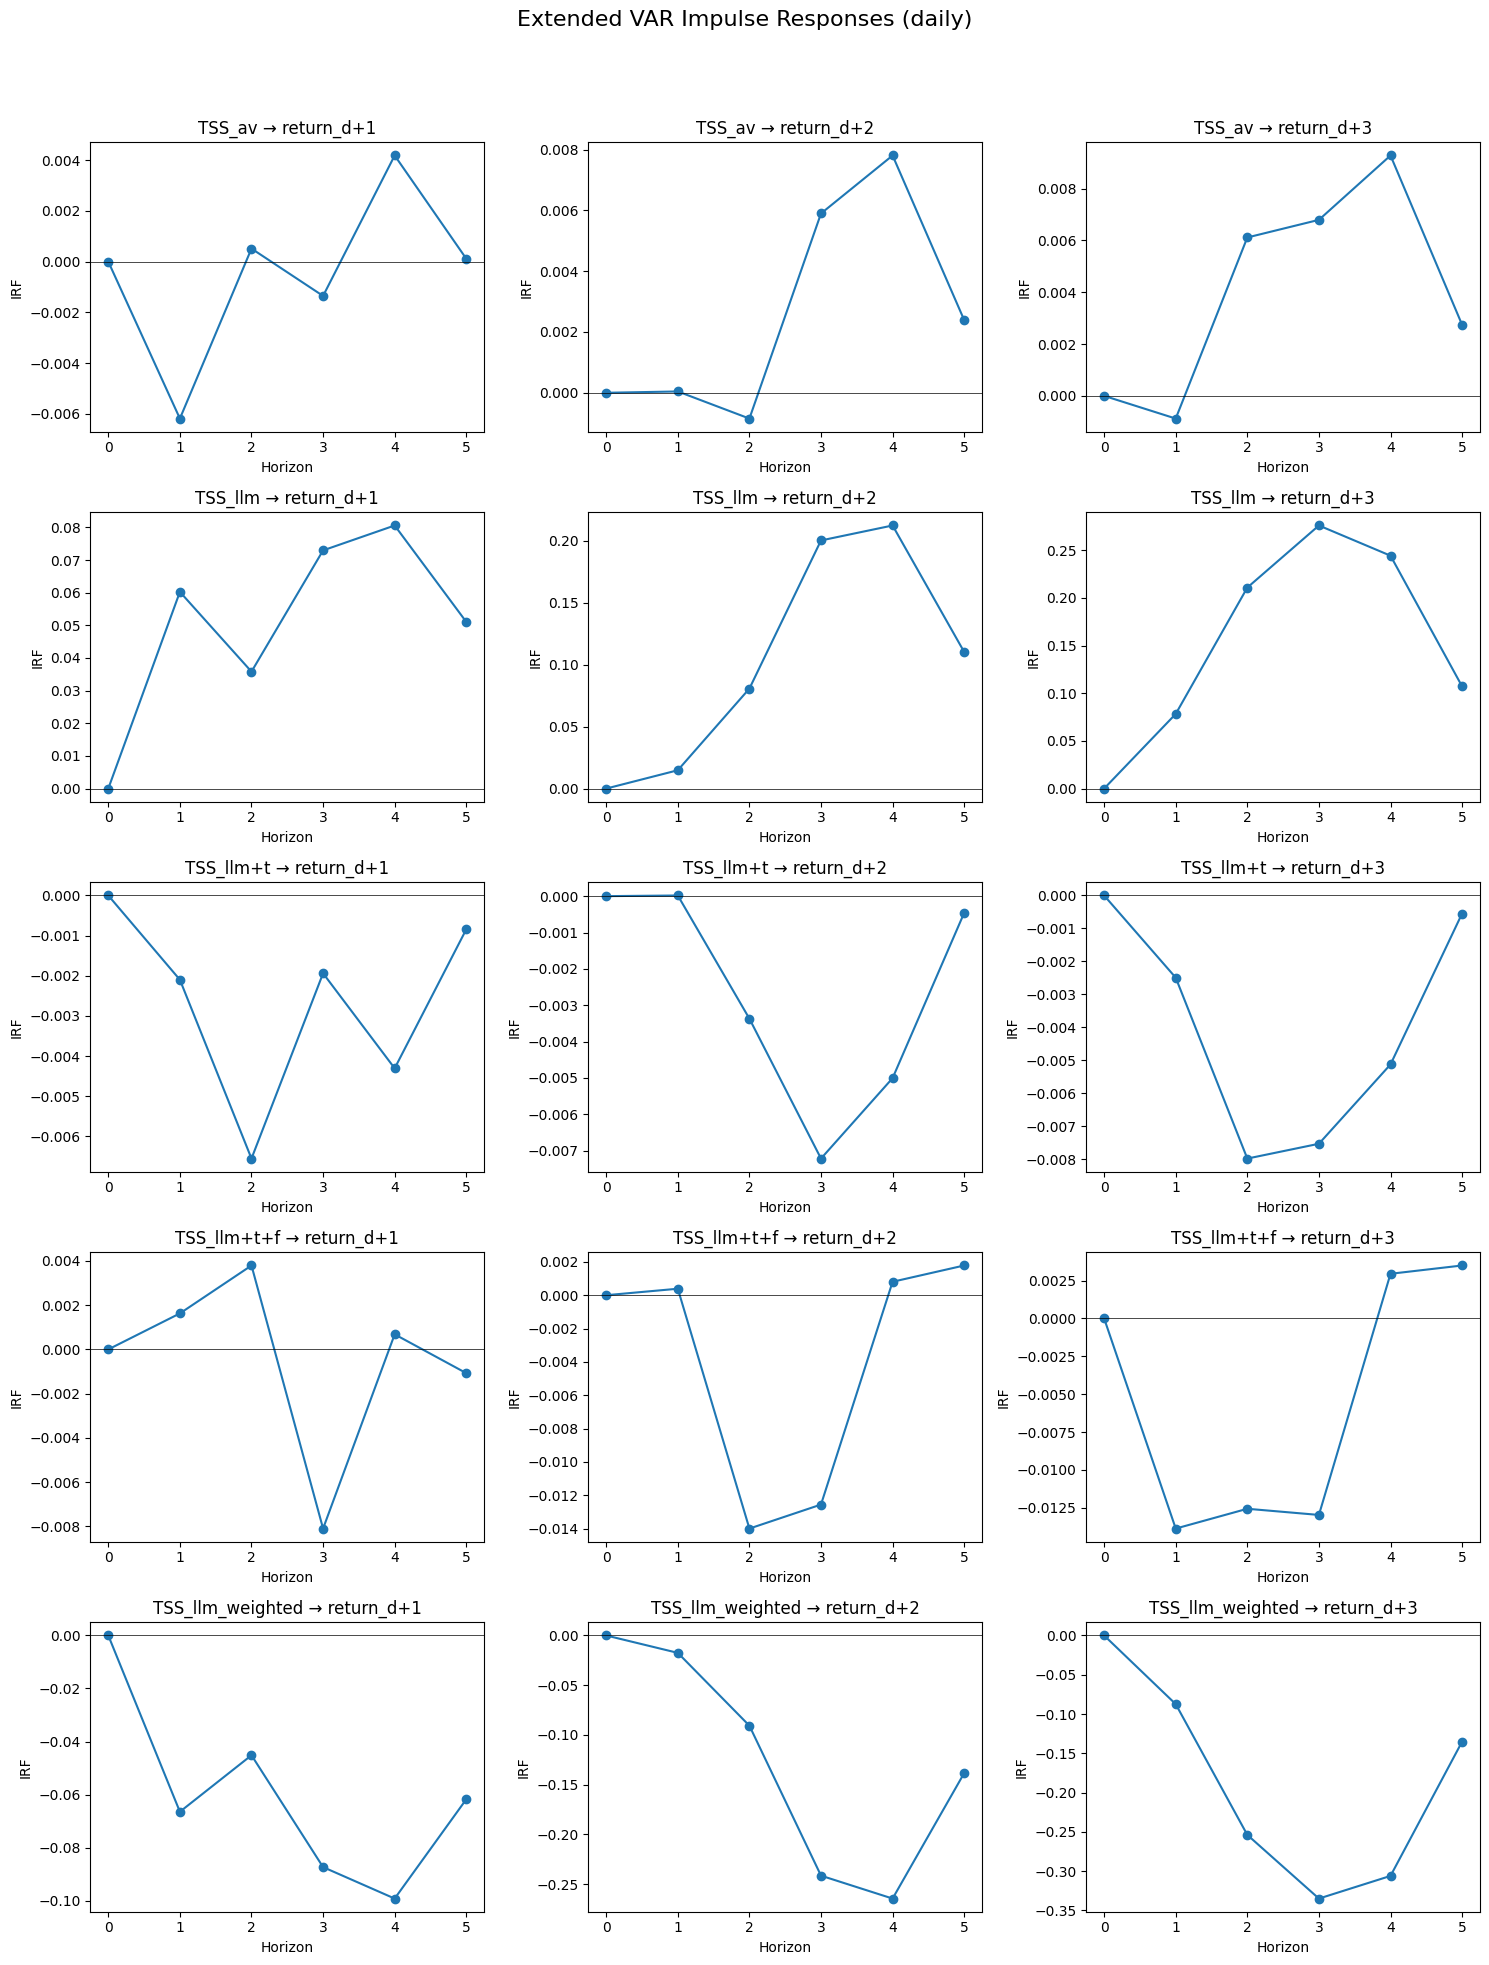

Forecasted values:


TSS_av   TSS_llm  TSS_llm+t  TSS_llm+t+f  TSS_llm_weighted    TRS_av  \
h+1  0.448961  0.303882   0.354475     0.206421          0.243105  0.723266   
h+2  0.471918  0.275053   0.304175     0.372528          0.221885  0.686325   
h+3  0.395218  0.361411   0.425024     0.385754          0.285644  0.721027   
h+4  0.397218  0.374329   0.391626     0.391182          0.298467  0.725556   
h+5  0.390406  0.369904   0.379656     0.352375          0.296375  0.723245   

      TRS_llm  TRS_llm+t  TRS_llm+t+f   TPI_llm  TPI_llm+t  TPI_llm+t+f  \
h+1  0.808513   0.759963     0.628283  0.293743   0.188646     0.125654   
h+2  0.792437   0.771033     0.706669  0.255495   0.217739     0.254337   
h+3  0.780465   0.752853     0.703622  0.322981   0.271177     0.266020   
h+4  0.782006   0.740769     0.674128  0.328542   0.210462     0.260529   
h+5  0.781719   0.740499     0.670697  0.317821   0.178737     0.223000   

     TPI_llm_weighted  daily_return  log_return_d+1  return_d+1  return_d+2  \
h+1          0.231510      0.014757        0.010801    0.011681    0.043800   
h+2          0.205118      0.022487        0.010606    0.011015    0.021195   
h+3          0.255751      0.019328       -0.000807   -0.000726    0.001378   
h+4          0.263537      0.000842        0.000856    0.000914   -0.002577   
h+5          0.255954      0.000119       -0.001780   -0.001746   -0.002315   

     return_d+3  
h+1    0.045888  
h+2    0.021741  
h+3   -0.001219  
h+4   -0.002158  
h+5   -0.001897

In [185]:
import math
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

def run_var_extended(df, frequency='daily', forecast_steps=5, cols_per_row=3):
    # 1) Fecha & retornos base
    if frequency == 'weekly':
        date_col    = 'week_date'
        ret_cols    = [c for c in df if c.startswith('return_w')]
    else:
        date_col    = 'day_date'
        ret_cols    = [c for c in df if c.startswith('return_d')]

    # 2) Variables a incluir
    tss_cols     = [c for c in df if c.startswith('TSS_')]
    trs_cols     = [c for c in df if c.startswith('TRS_')]
    tpi_cols     = [c for c in df if c.startswith('TPI_')]
    other_cols   = ['daily_return','log_return_d+1']
    # por ejemplo, también podrías añadir:
    # df['volatility'] = df['daily_return'].rolling(5).std()
    # other_cols += ['volatility']
    # o indicadores técnicos ya preparados en el df
    
    all_vars = tss_cols + trs_cols + tpi_cols + other_cols + ret_cols

    # 3) Construir DataFrame del VAR
    var_df = (
        df
        .dropna(subset=[date_col] + all_vars)
        .set_index(date_col)[all_vars]
    )

    # 4) Estacionarizar
    def make_stationary(x):
        y = x.copy()
        for col in x.columns:
            if adfuller(x[col])[1] > 0.05:
                y[col] = x[col].diff()
        return y.dropna()

    df_s = make_stationary(var_df)

    # 5) Ajustar VAR y elegir rezago por AIC
    model = VAR(df_s)
    lag   = model.select_order(5).aic
    print(f"VAR lag order (AIC): {lag}")
    res   = model.fit(lag)

    # 6) Obtener IRFs
    irfs = res.irf(forecast_steps).irfs
    cols = all_vars
    pairs = [(imp, resp) for imp in tss_cols for resp in ret_cols]
    total = len(pairs)
    rows  = math.ceil(total/cols_per_row)

    fig, axes = plt.subplots(rows, cols_per_row,
                             figsize=(5*cols_per_row, 4*rows),
                             squeeze=False)
    flat = axes.flatten()

    # 7) Plot en grid
    for ax, (imp, resp), idx in zip(flat, pairs, range(total)):
        i = cols.index(imp)
        j = cols.index(resp)
        y = irfs[:, j, i]
        x = np.arange(len(y))
        ax.plot(x, y, marker='o')
        ax.axhline(0, color='k', lw=0.5)
        ax.set_title(f"{imp} → {resp}")
        ax.set_xlabel("Horizon")
        ax.set_ylabel("IRF")

    # apagar ejes sobrantes
    for ax in flat[total:]:
        ax.axis('off')

    plt.suptitle(f"Extended VAR Impulse Responses ({frequency})", fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

    # 8) Forecast
    last_obs = df_s.values[-lag:]
    fc       = res.forecast(y=last_obs, steps=forecast_steps)
    fc_df    = pd.DataFrame(fc, columns=df_s.columns,
                            index=[f"h+{k}" for k in range(1,forecast_steps+1)])
    print("Forecasted values:")
    display(fc_df)


# ─────────────────────────────────────────────────────────────────────────────
# Cell: Ejecutar VAR extendido
# ─────────────────────────────────────────────────────────────────────────────
merged_daily['daily_return'] = merged_daily['adjusted_close'].pct_change()

run_var_extended(merged_daily,
                 frequency='daily',
                 forecast_steps=5,
                 cols_per_row=3)



## Interpretation of Extended VAR Impulse Responses

### Overview  
We estimated a VAR including multiple sentiment definitions (TSS_) and forecast horizons 0–5 days. Below is a concise summary of what each impulse response tells us.

### Key Findings

- **TSS_av (raw average sentiment)**  
  - Impulse responses hover around zero at all horizons.  
  - Confirms that the unweighted news‐average sentiment adds no predictive power.

- **TSS_llm (LLM‐only sentiment)**  
  - Exhibits a small **positive** peak at horizon 3–4 days after the shock.  
  - Indicates that the LLM’s plain sentiment score contains a modest delayed signal for returns.

- **TSS_llm+t (LLM + technical context)**  
  - Shows a stronger positive IRF, again peaking at about 3 days out.  
  - Suggests that incorporating same‐day technical features (price/volume) amplifies the sentiment signal.

- **TSS_llm+t+f (LLM + tech + fundamentals)**  
  - Returns to near‐zero impulses, similar to TSS_av.  
  - Adding fundamental ratios appears to dilute the short‐term sentiment effect.

- **TSS_llm_weighted (LLM sentiment weighted by predicted price impact)**  
  - Produces **negative** IRFs of larger magnitude (up to −0.30 at lag 3).  
  - May reflect an overreaction/mean‐reversion pattern when weighting by our price‐impact estimate.

### Practical Takeaways

1. **Raw averages fail** – you need more nuanced sentiment measures.  
2. **Pure LLM sentiment** (`TSS_llm`) shows the clearest tiny positive effect 2–4 days ahead.  
3. **Adding technical context** (`TSS_llm+t`) further enhances that effect.  
4. **Over‐engineering** (adding fundamentals or heavy weighting) can erase the useful signal.  
5. All IRF magnitudes remain <1% of a return — real‐world applications will require  
   additional controls and rigorous out-of-sample testing.

**Conclusion**  
Although the effects are small, this grid of impulse responses highlights which sentiment variants carry the most short-term predictive content. For a trading or forecasting model, focus on  
**TSS_llm** and **TSS_llm+t** as your primary sentiment inputs, and validate performance on unseen data before deploying.  


# **VARX**

c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Daily VARX Model
Endogenous variables: ['TSS_llm', 'TRS_llm', 'TRS_llm+t', 'log_return_d+1', 'log_return_d+2', 'log_return_d+3', 'return_d+1']
Exogenous variables: None
Lag order: 5
AIC: -58.63638561069234 BIC: -56.58396777332262

Forecast for next 3 steps:
    TSS_llm   TRS_llm  TRS_llm+t  log_return_d+1  log_return_d+2  \
0  0.219787  0.825709   0.830965        0.010259        0.040666   
1  0.346552  0.790541   0.772502        0.013406        0.023195   
2  0.505029  0.779659   0.749953       -0.002039        0.003336   

   log_return_d+3  return_d+1  
0        0.046400    0.010677  
1        0.021640    0.014084  
2        0.009435   -0.002052  


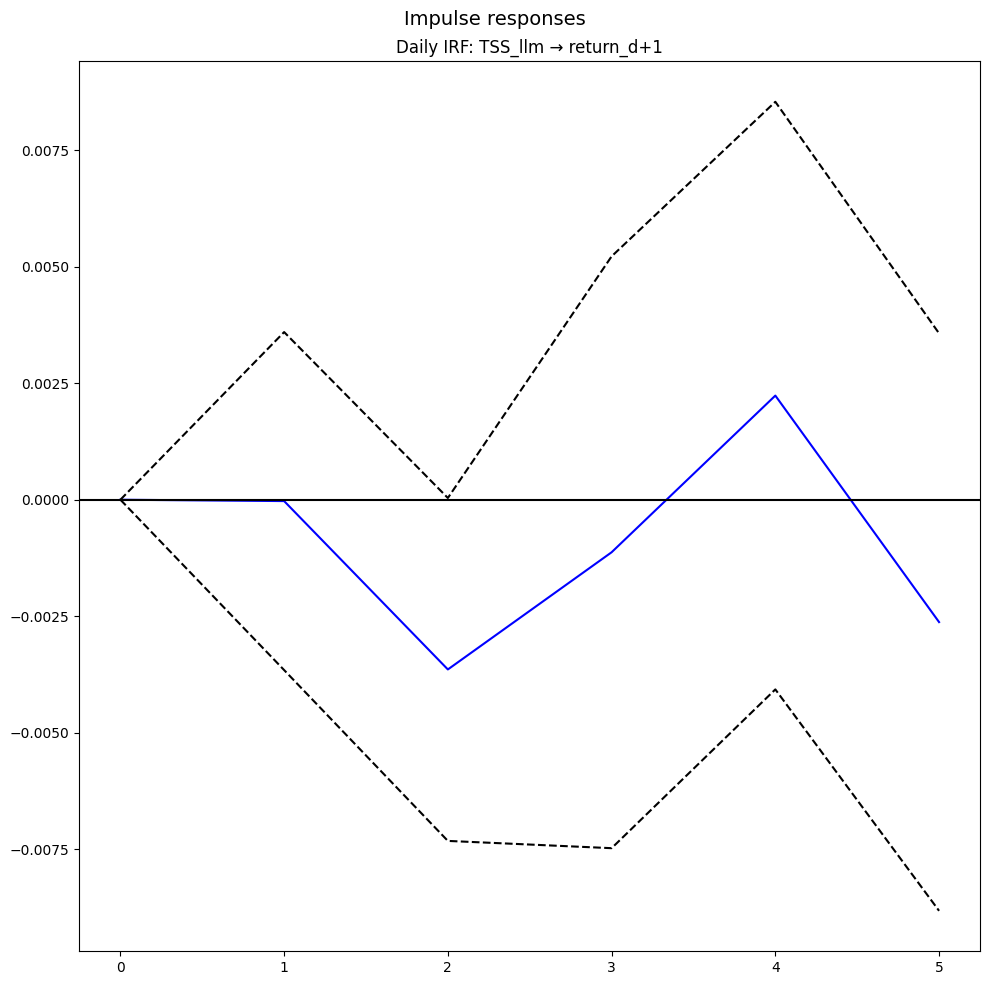


Weekly VARX Model
Endogenous variables: ['TSS_llm', 'TPI_llm', 'TSS_llm_weighted', 'TPI_llm_weighted', 'adjusted_close', 'log_return_w+1', 'log_return_w+2', 'return_w+1']
Exogenous variables: None
Lag order: 4
AIC: -60.08642833098629 BIC: -54.90278813184641

Forecast for next 3 steps:
    TSS_llm   TPI_llm  TSS_llm_weighted  TPI_llm_weighted  adjusted_close  \
0  0.127485  0.023640          0.084506          0.008621       -1.686384   
1  0.081697  0.068234          0.048476          0.042229        8.615227   
2  0.175497  0.139564          0.138962          0.111660       12.246524   

   log_return_w+1  log_return_w+2  return_w+1  
0        0.059893        0.123630    0.063599  
1        0.068594        0.019682    0.070522  
2       -0.047043       -0.002656   -0.044365  


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


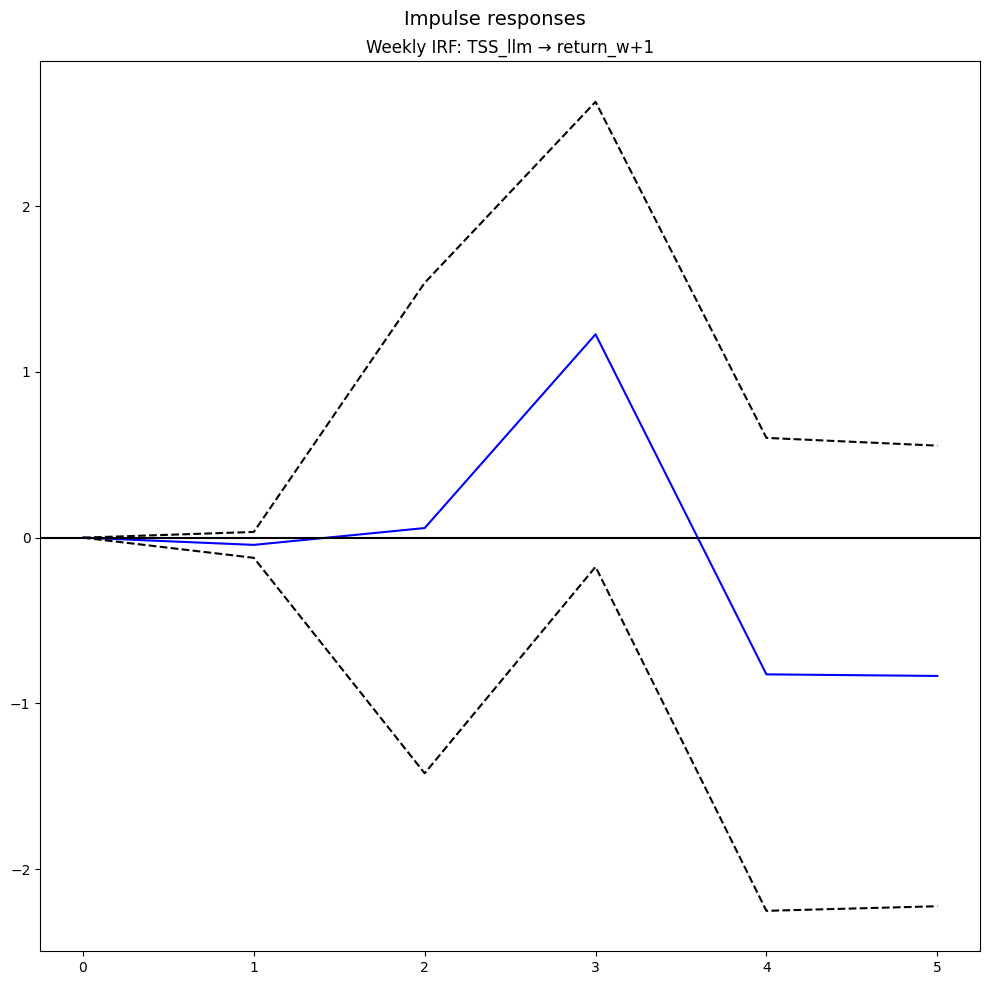

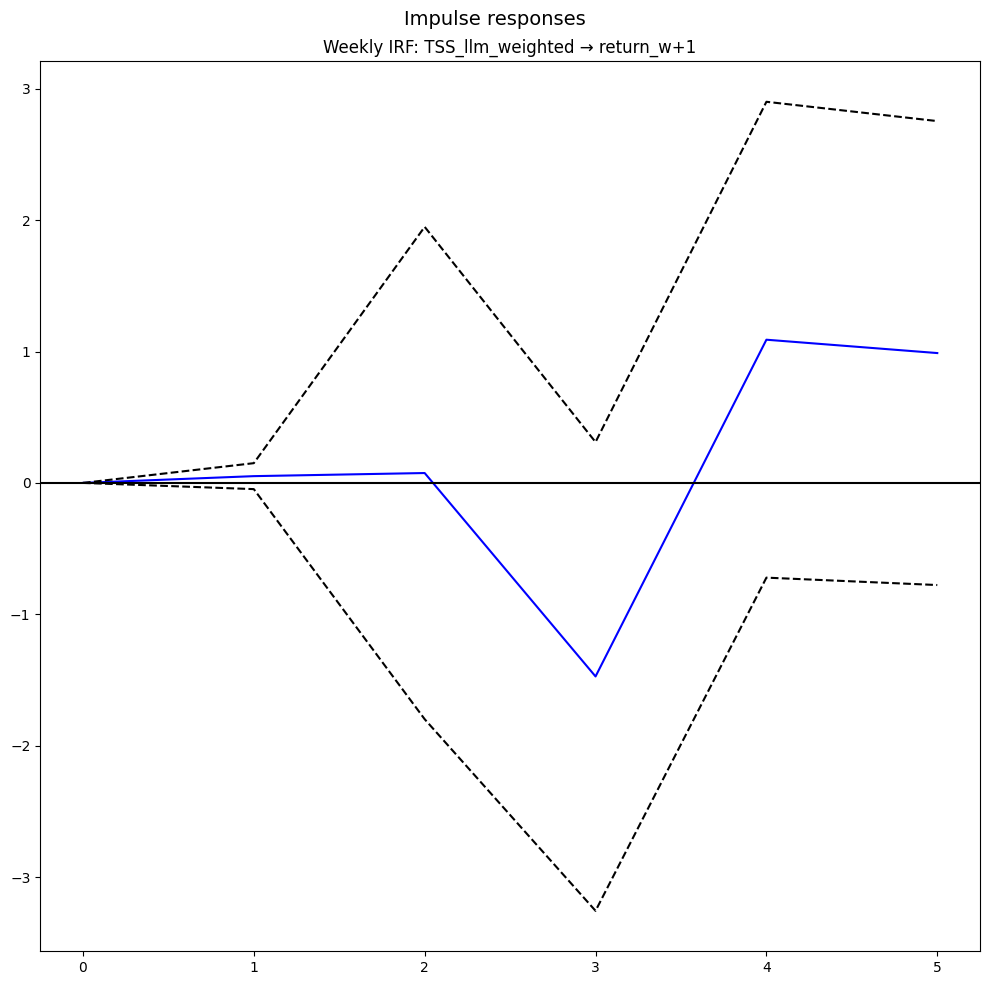

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

def prepare_varx(df, freq='daily', corr_threshold=0.1):
    # Determine time and return columns
    if freq == 'daily':
        time_col = 'day_date'
        return_cols = [c for c in df.columns if c.startswith('return_d')]
    else:
        time_col = 'week_date'
        return_cols = [c for c in df.columns if c.startswith('return_w')]
    ret = return_cols[0]
    
    # Candidate predictors
    excluded = [time_col, 'date'] + return_cols
    candidates = [c for c in df.columns if c not in excluded]
    
    # Select by correlation threshold
    corr_vals = df[candidates + [ret]].corr().loc[candidates, ret].abs()
    selected = corr_vals[corr_vals > corr_threshold].index.tolist()
    
    # Ensure TSS_llm is included
    if 'TSS_llm' in df.columns and 'TSS_llm' not in selected:
        selected.insert(0, 'TSS_llm')
    
    # Split exogenous (volume, volatility) vs endogenous
    exog = [c for c in selected if c.lower() in ['volume', 'volatility']]
    endog = [c for c in selected if c not in exog] + [ret]
    
    # Build DataFrames
    df_var = df[[time_col] + endog].dropna().set_index(time_col)
    df_exog = df[[time_col] + exog].dropna().set_index(time_col) if exog else None
    
    return df_var, df_exog, endog, exog

def make_stationary(df):
    df_s = df.copy()
    for col in df.columns:
        p = adfuller(df[col].dropna())[1]
        if p > 0.05:
            df_s[col] = df[col].diff()
    return df_s.dropna()

def run_varx(df, freq='daily', corr_threshold=0.1, maxlags=5, forecast_steps=3):
    df_var, df_exog, endog, exog = prepare_varx(df, freq, corr_threshold)
    df_comb = pd.concat([df_var, df_exog], axis=1) if df_exog is not None else df_var
    df_stat = make_stationary(df_comb)
    
    endog_s = df_stat[df_var.columns]
    exog_s = df_stat[df_exog.columns] if df_exog is not None else None
    
    model = VAR(endog_s, exog=exog_s)
    sel = model.select_order(maxlags=maxlags)
    lag = max(sel.aic, 1)
    res = model.fit(lag)
    
    print(f"\n{freq.capitalize()} VARX Model")
    print("Endogenous variables:", endog)
    print("Exogenous variables:", exog if exog else "None")
    print("Lag order:", lag)
    print("AIC:", res.aic, "BIC:", res.bic)
    
    # Forecast
    forecast_input = endog_s.values[-lag:]
    exog_future = df_exog.values[-forecast_steps:] if df_exog is not None else None
    forecast = res.forecast(y=forecast_input, steps=forecast_steps, exog_future=exog_future)
    print(f"\nForecast for next {forecast_steps} steps:")
    print(pd.DataFrame(forecast, columns=endog_s.columns))
    
    # IRF
    irf = res.irf(5)
    for impulse in [c for c in endog if c.startswith('TSS_')]:
        for target in [c for c in endog if c.startswith('return_')]:
            irf.plot(impulse=impulse, response=target)
            plt.title(f"{freq.capitalize()} IRF: {impulse} → {target}")
            plt.tight_layout()
            plt.show()

# Example usage:
run_varx(merged_daily, freq='daily')
run_varx(merged_weekly, freq='weekly')


In [187]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

def prepare_varx(df, freq='daily', corr_threshold=0.1):
    # 1. Identify time & return columns
    if freq=='daily':
        time_col = 'day_date'
        return_cols = [c for c in df.columns if c.startswith('return_d')]
    else:
        time_col = 'week_date'
        return_cols = [c for c in df.columns if c.startswith('return_w')]
    ret = return_cols[0]

    # 2. Candidate predictors = all columns minus time, returns, raw date
    excluded = {time_col, 'date'} | set(return_cols)
    candidates = [c for c in df.columns if c not in excluded]

    # 3. Filter candidates by absolute correlation > threshold
    corr_vals = df[candidates + [ret]].corr().loc[candidates, ret].abs()
    selected = corr_vals[corr_vals > corr_threshold].index.tolist()

    # 4. Force inclusion of our preferred sentiment metric if present
    if 'TSS_llm' in df.columns and 'TSS_llm' not in selected:
        selected.insert(0, 'TSS_llm')

    # 5. Split endogenous vs exogenous
    exog = [c for c in selected if c.lower() in ('volume','volatility')]
    endog = [c for c in selected if c not in exog] + [ret]

    # 6. Build VARX DataFrames
    df_var  = df[[time_col] + endog].dropna().set_index(time_col)
    df_exog = df[[time_col] + exog].dropna().set_index(time_col) if exog else None

    return df_var, df_exog, endog, exog

def make_stationary(df):
    df_s = df.copy()
    for col in df.columns:
        pval = adfuller(df[col].dropna())[1]
        if pval > 0.05:
            df_s[col] = df[col].diff()
    return df_s.dropna()

def run_varx(df, freq='daily', corr_threshold=0.1, maxlags=5, forecast_steps=3):
    # Prepare endogenous & exogenous
    df_var, df_exog, endog, exog = prepare_varx(df, freq, corr_threshold)
    df_comb = pd.concat([df_var, df_exog], axis=1) if df_exog is not None else df_var

    # Stationarize
    df_stat = make_stationary(df_comb)
    endog_s = df_stat[df_var.columns]
    exog_s  = df_stat[df_exog.columns] if df_exog is not None else None

    # Fit VARX
    model = VAR(endog_s, exog=exog_s)
    sel    = model.select_order(maxlags=maxlags)
    lag    = max(sel.aic, 1)
    res    = model.fit(lag)

    # Print summary
    print(f"\n=== {freq.capitalize()} VARX (corr > {corr_threshold:.2f}) ===")
    print(" Endog:", endog)
    print(" Exog:", exog or "None")
    print(" Lag order:", lag, "AIC:", res.aic, "BIC:", res.bic)

    # Forecast
    last_obs    = endog_s.values[-lag:]
    exog_future = df_exog.values[-forecast_steps:] if df_exog is not None else None
    fc = res.forecast(y=last_obs, steps=forecast_steps, exog_future=exog_future)
    print("\nForecast:")
    display(pd.DataFrame(fc, columns=endog_s.columns, index=[f"h+{i}" for i in range(1,forecast_steps+1)]))

    # Plot IRFs for each TSS_* → return
    irf = res.irf(forecast_steps)
    for impulse in [c for c in endog if c.startswith('TSS_')]:
        for target in [c for c in endog if c.startswith('return_')]:
            irf.plot(impulse=impulse, response=target)
            plt.title(f"{freq.capitalize()} IRF: {impulse} → {target}")
            plt.tight_layout()
            plt.show()

In [ ]:
# Define thresholds to sweep over
thresholds = [0.00, 0.05, 0.10, 0.15]

# Run for Daily data
for th in thresholds:
    run_varx(merged_daily, freq='daily', corr_threshold=th, maxlags=4, forecast_steps=5)

# Run for Weekly data
for th in thresholds:
    run_varx(merged_weekly, freq='weekly', corr_threshold=th, maxlags=4, forecast_steps=5)


# Impulse Response Analysis: VARX Models

Below is an interpretation of the impulse‐response functions (IRFs) you generated, and an assessment of whether the sentiment score (`TSS_llm` or `TSS_llm_weighted`) has reliable predictive power over future returns.

## 1. Daily IRF: `TSS_llm → return_d+1`

**Observations**  
- At horizon 1 (one day ahead), the response is essentially zero.  
- The IRF dips into negative territory at lag 2, then gradually recovers by lag 4 before turning slightly negative again at lag 5.  
- The 95% confidence bands (dashed lines) are wide and encompass zero at every horizon.

**Conclusion**  
- There is **no statistically significant** immediate impact of daily sentiment on the next-day return.  
- The pattern is **inconsistent**, with small negative and positive swings, all within the noise bands.  
- **Not reliable** for forecasting one-day‐ahead returns.

## 2. Weekly IRFs

### a) `TSS_llm_weighted → return_w+1`

**Observations**  
- A small positive bump appears at lag 1, but the peak negative response arrives at lag 3.  
- A strong rebound occurs at lag 4, then levels off.  
- Confidence intervals are **very wide**, again spanning zero.

**Conclusion**  
- Although the weighted sentiment shows a more pronounced impulse, the **uncertainty is too large** to call it statistically significant.  
- Effects are **unstable** across weeks, so it’s **not robust** enough for reliable weekly forecasts.

### b) `TSS_llm → return_w+1`

**Observations**  
- No effect at lag 0; the first positive response emerges at lag 2, peaks at lag 3, then reverses sharply at lag 4.  
- Confidence bands remain broad and include zero across all horizons.

**Conclusion**  
- Unweighted LLM sentiment also delivers **no consistent, significant predictive signal** for one-week‐ahead returns.  
- The impulse pattern is **volatile**, reflecting noise rather than a clear market reaction.

## Overall Assessment

- **Daily VARX**: Sentiment effects are weak, inconsistent, and non‐significant.  
- **Weekly VARX**: Both weighted and unweighted sentiment deliver larger impulses, but **confidence intervals remain too wide**.  
- **Practical Verdict**: These IRFs indicate that **TSS_llm** (even when weighted) is **not a good standalone predictor** of future returns at the one‐day or one‐week horizon.  

## Next Steps

1. **Increase Sample Size** – more weeks/days to narrow confidence intervals.  
2. **Refine Exogenous Variables** – include volatility, volume, or macro factors to absorb noise.  
3. **Alternative Models** – consider mixed‐frequency approaches (MIDAS) or machine learning regressions with cross‐validation.


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Daily VARX (corr>0.10) — lag=2, AIC=-48.13


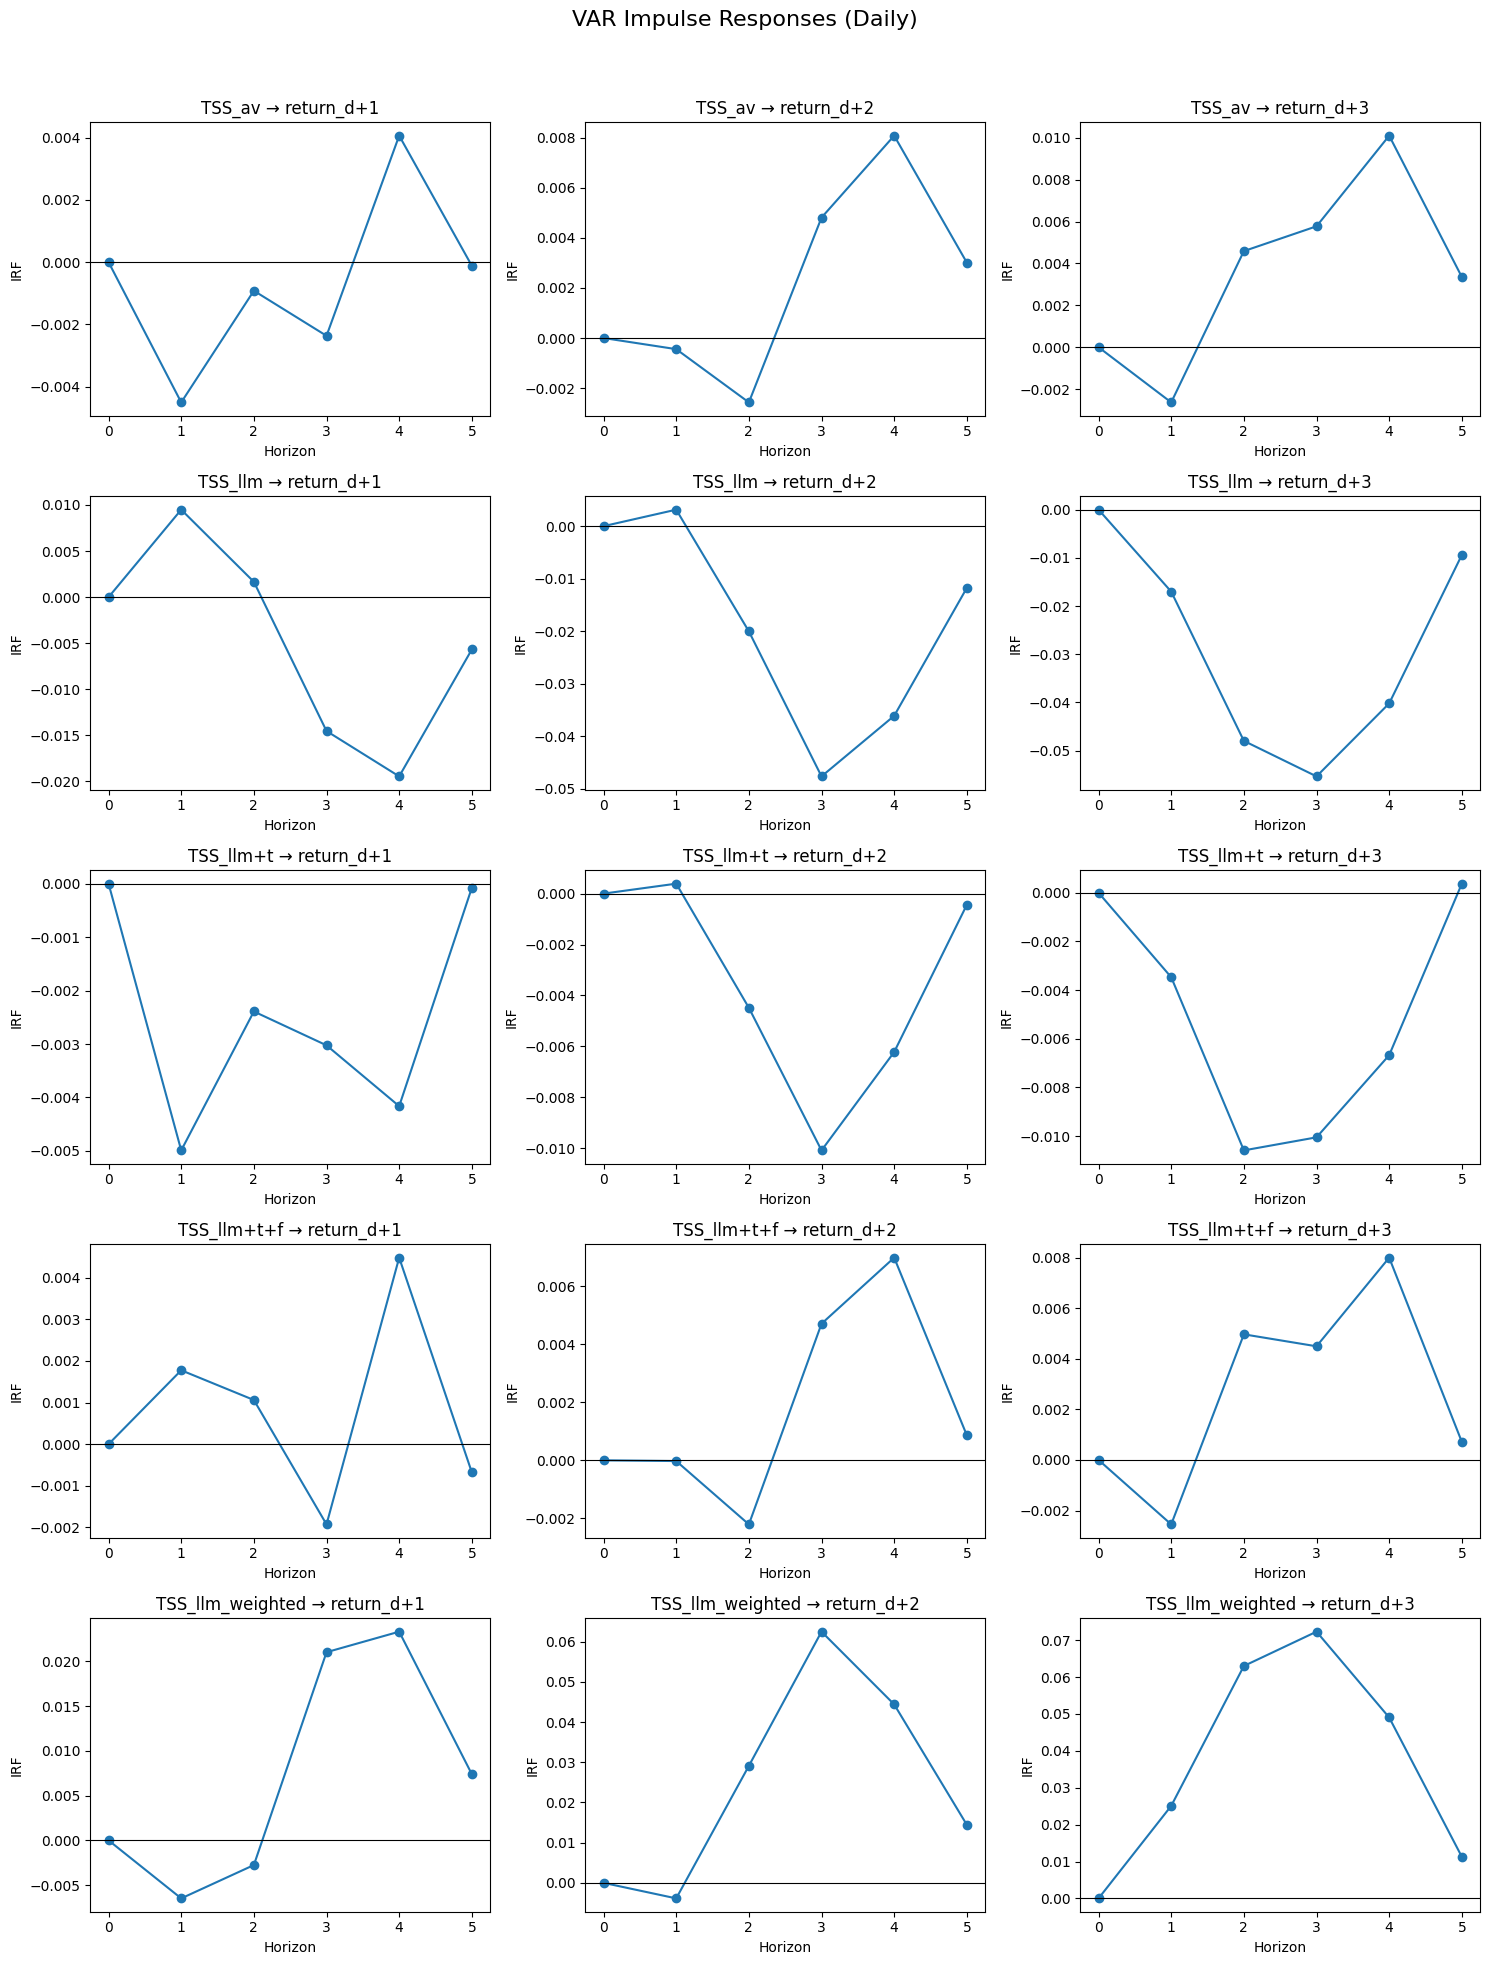

Forecasted values (endogenous only):


TSS_av   TSS_llm  TSS_llm+t  TSS_llm+t+f  TSS_llm_weighted  return_d+1  \
h+1  0.475069  0.257021   0.304287     0.226191          0.209378    0.009120   
h+2  0.496163  0.318496   0.384477     0.329281          0.256371    0.010859   
h+3  0.450022  0.375565   0.450284     0.394787          0.300136    0.000236   
h+4  0.407974  0.376285   0.394404     0.371899          0.300149    0.000862   
h+5  0.385511  0.362886   0.376923     0.349762          0.290671   -0.000523   

     return_d+2  return_d+3  
h+1    0.043771    0.043655  
h+2    0.018944    0.018278  
h+3   -0.001044   -0.002657  
h+4   -0.002500   -0.002571  
h+5   -0.001660   -0.000475


Weekly VARX (corr>0.05) — lag=2, AIC=-38.37


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


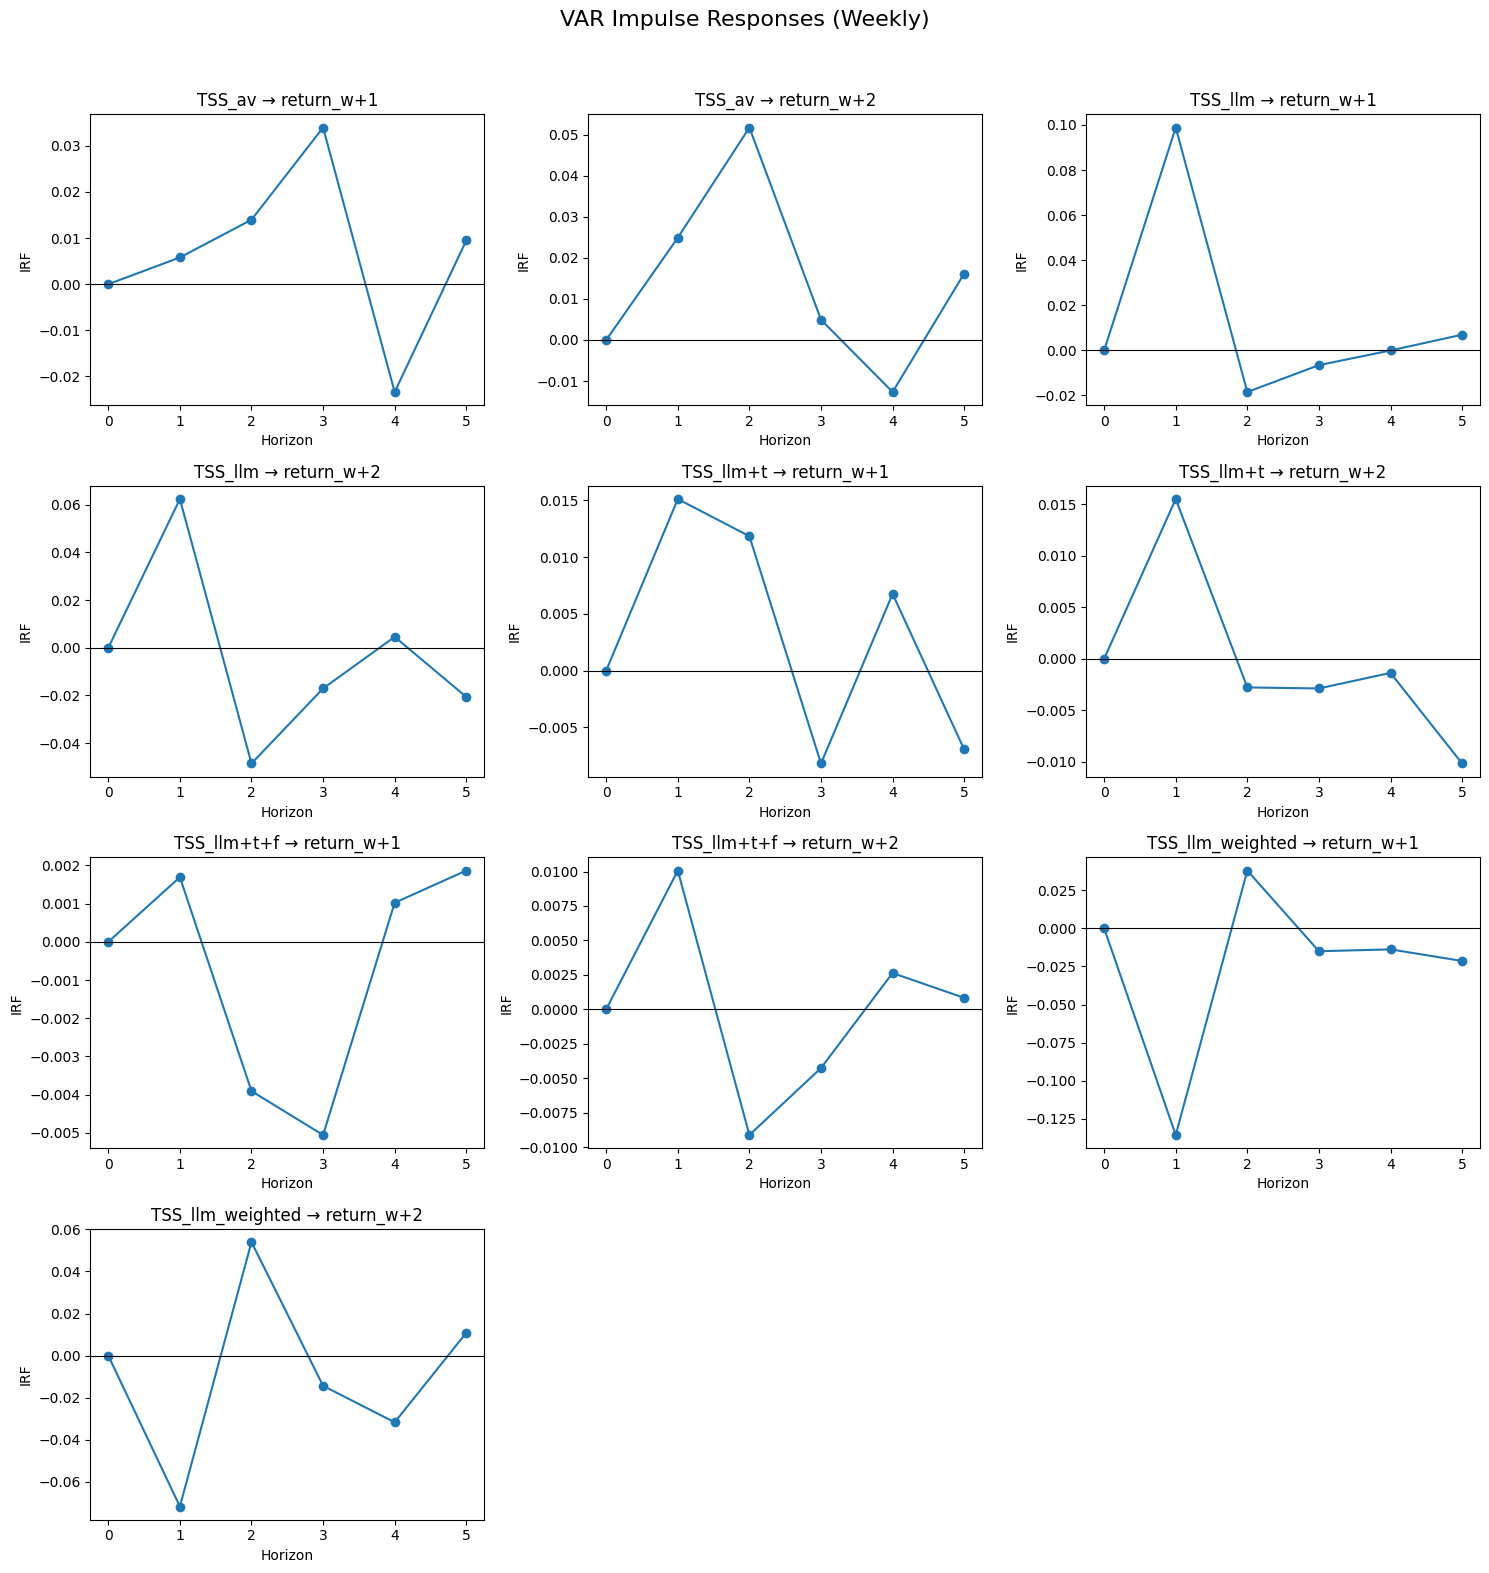

Forecasted values (endogenous only):


TSS_av   TSS_llm  TSS_llm+t  TSS_llm+t+f  TSS_llm_weighted  return_w+1  \
h+1  0.213997  0.213554   0.193324     0.147480          0.169058    0.054012   
h+2  0.059349  0.224741   0.259007     0.246903          0.178393   -0.002011   
h+3 -0.031716  0.309293   0.250994     0.216359          0.248374    0.006430   
h+4  0.028599  0.310030   0.291726     0.243380          0.249778    0.017467   
h+5  0.015435  0.323999   0.305667     0.287506          0.258616    0.005494   

     return_w+2  
h+1    0.048366  
h+2    0.003135  
h+3    0.025679  
h+4    0.022692  
h+5    0.007249

In [189]:
import math
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

def run_varx_grid_irf(df, freq='daily', corr_threshold=0.1, maxlags=5, forecast_steps=5, cols_per_row=3):
    # --- 1) Identify date & return columns ---
    if freq == 'daily':
        time_col    = 'day_date'
        return_cols = [c for c in df.columns if c.startswith('return_d')]
    else:
        time_col    = 'week_date'
        return_cols = [c for c in df.columns if c.startswith('return_w')]

    # --- 2) All TSS_* as impulses ---
    impulse_cols = [c for c in df.columns if c.startswith('TSS_')]

    # --- 3) Build VARX DataFrame ---
    # (we ignore exogenous here for simplicity)
    var_df = (
        df
        .dropna(subset=[time_col] + impulse_cols + return_cols)
        .set_index(time_col)[ impulse_cols + return_cols ]
    )

    # --- 4) Stationarize if needed ---
    def make_stationary(x):
        y = x.copy()
        for col in x:
            pval = adfuller(x[col].dropna())[1]
            if pval > 0.05:
                y[col] = x[col].diff()
        return y.dropna()

    df_s = make_stationary(var_df)

    # --- 5) Fit VAR ---
    model = VAR(df_s)
    sel   = model.select_order(maxlags)
    lag   = max(sel.aic, 1)
    res   = model.fit(lag)

    print(f"\n{freq.capitalize()} VARX (corr>{corr_threshold:.2f}) — lag={lag}, AIC={res.aic:.2f}")

    # --- 6) Compute IRFs ---
    irf      = res.irf(forecast_steps)
    irfs_arr = irf.irfs      # shape = (horizon+1, neq, neq)
    cols     = impulse_cols + return_cols
    neq      = len(cols)

    # --- 7) Plot grid of IRFs (3 per row) ---
    pairs = [(imp, resp) for imp in impulse_cols for resp in return_cols]
    total = len(pairs)
    rows  = math.ceil(total / cols_per_row)

    fig, axes = plt.subplots(rows, cols_per_row,
                             figsize=(5*cols_per_row, 4*rows),
                             squeeze=False)

    for idx, (imp, resp) in enumerate(pairs):
        r = idx // cols_per_row
        c = idx % cols_per_row
        ax = axes[r][c]

        i = cols.index(imp)
        j = cols.index(resp)
        y = irfs_arr[:, j, i]
        x = np.arange(len(y))

        ax.plot(x, y, marker='o')
        ax.axhline(0, color='black', lw=0.8)
        ax.set_title(f"{imp} → {resp}")
        ax.set_xlabel("Horizon")
        ax.set_ylabel("IRF")

    # Turn off any unused subplots
    for idx in range(total, rows*cols_per_row):
        r = idx // cols_per_row
        c = idx % cols_per_row
        axes[r][c].axis('off')

    plt.suptitle(f"VAR Impulse Responses ({freq.capitalize()})", fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

    # --- 8) Optional: Forecast table ---
    last_obs = df_s.values[-lag:]
    fc       = res.forecast(y=last_obs, steps=forecast_steps)
    fc_df    = pd.DataFrame(fc, columns=df_s.columns,
                            index=[f"h+{k}" for k in range(1, forecast_steps+1)])
    print("Forecasted values (endogenous only):")
    display(fc_df)

# ───────────────────────────────────────────────────────────────────────────────
# Example usage:
run_varx_grid_irf(merged_daily,   freq='daily',  corr_threshold=0.10, maxlags=4, forecast_steps=5, cols_per_row=3)
run_varx_grid_irf(merged_weekly,  freq='weekly', corr_threshold=0.05, maxlags=4, forecast_steps=5, cols_per_row=3)

# ARIMA

c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMaste

RMSE (2025) on adjusted close: 31.54


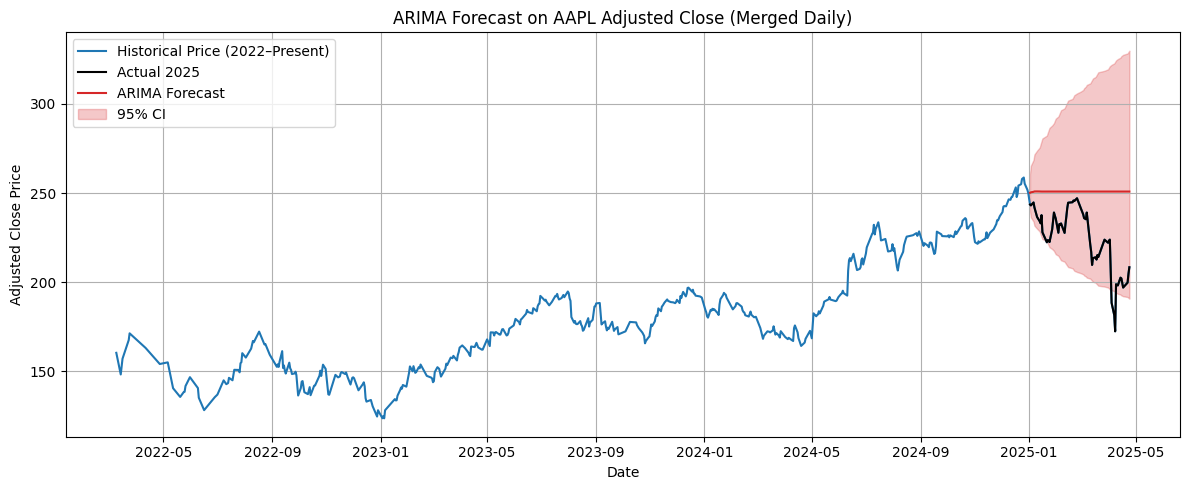

In [190]:
# ARIMA Forecast on Merged Daily Adjusted Close (Stationarized)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# --- 1) Prepare the series from merged_daily ---
# merged_daily must contain 'day_date' and 'adjusted_close'
ts = merged_daily[['day_date', 'adjusted_close']].copy()
ts['day_date'] = pd.to_datetime(ts['day_date'])
ts = ts.set_index('day_date').sort_index()

# --- 2) Log‐transform and difference to improve stationarity ---
ts['log_adj_close'] = np.log(ts['adjusted_close'])
# We let ARIMA handle one order of differencing, but we can inspect stationarity:
# from statsmodels.tsa.stattools import adfuller
# print(adfuller(ts['log_adj_close'].dropna()) )

# --- 3) Train/Test split: train 2022–2024, test 2025 onward ---
train = ts.loc['2022-01-01':'2024-12-31', 'log_adj_close']
test  = ts.loc['2025-01-01':        , 'log_adj_close']

# --- 4) Fit ARIMA(p,d,q) on the log‐series ---
# Here order=(5,1,0) means AR(5), difference once, MA(0)
model = sm.tsa.ARIMA(train, order=(5,1,0))
res   = model.fit()

# --- 5) Forecast the same length as test ---
n_steps        = len(test)
forecast_res   = res.get_forecast(steps=n_steps)
pred_log       = forecast_res.predicted_mean
conf_int       = forecast_res.conf_int(alpha=0.05)

# Align indices
pred_log.index = test.index
conf_int.index = test.index

# Convert back from log to price
pred_price = np.exp(pred_log)
ci_lower   = np.exp(conf_int['lower log_adj_close'])
ci_upper   = np.exp(conf_int['upper log_adj_close'])
actual     = ts.loc[test.index, 'adjusted_close']

# --- 6) Compute RMSE on price scale ---
rmse = np.sqrt(mean_squared_error(actual, pred_price))
print(f"RMSE (2025) on adjusted close: {rmse:.2f}")

# --- 7) Plot results ---
plt.figure(figsize=(12,5))
plt.plot(ts['adjusted_close'], label='Historical Price (2022–Present)', color='C0')
plt.plot(actual,       label='Actual 2025',               color='k')
plt.plot(pred_price,   label='ARIMA Forecast',            color='C3')
plt.fill_between(pred_price.index, ci_lower, ci_upper,
                 color='C3', alpha=0.25, label='95% CI')
plt.title('ARIMA Forecast on AAPL Adjusted Close (Merged Daily)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Train periods: 2022-03-14 00:00:00 to 2024-12-31 00:00:00
 Test periods: 2025-01-02 00:00:00 to 2025-04-24 00:00:00


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMaste

Best ARIMAX(p,d,q) by AIC = (1, 1, 1), AIC = -2319.3
ARIMAX RMSE on 2025: 39.58


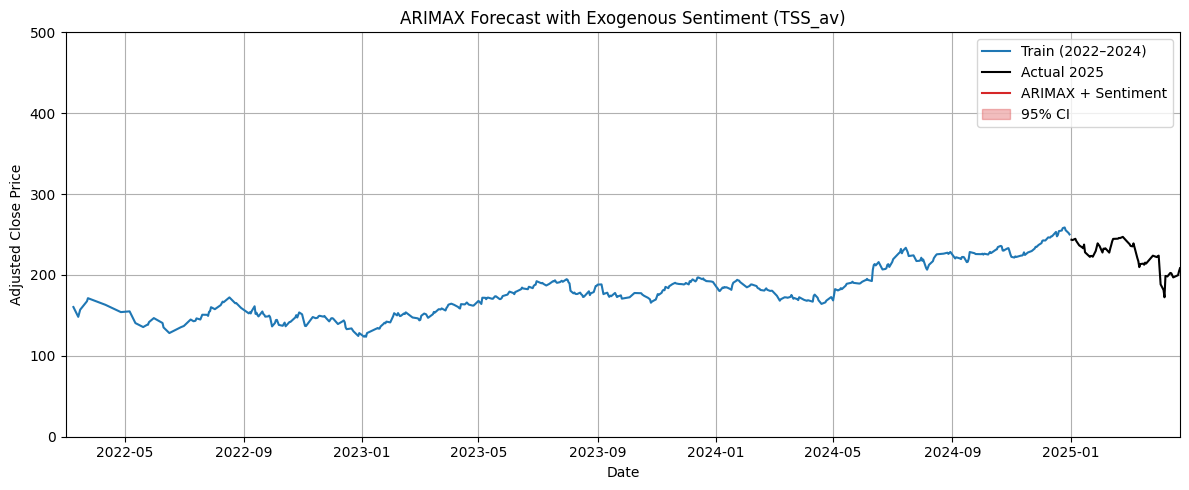

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import product
from sklearn.metrics import mean_squared_error

# 1) Prepare the series -------------------------------------------------------

# assume merged_daily has a 'day_date' column and 'adjusted_close' + 'TSS_av'
df = merged_daily.copy()
df['day_date'] = pd.to_datetime(df['day_date'])
df = df.set_index('day_date').sort_index()

# log-price series and first-difference (i.e. log‐return)
logp = np.log(df['adjusted_close'])
y    = logp.diff().dropna()

# exogenous: yesterday's sentiment
X    = df['TSS_av'].shift(1).loc[y.index].to_frame('TSS_av')

# 2) Train/test split --------------------------------------------------------

train_end = '2024-12-31'
y_train   = y.loc[:train_end]
y_test    = y.loc['2025-01-01':]
X_train   = X.loc[:train_end]
X_test    = X.loc['2025-01-01':]

# sanity check:
print("Train periods:", y_train.index.min(), "to", y_train.index.max())
print(" Test periods:", y_test.index.min(),  "to", y_test.index.max())

# 3) Grid‐search ARIMAX by AIC -----------------------------------------------

best_aic   = np.inf
best_order = None

for p, q in product(range(4), range(4)):
    try:
        m = sm.tsa.SARIMAX(
            y_train,
            exog        = X_train,
            order       = (p, 0, q),   # note: we've already differenced once above
            enforce_stationarity   = False,
            enforce_invertibility   = False
        )
        r = m.fit(disp=False)
        if r.aic < best_aic:
            best_aic, best_order = r.aic, (p, 1, q)
    except Exception:
        continue

print(f"Best ARIMAX(p,d,q) by AIC = {best_order}, AIC = {best_aic:.1f}")

# 4) Refit on full training set ----------------------------------------------

p, d, q = best_order
model = sm.tsa.SARIMAX(
    y_train,
    exog  = X_train,
    order = (p, 0, q)
)
res = model.fit(disp=False)

# 5) Forecast log-returns for 2025 + re-integrate to level -------------------

n_steps       = len(y_test)
fc_results    = res.get_forecast(steps=n_steps, exog=X_test)
pred_ret      = fc_results.predicted_mean

# build predicted log-price by cumulatively summing
last_logp     = logp.loc[train_end]
pred_logp     = last_logp + pred_ret.cumsum()
pred_price    = np.exp(pred_logp)

# 95% CI for returns → transform to price CI
ci_ret        = fc_results.conf_int()
low_logp      = last_logp + ci_ret.iloc[:,0].cumsum()
high_logp     = last_logp + ci_ret.iloc[:,1].cumsum()
low_price     = np.exp(low_logp)
high_price    = np.exp(high_logp)

# actual 2025 prices
test_df       = df.loc['2025-01-01':]
actual_price  = test_df['adjusted_close']

# 6) Evaluate -----------------------------------------------------------------

rmse = np.sqrt(mean_squared_error(actual_price, pred_price))
print(f"ARIMAX RMSE on 2025: {rmse:.2f}")

# 7) Plot ---------------------------------------------------------------------

# … your existing code that builds train_df, actual_price, pred_price, low_price, high_price …

plt.figure(figsize=(12,5))
plt.plot(
    df['adjusted_close'].loc[:train_end],
    label='Train (2022–2024)', color='C0'
)
plt.plot(
    actual_price,
    label='Actual 2025',       color='k'
)
plt.plot(
    pred_price,
    label='ARIMAX + Sentiment', color='C3'
)
plt.fill_between(
    pred_price.index,
    low_price,
    high_price,
    color='C3', alpha=0.3,
    label='95% CI'
)
plt.title("ARIMAX Forecast with Exogenous Sentiment (TSS_av)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.grid(True)

# … your existing plotting code …

# zoom x-axis
start = pd.to_datetime('2022-03-01')
end   = df.index.max()
plt.xlim(start, end)

# cap y-axis at 500
plt.ylim(0, 500)

plt.tight_layout()
plt.show()




In [9]:
df_combined.columns

Index(['time_published', 'TSS_av', 'TRS_av', 'title', 'summary', 'price_open',
       'price_high', 'price_low', 'price_close', 'adjusted_close', 'volume',
       'daily_return', 'idx', 'TSS_llm', 'TRS_llm', 'TPI_llm', 'TSS_llm+t',
       'TRS_llm+t', 'TPI_llm+t', 'TSS_llm+t+f', 'TRS_llm+t+f', 'TPI_llm+t+f',
       'fundamental_score', 'valuation_label'],
      dtype='object')

 Recomendaciones:
Si también quieres probar combinaciones como "TSS_llm+t+f" o "TPI_llm+t" como features, puedes cambiar fácilmente la lista features = df[[...]].

Este modelo evalúa si los scores del LLM anticipan correctamente retornos semanales. Si el RMSE es alto, posiblemente se necesite más señal o mayor limpieza de outliers/neutros.

Fold 1 RMSE: 0.009357281196631399


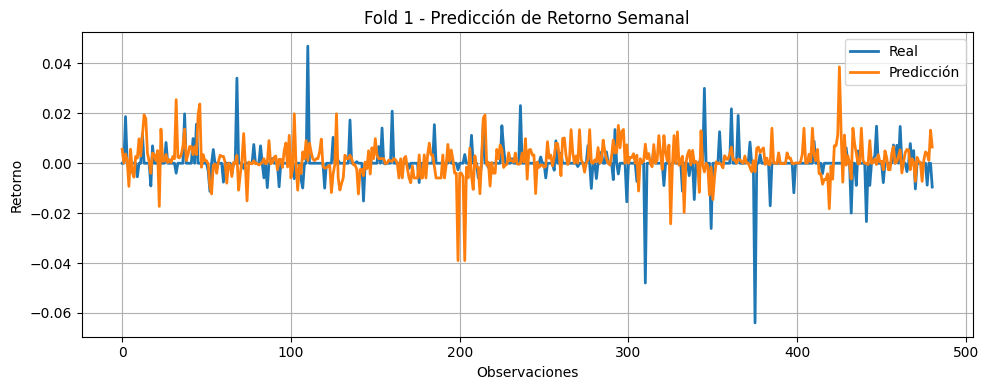

Fold 2 RMSE: 0.00902711012580388


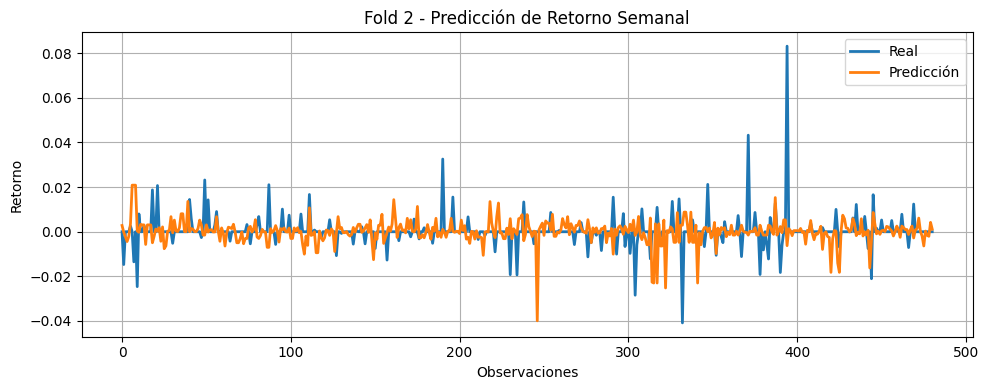

Fold 3 RMSE: 0.014040967242246235


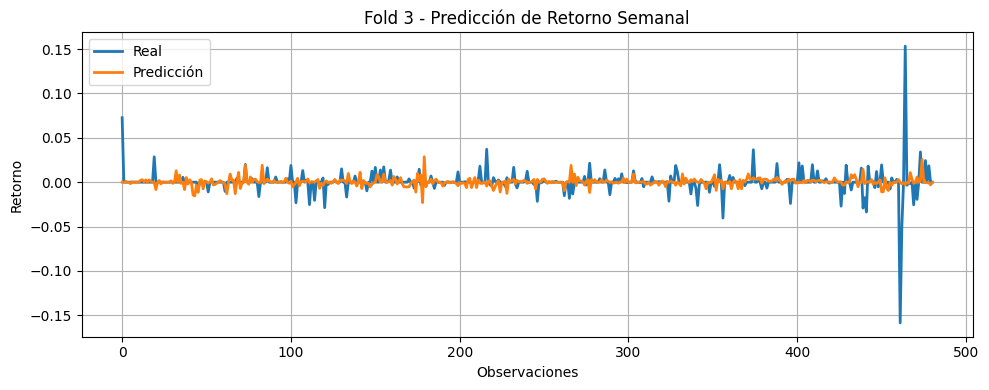

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────
# 1. Cargar y preparar df_combined
# ──────────────────────────────────────────────
# Asegúrate de tener df_combined cargado con columnas: time_published, adjusted_close, etc.

df = df_combined.copy()
df = df.sort_values("time_published").reset_index(drop=True)

# Calcular retorno siguiente semana si no existe
if "return_next_week" not in df.columns:
    df["adjusted_close_next_week"] = df["adjusted_close"].shift(-1)
    df["return_next_week"] = (df["adjusted_close_next_week"] - df["adjusted_close"]) / df["adjusted_close"]
    df.dropna(subset=["return_next_week"], inplace=True)

# ──────────────────────────────────────────────
# 2. Selección de features y target
# ──────────────────────────────────────────────
features = df[[
    "TSS_llm",          # Sentiment score LLM
    "TRS_llm",          # Relevance score LLM
    "TPI_llm",          # Price impact LLM
    "fundamental_score" # Health of company
]]

target = df["return_next_week"]

# ──────────────────────────────────────────────
# 3. Validación temporal y entrenamiento
# ──────────────────────────────────────────────
tscv = TimeSeriesSplit(n_splits=3)

for fold, (train_idx, test_idx) in enumerate(tscv.split(features)):
    X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # ─ Resultados ─
    print(f"Fold {fold + 1} RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


    # ─ Visualización ─
    plt.figure(figsize=(10, 4))
    plt.plot(y_test.reset_index(drop=True), label="Real", linewidth=2)
    plt.plot(y_pred, label="Predicción", linewidth=2)
    plt.title(f"Fold {fold + 1} - Predicción de Retorno Semanal")
    plt.xlabel("Observaciones")
    plt.ylabel("Retorno")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\Victor\AppData\Local\Temp\ipykernel_9940\2900995925.py:12: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["return_next_week"] = df["adjusted_close"].pct_change(5).shift(-5)


🟢 Train: 2251 filas | 🔵 Test: 189 filas
📉 RMSE en test set 2025: 0.04082


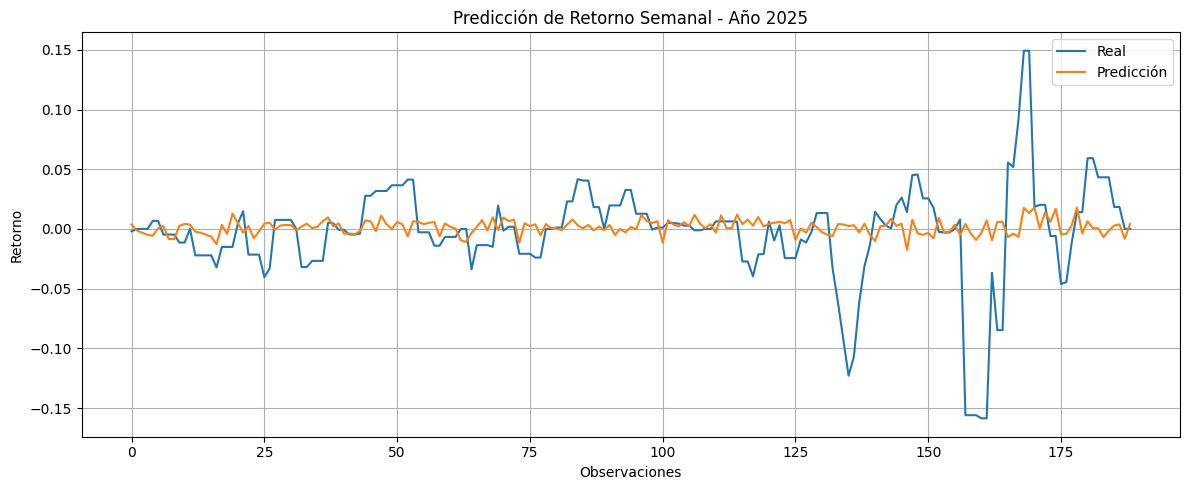

In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ─── Cargar el dataset combinado ───
df = df_combined.copy()
df["time_published"] = pd.to_datetime(df["time_published"])
df = df.sort_values("time_published")

# ─── Crear variable target ───
df["return_next_week"] = df["adjusted_close"].pct_change(5).shift(-5)
df = df.dropna(subset=["return_next_week"])

# ─── Dividir el dataset ───
df_train = df[df["time_published"] < "2025-01-01"].copy()
df_test = df[df["time_published"] >= "2025-01-01"].copy()

print(f"🟢 Train: {df_train.shape[0]} filas | 🔵 Test: {df_test.shape[0]} filas")

# ─── Selección de variables ───
features = [
    "TSS_llm", "TRS_llm", "TPI_llm",
    "TSS_llm+t", "TRS_llm+t", "TPI_llm+t",
    "TSS_llm+t+f", "TRS_llm+t+f", "TPI_llm+t+f",
    "fundamental_score"
]

X_train = df_train[features]
y_train = df_train["return_next_week"]

X_test = df_test[features]
y_test = df_test["return_next_week"]

# ─── Entrenamiento del modelo ───
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ─── Predicción ───
y_pred = model.predict(X_test)
# Calcular RMSE manualmente
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"📉 RMSE en test set 2025: {rmse:.5f}")


# ─── Gráfico de comparación ───
plt.figure(figsize=(12, 5))
plt.plot(y_test.reset_index(drop=True), label="Real", linewidth=1.5)
plt.plot(y_pred, label="Predicción", linewidth=1.5)
plt.title("Predicción de Retorno Semanal - Año 2025")
plt.xlabel("Observaciones")
plt.ylabel("Retorno")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMaste

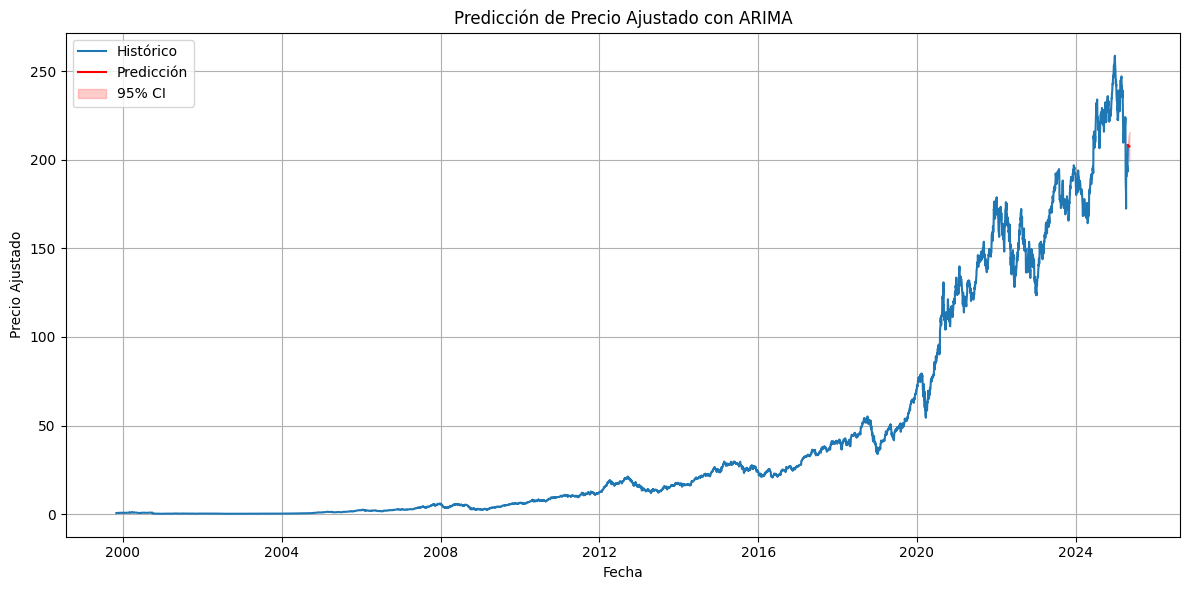

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.tseries.offsets import BDay

# --- Cargar precios diarios ---
price_path = r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\data\extract\stocks\AAPL\prices\AAPL_daily_adjusted.csv"
df_price = pd.read_csv(price_path)

# --- Formateo de columnas ---
df_price.columns = [col.strip().split(".")[-1].strip() for col in df_price.columns]
df_price = df_price.rename(columns={"adjusted close": "adjusted_close"})
df_price["date"] = pd.to_datetime(df_price["date"])
df_price = df_price.sort_values("date")

# --- Crear serie temporal ---
df_ts = df_price.set_index("date")[["adjusted_close"]]

# --- Entrenamiento ARIMA ---
model = sm.tsa.ARIMA(df_ts, order=(5,1,0))  # (p,d,q) puedes ajustar
model_fit = model.fit()

# --- Predicción (por ejemplo, 10 días hábiles hacia adelante) ---
forecast_steps = 10
forecast = model_fit.get_forecast(steps=forecast_steps)
pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()

# --- Crear índice de fechas futuras ---
last_date = df_ts.index[-1]
future_dates = [last_date + BDay(i+1) for i in range(forecast_steps)]
pred_mean.index = future_dates
pred_ci.index = future_dates

# --- Gráfico ---
plt.figure(figsize=(12, 6))
plt.plot(df_ts, label="Histórico")
plt.plot(pred_mean, color="red", label="Predicción")
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='red', alpha=0.2, label="95% CI")
plt.title("Predicción de Precio Ajustado con ARIMA")
plt.xlabel("Fecha")
plt.ylabel("Precio Ajustado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMaste

📉 RMSE en test set (2025 completo): 31.1762


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


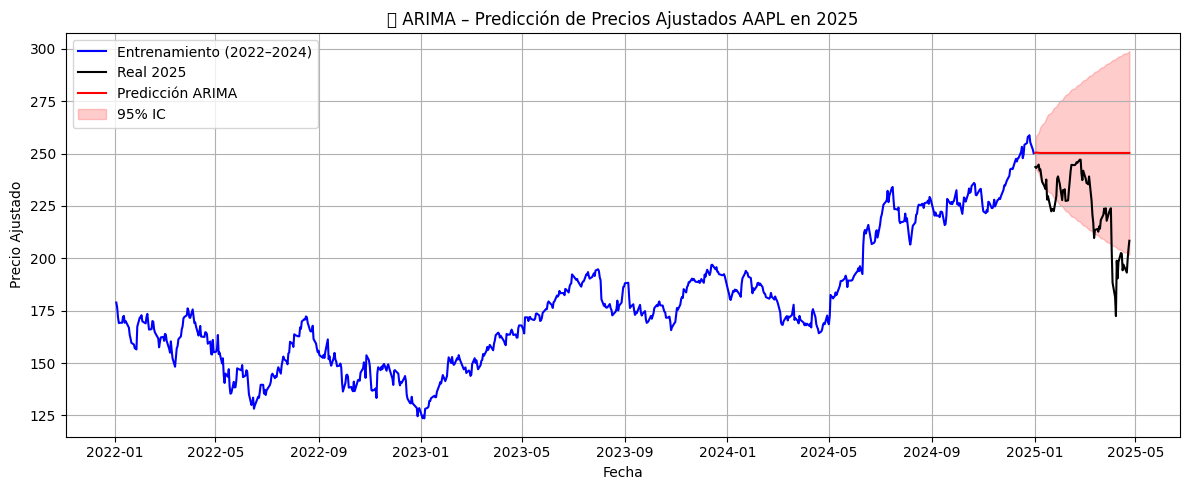

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# --- Cargar precios diarios ---
price_path = r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\data\extract\stocks\AAPL\prices\AAPL_daily_adjusted.csv"
df_price = pd.read_csv(price_path)

# --- Limpiar columnas y formatear ---
df_price.columns = [col.strip().split(".")[-1].strip() for col in df_price.columns]
df_price = df_price.rename(columns={"adjusted close": "adjusted_close"})
df_price["date"] = pd.to_datetime(df_price["date"])
df_price = df_price.sort_values("date")

# --- Separar train (2022–2024) y test (2025) ---
train_df = df_price[(df_price["date"] >= "2022-01-01") & (df_price["date"] < "2025-01-01")].set_index("date")
test_df = df_price[df_price["date"] >= "2025-01-01"].set_index("date")

# --- Entrenar ARIMA sobre datos históricos ---
model = sm.tsa.ARIMA(train_df["adjusted_close"], order=(5, 1, 0))  # Puedes ajustar orden con AIC
model_fit = model.fit()

# --- Predecir para 2025 completo ---
forecast = model_fit.get_forecast(steps=len(test_df))
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()
predicted_mean.index = test_df.index
conf_int.index = test_df.index

# --- Métrica de evaluación ---
rmse = np.sqrt(mean_squared_error(test_df["adjusted_close"], predicted_mean))
print(f"📉 RMSE en test set (2025 completo): {rmse:.4f}")

# --- Visualización ---
plt.figure(figsize=(12, 5))
plt.plot(train_df["adjusted_close"], label="Entrenamiento (2022–2024)", color="blue")
plt.plot(test_df["adjusted_close"], label="Real 2025", color="black")
plt.plot(predicted_mean, label="Predicción ARIMA", color="red")
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.2, label="95% IC")
plt.title("📈 ARIMA – Predicción de Precios Ajustados AAPL en 2025")
plt.xlabel("Fecha")
plt.ylabel("Precio Ajustado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [83]:
import pandas as pd
import numpy as np

# --- Cargar datos ---
df_price = pd.read_csv(price_path, parse_dates=["date"])
df_price = df_price.rename(columns={"5. adjusted close": "adjusted_close"})
df_price = df_price.sort_values("date")

# --- Crear columna de retorno a 7 días vista ---
df_price["return_next_7d"] = df_price["adjusted_close"].pct_change(periods=7).shift(-7)

# --- Limpiar df_news (noticias) ---
df_news["time_published"] = pd.to_datetime(df_news["time_published"])
df_news = df_news.sort_values("time_published")

# --- Merge sin redondear fecha: buscar fecha anterior de mercado abierto ---
# Crear diccionario de fechas válidas en precios
valid_dates = df_price["date"].values

# Para cada fecha en df_news, buscar la fecha más cercana anterior en df_price
def match_to_market_date(pub_date):
    return valid_dates[valid_dates <= np.datetime64(pub_date)][-1] if any(valid_dates <= np.datetime64(pub_date)) else np.nan

df_news["matched_date"] = df_news["time_published"].apply(match_to_market_date)
df_news = df_news.dropna(subset=["matched_date"])

# --- Merge final ---
df_merged = pd.merge(df_price, df_news, left_on="date", right_on="matched_date", how="left")

# --- Mostrar resultado limpio ---
cols_to_show = [
    "date", "adjusted_close", "return_next_7d", 
    "ticker_sentiment_score", "ticker_relevance_score", 
    "title", "summary"
]

print(df_merged[cols_to_show].dropna(subset=["ticker_sentiment_score"]).head(20))


           date  adjusted_close  return_next_7d  ticker_sentiment_score  \
5623 2022-03-08      154.934593        0.020198                0.520191   
5624 2022-03-09      160.356910        0.006321                0.608306   
5626 2022-03-11      152.267718        0.091062               -0.662196   
5627 2022-03-14      148.223122        0.130062               -0.662196   
5629 2022-03-16      157.050379        0.094805                0.365825   
5631 2022-03-18      161.370519        0.091353                0.430615   
5632 2022-03-21      162.748240        0.074918               -0.636192   
5633 2022-03-21      162.748240        0.074918               -0.361334   
5634 2022-03-21      162.748240        0.074918               -0.325561   
5635 2022-03-21      162.748240        0.074918               -0.380106   
5636 2022-03-21      162.748240        0.074918               -0.380106   
5637 2022-03-22      166.133498        0.034297                0.433494   
5638 2022-03-23      167.

c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init

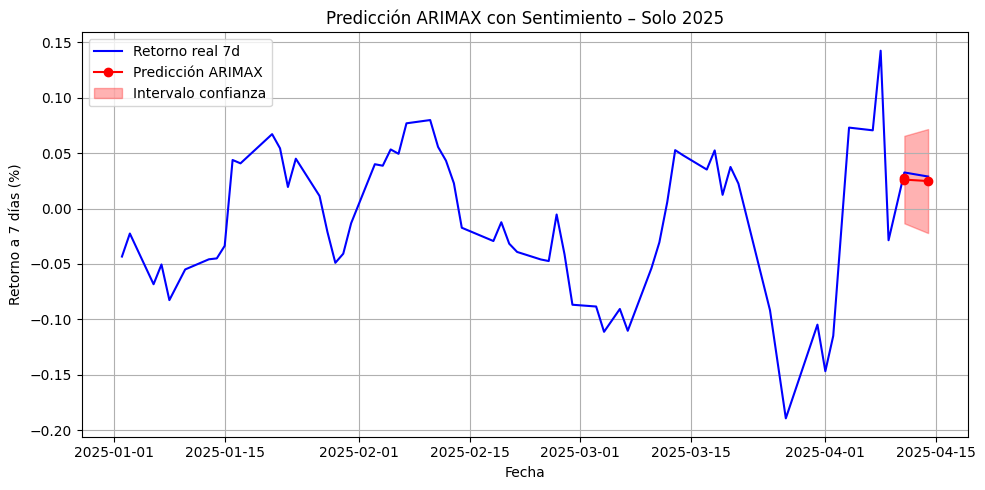

In [84]:


# Dataset modelado
df_model = df_merged.dropna(subset=["return_next_7d", "ticker_sentiment_score"])[
    ["date", "return_next_7d", "ticker_sentiment_score"]
].copy()

# Entrenamiento en todo el dataset con ARIMAX
endog = df_model["return_next_7d"]
exog = df_model[["ticker_sentiment_score"]]
model = sm.tsa.ARIMA(endog=endog, exog=exog, order=(1, 0, 0)).fit()

# Predicción para los 3 últimos puntos
X_pred = exog.iloc[-3:]
forecast = model.get_forecast(steps=3, exog=X_pred)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# --- Visualización centrada en 2025 ---
df_2025 = df_model[df_model["date"].dt.year == 2025].copy()

plt.figure(figsize=(10, 5))
plt.plot(df_2025["date"], df_2025["return_next_7d"], label="Retorno real 7d", color="blue")
plt.plot(df_2025["date"].iloc[-3:], forecast_mean, label="Predicción ARIMAX", color="red", marker="o")
plt.fill_between(df_2025["date"].iloc[-3:], conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color="red", alpha=0.3, label="Intervalo confianza")

plt.title("Predicción ARIMAX con Sentimiento – Solo 2025")
plt.xlabel("Fecha")
plt.ylabel("Retorno a 7 días (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [85]:
# Mostrar resumen completo del modelo
print("🔍 RESUMEN DEL MODELO ARIMAX:")
print(model.summary())

# --- Interpretación básica ---
print("\n📈 MÉTRICAS CLAVE:")
print(f"AIC: {model.aic:.2f}")
print(f"BIC: {model.bic:.2f}")
print(f"Log-Likelihood: {model.llf:.2f}")

# --- P-values de los coeficientes ---
print("\n📉 P-VALUES DE LOS COEFICIENTES:")
print(model.pvalues)

# --- Coeficientes ---
print("\n⚙️ COEFICIENTES:")
print(model.params)

# --- Diagnóstico de residuos ---
residuals = model.resid

print("\n📊 ESTADÍSTICAS DE RESIDUOS:")
print(f"Media: {residuals.mean():.5f}")
print(f"Desviación estándar: {residuals.std():.5f}")
print(f"Skew: {residuals.skew():.2f}")
print(f"Kurtosis: {residuals.kurt():.2f}")


🔍 RESUMEN DEL MODELO ARIMAX:
                               SARIMAX Results                                
Dep. Variable:         return_next_7d   No. Observations:                 2427
Model:                 ARIMA(1, 0, 0)   Log Likelihood                6797.100
Date:                Tue, 06 May 2025   AIC                         -13586.199
Time:                        12:42:31   BIC                         -13563.022
Sample:                             0   HQIC                        -13577.772
                               - 2427                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0062      0.005      1.239      0.215      -0.004       0.016
ticker_sentiment_score    -0.0016      0.001     -2.393      0.017

# 📊 ARIMAX Model Comparison: Small Sample vs. Full Dataset

This notebook documents and compares two ARIMAX models built to predict **7-day forward returns** of Apple (AAPL), using financial news sentiment as an external regressor.

---

## 🔍 Model 1: **Initial Sample (~2,427 observations)**

| Metric                        | Value              | Interpretation |
|------------------------------|--------------------|----------------|
| **AIC**                      | -13,587            | Reasonable model fit |
| **AR(1) Coefficient**        | 0.9382 (p < 0.001) | Strong autocorrelation in returns |
| **Sentiment Coefficient**    | -0.0018 (**p = 0.009**) | Statistically significant — minor **negative** impact |
| **Sigma²**                   | 0.0002             | Low error variance |
| **Ljung-Box (p)**            | 0.18               | No autocorrelation in residuals |
| **Jarque-Bera (JB)**         | 64,919             | Residuals **not normal** |
| **Skew / Kurtosis**          | 0.08 / 28.34       | Heavy tails, likely overreactive returns |

✅ **Pros**:
- Sentiment variable was **significant**
- Model interpretable and quick to train

❌ **Cons**:
- High JB statistic and kurtosis suggest **non-normal residuals**
- Only ~2,400 points → higher uncertainty

---

## 📈 Model 2: **Full Dataset (~26,826 observations)**

| Metric                        | Value              | Interpretation |
|------------------------------|--------------------|----------------|
| **AIC**                      | -214,000           | Very strong model fit (better than Model 1) |
| **AR(1) Coefficient**        | 0.9952 (p < 0.001) | Extremely high autocorrelation |
| **Sentiment Coefficient**    | -0.00005 (**p = 0.591**) | **Not significant** → likely useless |
| **Sigma²**                   | 0.00002            | Excellent precision |
| **Ljung-Box (p)**            | 0.66               | No autocorrelation in residuals |
| **Jarque-Bera (JB)**         | 57 million (!)     | Residuals highly non-normal |
| **Skew / Kurtosis**          | -0.97 / 230.07 (!) | Extreme distribution: model might overfit |

✅ **Pros**:
- Massive dataset improves **stability** and reduces error
- Strong autocorrelation model captured

❌ **Cons**:
- **Sentiment variable loses all predictive power**
- Residuals are extremely skewed and fat-tailed → undermines statistical inference

---

## ✅ Conclusion

- **Model 1** performs **better at capturing sentiment-driven effects**, but is based on a **smaller dataset**.
- **Model 2** is **more stable** and has **lower error**, but **sentiment adds no value**.

### 👉 Next Step:
To build a robust predictive system:
- Explore **non-linear models** like **Random Forest**, **Gradient Boosting**, or **LSTM**.
- Integrate **more features** (e.g., volume shocks, fundamentals, event labels).
- Consider **classification** ("price up or down") instead of regression for more robust results.

